In [1]:
#!pip3 install neat-python

from keras.datasets import mnist
import numpy as np
import ssl
import neat
from skimage.transform import rescale
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pickle

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:463: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:464: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:465: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

## Global Parameters

In [2]:
# Dataset parameters
STANDARD_IMAGE_SIZE = 28
DESIRED_IMAGE_SIZE = 16
N_CLASSES_TO_USE = 10

RESCALE_FACTOR = DESIRED_IMAGE_SIZE/STANDARD_IMAGE_SIZE
N_PIXELS = DESIRED_IMAGE_SIZE**2

# How many samples to test:
N_SAMPLES_TO_TEST = 200

# Simulation Parameters
NR_GENERATIONS =1000
CONFIG_FILE = 'NEAT-configs/mnist-wann'

## Load MNIST

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

## Preprocess MNIST

### Trim down Dataset

In [4]:
# Ensure correct number of classes
X_train = X_train[Y_train < N_CLASSES_TO_USE]
Y_train = Y_train[Y_train < N_CLASSES_TO_USE]
X_test = X_test[Y_test < N_CLASSES_TO_USE]
Y_test = Y_test[Y_test < N_CLASSES_TO_USE]

# Extract and print the number of training and testing samples remaining
n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]
print(f"Training samples remaining: {n_samples_train}")
print(f"Testing samples remaining: {n_samples_test}")

Training samples remaining: 60000
Testing samples remaining: 10000


### Rescale Images

In [5]:
# Rescaling to the desired size
def rescale_images(images, do_anti_aliasing=False):
    return np.array([rescale(image, RESCALE_FACTOR, anti_aliasing=do_anti_aliasing) for image in images])

# Rescale X_train and X_test
X_train_small = rescale_images(X_train)
X_test_small = rescale_images(X_test)

### Normalize

In [6]:
# Normalize the data
def normalize(images):
    return (images - np.mean(images, axis=0))/(np.std(images, axis=0) + 0.000001)

# Normalize X_train_small and X_test_small
X_train_norm = normalize(X_train_small)
X_test_norm = normalize(X_test_small)

### Visualize

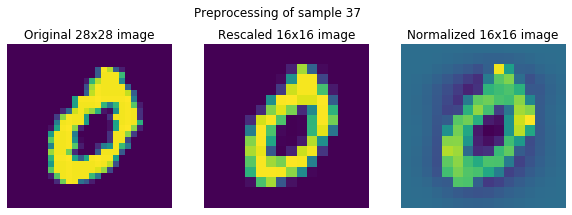

In [7]:
# Plot original and reshaped image
def plot_comparison(idx_to_plot, lists, titles):
    n_plots = len(lists)
    fig, ax = plt.subplots(1,n_plots, figsize=(10,10/n_plots))
    for i in range(n_plots):
        ax[i].imshow(lists[i][idx_to_plot])
        ax[i].set_title(titles[i])
        ax[i].axis("off")
    fig.suptitle(f"Preprocessing of sample {idx_to_plot}",y=1)
    plt.show()
    
plot_comparison(37,
                [X_train, X_train_small, X_train_norm],
                [f"Original {STANDARD_IMAGE_SIZE}x{STANDARD_IMAGE_SIZE} image",
                 f"Rescaled {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image",
                 f"Normalized {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image"])

In [8]:
# Replace and reshape X_train and X_test, for convenience
X_train = X_train_norm.reshape(n_samples_train, DESIRED_IMAGE_SIZE**2)
X_test = X_test_norm.reshape(n_samples_test, DESIRED_IMAGE_SIZE**2)

# NEAT

## Basic Run Function

In [32]:
def exp(x):
    return np.exp(np.clip(x, -float('inf'), 709.))

def sigmoid(output):
    output = [min(709., x) for x in output]
    output = [max(-709., x) for x in output]
    return [1 /(1 + exp(-x)) for x in output]

In [33]:
def step(x):
    return 1.0*(x>0.0)

def cos(x):
    return math.cos(x)

def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    
    

    config.genome_config.add_activation('cos', cos)
    config.genome_config.add_activation('step', step)
    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)
    
    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(50, filename_prefix='NEAT-checkpoints/neat-checkpoint-10-classes-'))
    
    
    # Run for up to NR_GENERATIONS generations.
    winner = p.run(eval_genomes, NR_GENERATIONS)
    stats.save_genome_fitness(filename="NEAT-results/fitness_history.csv")
    
    with open('NEAT-results/best_genomes', 'wb') as f:
        best_genomes = stats.best_genomes(10)
        pickle.dump(best_genomes,f)
    
    
    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))


## Basic Evaluation Function

In [34]:
def eval_genomes(genomes, config):
    
    def _cross_entropy(pred, label):
        return -np.log(exp(pred[label])/np.sum(exp(pred), axis=0))
    
    sample_indices = []
    n_samples_per_class = int(N_SAMPLES_TO_TEST/N_CLASSES_TO_USE)
    for c in range(N_CLASSES_TO_USE):
        c_indices = np.where(Y_train == c)[0]
        assert len(c_indices) >= n_samples_per_class, \
            f"Class {c} has too few elements to reach the desired number of evaluation samples"
        sample_indices.extend(np.random.permutation(c_indices)[:n_samples_per_class])
    
    # Compute cross-entropy loss for each of the samples
    losses = []
    for i in sample_indices:
        X_sample, Y_sample = X_train[i], Y_train[i]
        
    
    for genome_id, genome in genomes:
        ce = []
        
        genome.fitness = 0.
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        nr_correct = 0.
        for i in sample_indices:
            train, label = X_train[i], Y_train[i]
            output = net.activate(train)
            ce.append(-_cross_entropy(sigmoid(output), label))
#             if np.argmax(sigmoid(output)) == label:
#                 nr_correct += 1.

        genome.fitness = np.average(ce)         
 

In [35]:
run(CONFIG_FILE)


 ****** Running generation 0 ****** 

cos
-2.564048241298201
cos
-3.0910810800697135
cos
-1.3994239606361443
cos
-0.3093140849203918
cos
-1.5450673824846426
cos
-0.5394809714982574
cos
7.712802066677902
cos
-1.7100270890077445
cos
3.890607324870404
cos
-1.9778008768627509
cos
1.2225509608621787
cos
-1.344557386993269
cos
3.9868648856839246
cos
-0.3028626630679936
cos
-3.3828909854639178
cos
-1.393944372775474
cos
3.619550518521718
cos
-2.2839813479550966
cos
-0.45865907735853817
cos
3.0268478612023815
cos
0.8069472009702939
cos
-0.38377100711356116
cos
-0.7914451062566996
cos
1.7813253329729257
cos
1.0866140085148759
cos
-0.9415184498512541
cos
1.645534206888824
cos
-0.9685874326257222
cos
-0.21541333998939638
cos
0.9882601976217922
cos
-3.440109272517324
cos
1.7306114869069984
cos
-0.9253519476255609
cos
-2.3531312583168673
cos
-1.1820326225336117
cos
0.9504462266134268
cos
3.234933708134003
cos
-0.8028644477463511
cos
-2.6775105361480582
cos
3.7449250038936177
cos
-7.836170813296174

cos
-1.6174877450587817
cos
-2.2912944187828774
cos
0.03826695518912125
cos
4.3689068442106755
cos
-3.804568104003142
cos
0.6240762936776413
cos
10.548875706090971
cos
3.9019330252585505
cos
7.104541583212025
cos
4.130866521086018
cos
0.8213510331910089
cos
-3.7551932069557967
cos
-0.6995273123598906
cos
14.692475509203916
cos
3.876840421669966
cos
14.915593944120996
cos
8.906589020777817
cos
-3.415331729536157
cos
1.0477255459661363
cos
-1.5197327225008563
cos
-1.0158240984028835
cos
0.9904878248032872
cos
-2.4362417498207187
cos
-2.135535728681903
cos
-1.575620677469927
cos
-0.3345265498952682
cos
1.5287593686572731
cos
-3.5607727669574967
cos
-2.1171033940528288
cos
0.05966796457331501
cos
-1.4375148495476704
cos
0.24740367778738892
cos
-1.4580742855692705
cos
-3.36420858883673
cos
-0.8270410907577008
cos
-2.4246134891708477
cos
1.0759590107485097
cos
-3.8928067367611145
cos
-0.44394436410116
cos
-3.319016907642017
cos
-1.887883147036344
cos
-0.12178353725841941
cos
2.64506075681393

cos
-3.6104942171349363
cos
2.552370411390665
cos
-2.682804463737138
cos
-0.3192195983925255
cos
-1.1484189138370737
cos
4.154243833880507
cos
0.4188283806032485
cos
7.656770828761358
cos
-0.3501592305210431
cos
1.3149003373807826
cos
0.6491083818933571
cos
-1.3030915204329523
cos
-0.9283865603797882
cos
-2.275573152418798
cos
0.1635521124513251
cos
-0.5657770305315427
cos
1.3944466592333236
cos
-0.8855037067188883
cos
0.38968881654298154
cos
-1.0762648012693306
cos
0.5424411417928662
cos
-3.608558412675712
cos
1.3746759277321783
cos
-0.7667463482830906
cos
-2.472071375140959
cos
2.138320816693805
cos
-2.400469766709917
cos
-1.7387303057108836
cos
0.15373714840509506
cos
-1.8765660157182535
cos
-0.18961482769189786
cos
6.377923186069293
cos
0.5270675666667444
cos
-2.00463299072549
cos
0.93423735600932
cos
-0.09466862208307614
cos
2.857900768844788
cos
-0.10570887854922484
cos
-0.8607630338969083
cos
-2.00463299072549
cos
-0.9800971906676041
cos
0.22108271284855457
cos
-2.00463299072549

cos
24.568261371787422
cos
0.7212016981674013
cos
-0.6021089472963748
cos
-4.093712096446312
cos
-2.090178544523386
cos
-0.7672310358606576
cos
1.6254970439220096
cos
1.2339145277049082
cos
-3.052890711408693
cos
4.9269489907330355
cos
1.1808289067968682
cos
0.6789792814150836
cos
0.23733578756879137
cos
0.43248540128393664
cos
-2.0548974552744044
cos
-0.8701025370815629
cos
2.7617270360738364
cos
3.428239067531184
cos
2.985170283979436
cos
7.427104580399214
cos
3.7457783738466306
cos
1.149548310893638
cos
2.3862088950232256
cos
0.897933636658112
cos
-1.4814462185279977
cos
0.5927527708199135
cos
-1.709092361639382
cos
1.3090334186188395
cos
0.9282652123079516
cos
4.682970739622922
cos
3.8195382044833197
cos
1.9587381499860015
cos
4.039252271351405
cos
-3.075531726135122
cos
-2.8682647828290992
cos
-2.6991927279604684
cos
0.1626393835764166
cos
-0.1645194949418447
cos
-3.022865874527546
cos
-1.7282910165140324
cos
3.6372087536832662
cos
1.4102694914421479
cos
2.193256115199216
cos
-4.5

cos
0.8741334475492311
cos
7.160500151416723
cos
-0.30935493424965055
cos
-3.574602567654935
cos
1.6340370077627497
cos
-3.447031117805111
cos
-2.772839969267309
cos
-6.675494816701468
cos
5.478735463518961
cos
1.209073299679562
cos
2.141214578928968
cos
-2.625647527319581
cos
2.9708326433494543
cos
-0.925565776613483
cos
-1.0988367546213353
cos
-5.721370671584291
cos
-0.7671307800542017
cos
-7.174817697587636
cos
-1.6213467314151109
cos
1.7411793708361343
cos
4.552990817207659
cos
-0.7222379009412521
cos
0.1280238165376715
cos
3.2544242517591826
cos
2.3100690952301854
cos
-4.50353549430141
cos
-2.9485237537823106
cos
-6.803061307190555
cos
-2.6118509085071704
cos
-2.119109403677852
cos
0.23187257368952977
cos
18.50279818206179
cos
-0.7085294331098303
cos
-1.254984573204177
cos
0.17717782888693515
cos
0.6256742382908445
cos
0.6219131343417633
cos
-3.1950663908165367
cos
0.01264841169930278
cos
-4.57717773470408
cos
1.8140091772304203
cos
2.3266995202522307
cos
1.1363389165073856
cos
-2

cos
-0.45118375154370627
cos
1.616688672878933
cos
-0.9875786509745099
cos
2.667540321008126
cos
-2.9043866735310804
cos
-0.22851754116281264
cos
-2.8890503627106208
cos
-1.8021187268486774
cos
-1.5386107367802495
cos
0.5774197045080564
cos
6.27149445024978
cos
8.461299731127584
cos
-1.4699295710102518
cos
-1.4685801184330618
cos
1.6509183049931853
cos
8.799783735704828
cos
-2.379404114119996
cos
2.703698795368563
cos
-1.0066012972172693
cos
-0.29293754226233126
cos
3.220077212334635
cos
-2.037535470996122
cos
5.265905300849221
cos
-2.475744719899179
cos
-3.567529622229392
cos
-4.492539067419354
cos
-2.941137019956305
cos
1.9696196738810665
cos
-1.8348513014602903
cos
0.233416665998176
cos
-3.5232530300707667
cos
-3.2538514978984714
cos
-4.771813874415785
cos
-0.31862950850765603
cos
-2.6667359588665267
cos
4.985543029598639
cos
-0.5296252468942946
cos
-1.0136060881275222
cos
-5.109020831951173
cos
-2.0777261342470004
cos
-1.4791199827651904
cos
-2.0233913580551235
cos
-2.5834972639574

-2.96367808261227
cos
-0.7894367510320152
cos
-2.607938515455009
cos
3.789663314760325
cos
-0.5906673526764313
cos
-1.2149676212440974
cos
3.8029162055855967
cos
-2.1808785332337712
cos
9.092504317719843
cos
23.273363506525534
cos
2.953611398490243
cos
-0.9062688260724904
cos
-0.5944197350641073
cos
4.018394863533642
cos
0.2359667915692113
cos
-0.5669456173366039
cos
-0.963982463786876
cos
-2.5139742276877315
cos
-0.8107772089469819
cos
-0.7442776839623334
cos
1.918993877463248
cos
-1.0707436059391136
cos
0.4328273453503211
cos
-1.4653038366834872
cos
-0.9878991977141781
cos
-0.8017875357977408
cos
3.2379787087674448
cos
-1.850539957302135
cos
-2.9060408167210614
cos
2.8746766076184462
cos
1.5078814929704263
cos
1.2344199545946066
cos
-1.4411412014041167
cos
-0.763432669572433
cos
0.9964501145107484
cos
-2.9736244586625626
cos
-0.9107526852844455
cos
-2.8241820728071794
cos
0.640667243287948
cos
-2.2445129993188444
cos
-3.0182296947751297
cos
2.0558825775800185
cos
-1.1327049765770678


cos
2.4322032529369926
cos
0.8554456428242132
cos
7.6794145789669646
cos
5.256604104202094
cos
2.439188751353097
cos
2.827926884287543
cos
-1.2700334644928681
cos
6.535218004702073
cos
3.9217544515188276
cos
6.9041289110809645
cos
-1.6367148734767054
cos
1.5587491378697356
cos
4.621580300160499
cos
3.1106265313779455
cos
-2.6449844404967884
cos
-0.641419801979757
cos
5.899795026817041
cos
7.4524859278243865
cos
1.2714431430187034
cos
1.8796041686109146
cos
4.587376691858333
cos
3.846634201806927
cos
2.61992187802027
cos
0.7351958910792347
cos
4.8513967408360905
cos
4.3895103430309215
cos
2.4106924398619625
cos
5.684154320697433
cos
0.2560133642102489
cos
2.471202600790042
cos
10.549203618355753
cos
4.14931004981086
cos
5.0228844467189395
cos
1.253442681992856
cos
-2.6531137609929685
cos
5.6278774874536746
cos
3.1484251888077774
cos
3.8835651352896168
cos
3.776783019241038
cos
2.9249661583202777
cos
-4.614219449676893
cos
-3.592228962863042
cos
-2.721948199475569
cos
0.9291051081642905


cos
7.007927689890974
cos
-3.8303586472754216
cos
-2.3687373743594824
cos
-3.4281948533206656
cos
-2.9246984498655024
cos
-4.192118167810782
cos
-2.7923559314866417
cos
-4.17915814279775
cos
-3.069308528006712
cos
-4.205078192823814
cos
-0.6139439866354703
cos
-3.3873745774133734
cos
-4.205078192823814
cos
-1.376292359749907
cos
-4.205078192823814
cos
-3.9918574936667
cos
-4.036701562423741
cos
-2.6660891860363294
cos
-4.1985981803172985
cos
-4.205078192823814
cos
-0.41391826254152997
cos
1.852288813079248
cos
0.5943840157554414
cos
1.020879312036147
cos
-1.4411849612315615
cos
3.8979649604494173
cos
2.003698841903164
cos
7.121069450161122
cos
4.048156593069304
cos
1.3668836232607517
cos
3.1143863573943684
cos
16.27850298051599
cos
-1.7616353292156777
cos
0.13175000821350702
cos
0.9671252404417865
cos
4.472866115995116
cos
-1.4001876775230724
cos
1.6524069529181753
cos
-2.041549673757597
cos
1.820488643032393
cos
-0.3934373226905634
cos
-0.5276172567442098
cos
-0.5370736244733834
cos
-

cos
10.79570625165974
cos
1.2926964479518697
cos
-1.9204168486804178
cos
-0.6270173089763752
cos
2.6154106042811347
cos
-1.4054046361803971
cos
-1.6696530126858276
cos
-6.288243245433613
cos
-4.7160424985998075
cos
8.742389356751017
cos
2.309918383351199
cos
17.185240002146525
cos
-4.54868060164529
cos
-0.8512579871866655
cos
-1.1315302501347508
cos
0.8175624453156896
cos
-4.915021466633399
cos
-3.229192619113805
cos
-5.365723717401292
cos
-5.175133814490726
cos
0.8971201409228128
cos
-0.15602027471110402
cos
-2.067455933375005
cos
-3.692775589223946
cos
-5.71227478922323
cos
-4.391289008881249
cos
-6.4031064280634915
cos
0.9097185770542049
cos
-4.7912409274458865
cos
-1.4002620635182688
cos
-7.52838947377454
cos
4.712597034838191
cos
-7.3580273116840775
cos
-4.150421773664238
cos
-7.578841786995467
cos
0.11843781455525604
cos
1.7317401573262627
cos
1.8007176589429097
cos
-1.6795623301441223
cos
-2.0607026578372856
cos
-1.445519362929097
cos
-4.804374861730544
cos
-6.35879929844292
cos

cos
3.4607946630082718
cos
-1.2003094072672567
cos
-2.778555193657697
cos
-0.5996154778450767
cos
-4.515720854247858
cos
10.307252369090655
cos
7.978274296455704
cos
10.82062105336639
cos
8.455774519641963
cos
6.245083670343828
cos
13.687835152439678
cos
10.26538365985277
cos
-2.43128846470455
cos
4.363211913534633
cos
-0.9083502464935663
cos
8.371907757645227
cos
-0.41502369718104437
cos
4.594463962762969
cos
2.031363034383135
cos
-1.9031287236542263
cos
7.781404065039461
cos
5.286820467010532
cos
8.668618307946167
cos
-3.724167336776007
cos
-5.904326557118887
cos
-0.7979843862952472
cos
2.4396331509920928
cos
-3.1782969760530126
cos
3.631859223373778
cos
1.2696800873010514
cos
-2.3243913869907136
cos
6.585904556472808
cos
-1.421902540330683
cos
-4.371593815619255
cos
-1.7744559025504858
cos
4.3621857843713885
cos
1.087886669246608
cos
-0.5528523281327726
cos
-0.10295998714626686
cos
3.2791948750886677
cos
-1.4898294284228335
cos
-3.0744625274256054
cos
-3.736235150560526
cos
1.518141

cos
-1.9510363340783192
cos
5.485232004758873
cos
-1.5934490931821013
cos
-1.5085956660387478
cos
2.1009022873614334
cos
0.41022830345135286
cos
0.33276338382773785
cos
-2.584319847321623
cos
4.92411836646939
cos
1.4190536820344337
cos
4.458032824937098
cos
0.7025545999531086
cos
0.3031993599987134
cos
0.4264616109948006
cos
-2.435328341615543
cos
11.694908784600305
cos
-3.1946697509888815
cos
-4.065579599413602
cos
0.516788534000695
cos
4.453592838707179
cos
-4.525614137860188
cos
-3.377345587649506
cos
0.31760230491056585
cos
-2.4190757364394315
cos
-2.501755006040396
cos
-0.13574738288169574
cos
-1.753700522780338
cos
-1.0941625573895497
cos
-3.1617316456784277
cos
10.713354956278748
cos
-1.724150126552145
cos
-2.8779923191729235
cos
0.9244727559842718
cos
-1.5343884451337615
cos
-2.5501157945528536
cos
-2.452516551630643
cos
-1.4391093517106355
cos
-1.2683491592231797
cos
-3.1121936334824443
cos
2.0639326849580133
cos
19.74024969965964
cos
15.546579151361172
cos
0.9022597458025144


cos
0.1050161463038381
cos
-2.1439693585147914
cos
3.5102951535900435
cos
-4.1946448118479065
cos
-4.282194984086148
cos
4.0206910502013535
cos
-0.07136216296243844
cos
-0.9980613035412339
cos
-3.7923922496761002
cos
-4.413415075804546
cos
-4.3830562480882245
cos
-1.8203366008731618
cos
0.6803930709625957
cos
-5.549151814489545
cos
0.8787850487382017
cos
-3.7868589381210342
cos
-1.6371491310642314
cos
-1.8927414789876886
cos
-3.5351676052063037
cos
-4.318945412648612
cos
-2.594868627088958
cos
-0.4779825091946131
cos
1.3287088904984365
cos
-1.7109672661851125
cos
0.5449558166850705
cos
-1.804694248715767
cos
-3.2398356060002427
cos
-2.907434322184032
cos
0.662676280385693
cos
-3.0810244218268563
cos
-1.8509813065081007
cos
-1.8097947175834912
cos
-2.7104447364909254
cos
-4.64701264464108
cos
-2.4165426925600295
cos
-1.8510039990699494
cos
-4.097251087566229
cos
-2.4913812608199533
cos
0.8600705784751919
cos
-5.860913999890593
cos
-2.1962039604371575
cos
-1.3637027388910414
cos
2.910525

cos
-2.664422122182272
cos
-4.255728657377769
cos
-3.555426625482032
cos
9.906178190267001
cos
-2.1304111935595818
cos
-3.1941562123204594
cos
-0.28183205877228446
cos
-4.0556524472682085
cos
2.2072879076902767
cos
-0.9767402739643738
cos
2.239728581836744
cos
-2.832795606864977
cos
-3.9935339700551133
cos
-3.148530789379941
cos
-2.5231531140597117
cos
-5.083825914579417
cos
0.5635725194257141
cos
1.888054563302585
cos
-0.4594961216568522
cos
-5.238672061896936
cos
-5.431144375852344
cos
-0.41887098761785413
cos
-0.060585449943217906
cos
-3.7092478368424775
cos
-2.9849275733741476
cos
-4.964945500846156
cos
-4.3142746936400345
cos
-4.402345732811907
cos
-5.431144375852344
cos
-2.397623592209217
cos
-3.889945742008365
cos
-4.948491422904764
cos
-3.5305446316491924
cos
-4.004851694610244
cos
-3.0010970569783346
cos
-5.165924662398233
cos
-2.383099396616915
cos
-4.302081218064253
cos
-5.381782142028159
cos
-3.2615090775546918
cos
1.9493956463888842
cos
-0.8925190551562062
cos
1.0365602033

cos
-0.046748371817324566
cos
1.6577155392393539
cos
-0.9919982650036019
cos
2.769268331698032
cos
-0.9919982650036019
cos
-1.1459230861171892
cos
-0.9919982650036019
cos
-0.6665452918747485
cos
-0.9919982650036019
cos
0.10228231476248323
cos
-0.9919982650036019
cos
-1.3062962650682244
cos
-0.9919982650036019
cos
-1.1348002351509474
cos
-0.9919982650036019
cos
-0.32899825489478873
cos
-0.9919982650036019
cos
-5.360590958383564
cos
-0.9919982650036019
cos
-1.7762941100147682
cos
-0.9919982650036019
cos
-1.2656362576955051
cos
3.477939470085793
cos
7.628071901946497
cos
-0.9919982650036019
cos
-1.900597374870137
cos
-0.9919982650036019
cos
0.0524711296635364
cos
-0.9919982650036019
cos
2.039555004079273
cos
-0.9919982650036019
cos
0.11882160061085556
cos
-0.9919982650036019
cos
-1.0001323526635608
cos
-0.9919982650036019
cos
-3.325822663653197
cos
-0.9919982650036019
cos
-3.860037808263534
cos
-0.9919982650036019
cos
-4.525920605156922
cos
-0.9919982650036019
cos
2.043752831625681
cos
-0

cos
-0.6985433368653181
cos
-1.8135883366422298
cos
-2.28870776119126
cos
-1.767777934742192
cos
-0.1993724759401413
cos
-2.205387486977224
cos
0.671464092304666
cos
0.15051009757028022
cos
3.380843586696007
cos
-0.6838837954952255
cos
0.05984501745638132
cos
-1.9997340122041127
cos
1.3006074152360507
cos
-2.129438721713293
cos
-1.4985332410777958
cos
0.42043421769973954
cos
0.6801488669898512
cos
-2.1846741873597892
cos
-1.6027492868789235
cos
1.6506064264229838
cos
-2.1428278946141517
cos
-1.6387307903002295
cos
-0.8207245906341885
cos
-0.7201123913936379
cos
6.558851798939587
cos
0.4602169042665609
cos
2.4852407631899216
cos
-0.9939882418908608
cos
-1.3617191511584894
cos
0.3785144446644513
cos
4.897578352231735
cos
-2.2226485699917546
cos
0.01169616915110172
cos
-1.9257579421418427
cos
1.7180795900358827
cos
-2.2226485699917546
cos
-3.7946560550106887
cos
-2.091957512881745
cos
-3.053577609350463
cos
-0.11991987628843803
cos
0.6959714445783787
cos
-0.9908648078215702
cos
-0.9390913

cos
2.7309065724813113
cos
-1.446253698835632
cos
7.656762530505849
cos
-1.06728320437974
cos
3.998041435465315
cos
-1.446253698835632
cos
3.008076413545837
cos
-1.446253698835632
cos
3.3905762722833885
cos
0.13910963882605387
cos
19.800292238218073
cos
12.937399158922185
cos
-1.5579617884585584
cos
-0.32444386362347366
cos
-2.743018407184634
cos
-1.446253698835632
cos
1.8123224588021898
cos
-1.1431157533679677
cos
-1.6767041580959503
cos
-1.446253698835632
cos
0.10108556479774734
cos
-1.2712997988800046
cos
-0.7799939858936645
cos
-1.0038498201604147
cos
1.1303307027595617
cos
-1.0416071483871339
cos
0.6642506353473477
cos
-1.446253698835632
cos
-2.6032402307454574
cos
-1.446253698835632
cos
-4.393115106535766
cos
-0.862463767495506
cos
-2.7455502981538817
cos
-1.3681288697886442
cos
2.9219683300906643
cos
0.5918853818346137
cos
-1.2306474624711974
cos
7.453352054000617
cos
-3.1831690142960185
cos
-0.6562467726298866
cos
-3.268470487013456
cos
-1.446253698835632
cos
-3.109956093576063

cos
-1.1114680595605047
cos
7.192605457932514
cos
-0.44933817903385614
cos
3.3288082557546548
cos
-0.2475429791169202
cos
-6.677478294974594
cos
-2.2204626017872076
cos
-3.465064127007857
cos
-0.09464119575494008
cos
2.393034782398109
cos
1.1575037086339857
cos
2.602125953340447
cos
0.03839460559425038
cos
0.40389294027129563
cos
0.7287994790620206
cos
-2.0988770707331574
cos
0.059329726079945175
cos
5.874598954156367
cos
8.4431779149072
cos
0.4255895273736316
cos
-1.9335680743888952
cos
-3.399082288124937
cos
-1.380529109820466
cos
0.19427649710057748
cos
0.490112139219084
cos
5.522051713485698
cos
-2.6334123889586314
cos
-0.8584176249554961
cos
-1.30131995676787
cos
0.47824101962619037
cos
1.9056614299463854
cos
0.08761883012318505
cos
3.1131632058540606
cos
-3.1303433183338245
cos
2.525079418766862
cos
-0.620803917282456
cos
0.950650180263602
cos
-1.388900591473573
cos
0.3070197397563537
cos
2.5535684866214656
cos
0.904380664478935
cos
9.35447567131743
cos
5.5771651710683
cos
1.4351

cos
-0.09116817640472005
cos
-1.2658472157110312
cos
3.04763419699915
cos
-1.9264644382004494
cos
-3.0101428387906832
cos
-6.79127584834691
cos
-5.963928815466021
cos
-5.402975541902289
cos
-0.30837797613641754
cos
4.041985105109505
cos
-4.759029794473061
cos
-3.9591120776921325
cos
-0.4298287312697812
cos
-0.5521266623607579
cos
-0.4728348739006289
cos
3.2931298790958414
cos
4.456218905742146
cos
-4.9767501148169515
cos
-2.192391429532446
cos
-0.4802199571136093
cos
3.4525427997265346
cos
1.9407316988928338
cos
13.102179668241511
cos
1.4648523861699512
cos
-2.1147663435001696
cos
2.510444722893342
cos
-3.344138638152812
cos
2.531496517995373
cos
1.8069403393446621
cos
6.36976235640292
cos
1.1789827978741165
cos
0.18355299263386135
cos
0.7690139363307199
cos
6.670732525285185
cos
4.533780146098837
cos
4.173165698340291
cos
5.985021941379679
cos
4.852492777476713
cos
7.085009214989081
cos
-5.160612791734524
cos
-3.123755592230792
cos
-3.069272906630531
cos
-4.146501454107041
cos
-4.4171

cos
-3.92179038282784
cos
-3.0720458923621297
cos
-0.33362683385628156
cos
-3.743486843746562
cos
-0.11312200991428911
cos
-2.5016491255293936
cos
-0.8232905257373253
cos
-0.669516407290591
cos
-1.8871937191811188
cos
-1.0103458640549285
cos
-4.856143395116445
cos
1.363528619765086
cos
-1.9625854895429842
cos
0.9179749891278111
cos
1.4966385545435412
cos
0.3970057827709996
cos
6.006615103292151
cos
1.029571839997285
cos
-0.9796508133656785
cos
-1.1029923661706234
cos
3.958671667942858
cos
6.787539178642699
cos
5.063732102244743
cos
1.316482003124166
cos
0.897803797480283
cos
0.6484821406340959
cos
5.50927696942813
cos
2.1940637378934635
cos
2.044882580950233
cos
-0.45241290428162584
cos
2.5296112791168355
cos
0.4517968182727533
cos
-2.985669457075128
cos
-0.06313349011800541
cos
-0.8992990678461417
cos
-5.597294060898523
cos
-1.5634914799377688
cos
-2.867469371883892
cos
-3.5509611968508143
cos
-1.9443484167633005
cos
2.999361696035999
cos
-2.9613722326501652
cos
0.08476699705997037
co

cos
-1.1267179817104735
cos
1.3378466243913192
cos
8.327786997343857
cos
-0.5714401942399634
cos
1.182705391285779
cos
-0.9977635427766137
cos
0.2300115123863965
cos
1.7580383766048702
cos
-1.3818669872363136
cos
0.5004934807129657
cos
8.080799670412016
cos
-4.196708861180475
cos
-0.20924787905454378
cos
-3.606044862768351
cos
-4.196708861180475
cos
-2.1823256061256355
cos
-3.659712632783755
cos
-1.8361170159135483
cos
-3.3488202182985547
cos
-2.4085212401812086
cos
0.5357328000356387
cos
-2.184636594741582
cos
-3.0534882190924932
cos
-2.8474405870488093
cos
-1.6646339196003515
cos
-2.6387531750461317
cos
-2.7270352135185023
cos
-3.910903700658479
cos
-1.3087049626867575
cos
-2.379464382194808
cos
-1.8393902197269758
cos
3.806641630810861
cos
-2.678629986413087
cos
0.4262046438114285
cos
2.5031371259688004
cos
5.913083688331886
cos
2.908160505637748
cos
6.443726571960865
cos
7.224907307531785
cos
2.300961988149642
cos
3.3803429323007785
cos
10.966114035579302
cos
-0.16395448432084803
c

cos
1.8502504870734031
cos
0.8436885051670807
cos
15.06082260330835
cos
3.392028263916557
cos
0.9106856441167599
cos
2.106051311754055
cos
-1.327395855000666
cos
-0.3050794060380868
cos
1.4207701252080125
cos
5.130701520179175
cos
4.98662349088197
cos
4.206706658944535
cos
1.0263650302837488
cos
-0.26547368013416217
cos
5.437685715009819
cos
7.7815653842444545
cos
-0.5610143499120946
cos
-2.4206235060600503
cos
-2.693303048928922
cos
-0.9175992975034385
cos
-1.5689729240863233
cos
-3.5322534676921844
cos
-4.742961409610959
cos
-0.12861051997153813
cos
-1.7932990339075303
cos
-4.1258012426630435
cos
-1.197641650716226
cos
-0.22256084909695498
cos
0.7654940065194705
cos
1.3464450998725663
cos
-4.817856302981262
cos
-2.7394857483168717
cos
0.08384660555032551
cos
1.997502076803062
cos
2.4466427216426956
cos
5.582748041675504
cos
-1.7932990339075303
cos
-1.775607247016672
cos
-4.200974645793338
cos
-0.6310074979752284
cos
-1.6125710778477607
cos
-5.8981907167139624
cos
-5.153402861615498
c

cos
3.7170514474926573
cos
1.2379019101322657
cos
5.252773256190142
cos
0.8351502349402574
cos
-0.4264087384863826
cos
-1.3940332807936728
cos
0.9533348666327178
cos
2.3248508128348218
cos
0.11552345144018561
cos
0.8929970378421247
cos
-1.2961876861675583
cos
-0.9509649720644066
cos
-0.37294644660992027
cos
0.19340616583534387
cos
-0.6886293968030969
cos
7.131532902344469
cos
-2.556227163559222
cos
-0.5679704307636456
cos
2.0026295570521278
cos
3.360601909498982
cos
12.45781633620573
cos
-0.11594009270246358
cos
0.389409003990118
cos
-0.7993042666401519
cos
-2.974347084035748
cos
1.4981591862443409
cos
24.526465405807766
cos
-1.6508395421141173
cos
1.6096215410894208
cos
-2.4754979013629916
cos
5.95121156247584
cos
3.2105132043677522
cos
-0.06711818975440847
cos
-3.277678787233584
cos
-1.8082767370296982
cos
-2.4529731193917703
cos
-0.30239810608428475
cos
-3.463176306343951
cos
-2.2483400114135743
cos
-2.3705311666159354
cos
-1.3731164811996153
cos
-0.7940770114919394
cos
-0.960218783

cos
7.088050890469748
cos
-1.6208389945668202
cos
5.3216314873166075
cos
7.570718207507489
cos
2.861581980824112
cos
-0.020784656570777105
cos
4.065853856827876
cos
-0.06332110876179842
cos
8.594396374603264
cos
0.4576314955423437
cos
4.60063585769702
cos
-2.62248052490114
cos
2.8513052306728452
cos
5.195316615456954
cos
-3.8170307882161545
cos
-1.6831741763873593
cos
-4.043096820885193
cos
1.6934827910033818
cos
3.0280894939892464
cos
-3.1168624775364364
cos
1.4803926855662008
cos
-2.5035089326592788
cos
-0.8753369019747668
cos
-2.739046235984465
cos
-1.8723094329013734
cos
-4.870610388384615
cos
-2.6198598050468096
cos
-2.525088460002933
cos
-5.201531371847269
cos
-3.2691594457564186
cos
-4.0111489419091
cos
-3.6379021047019826
cos
-3.691303010472855
cos
-4.689934232593481
cos
-2.588591184296685
cos
-3.2853815173622953
cos
-1.8011847701812045
cos
-4.400222706453567
cos
-5.201531371847269
cos
-2.058092701523025
cos
-1.422188527256075
cos
-1.2745536579926262
cos
6.470066645908689
cos
0

cos
-0.6207603965474359
cos
-4.7226851226173014
cos
1.441786749253935
cos
-2.1277830516687493
cos
-3.0681193872285095
cos
-2.902786607739699
cos
-2.3599347982484558
cos
-0.2645154945731551
cos
-1.91329134022334
cos
0.6606354224698539
cos
1.5935465132885445
cos
-1.3015870308299822
cos
-5.657156126275286
cos
-1.0809896629222726
cos
4.483822394857418
cos
3.18726979187621
cos
-4.129454491065325
cos
0.7456947486056674
cos
-2.8265597490235113
cos
1.7659895413524016
cos
8.895801639825613
cos
3.6591059230195904
cos
-2.2469554300761008
cos
4.606437936493792
cos
-2.082748736114878
cos
2.468988340416775
cos
1.9601283226407114
cos
1.6915596791299552
cos
-2.47482901999005
cos
1.7468765404023623
cos
1.7866330626896894
cos
-3.901226204682965
cos
-2.234132904620596
cos
-2.070776303234805
cos
-0.8545310667420353
cos
4.234923756988449
cos
-2.761110167510049
cos
-4.709196045109651
cos
-4.515796428280503
cos
-4.659514891012015
cos
-4.709196045109651
cos
-4.668820249324964
cos
-4.181126065672903
cos
-2.263

cos
-1.379854061543669
cos
-0.5124704387689558
cos
2.0696740402688447
cos
-4.854194081587445
cos
6.393679650564013
cos
1.9171027183262335
cos
0.3996694134599738
cos
-3.2981394065410976
cos
2.6074738187168394
cos
10.172706501320866
cos
4.406223805574164
cos
-3.209407184664361
cos
3.4480225737213965
cos
5.549546056051473
cos
0.8750866853981697
cos
-1.312918797465314
cos
5.181929791177947
cos
-1.0500321400491959
cos
6.685024580121264
cos
-1.0902923540128526
cos
4.058686031369747
cos
1.6955717374173445
cos
5.920986005868307
cos
-0.05268851559303818
cos
5.118423968240893
cos
3.944805802679507
cos
1.293378450774151
cos
4.680546547650465
cos
1.53066068354637
cos
-0.5034205420585343
cos
1.210892446441735
cos
2.2191234447177206
cos
-1.3207979061557102
cos
-4.076827644248662
cos
-4.076827644248662
cos
-4.076827644248662
cos
-4.076827644248662
cos
-4.076827644248662
cos
-4.076827644248662
cos
-4.076827644248662
cos
-4.076827644248662
cos
-2.981157116920687
cos
-4.076827644248662
cos
-4.0768276442

cos
0.47694320377734667
cos
-1.350050105098217
cos
0.4365524637080566
cos
-1.9167315129147093
cos
-3.3566333658386327
cos
-0.5993391153019741
cos
8.144591842507516
cos
-1.2022074661593565
cos
-1.1342465275910634
cos
3.7830042143477813
cos
-1.915031665159342
cos
-1.660808625091219
cos
-2.8178018148470088
cos
-3.506390250948387
cos
-3.2142109556412617
cos
2.553102074953725
cos
4.227286556310679
cos
-3.275977218209693
cos
-4.943228166332208
cos
-2.881815587697014
cos
-3.5952829901926338
cos
3.179151679283618
cos
1.0814113969935297
cos
-0.7504277050109721
cos
-2.5983457679580084
cos
-2.3896635577816987
cos
-0.6791141398932783
cos
-2.563353333864714
cos
-1.7263803526537
cos
-5.4408265747701865
cos
-2.1394332562926768
cos
2.5211295650318686
cos
0.24813413899606826
cos
11.495512629826354
cos
-1.0062302643193677
cos
-3.1114692734155893
cos
1.4622893111212694
cos
1.3214705155642161
cos
0.15459112002856387
cos
-0.25858083240364493
cos
-2.56687142867296
cos
-2.849912424513879
cos
-1.4221841245950

cos
1.5537403551947104
cos
1.346416038784106
cos
0.8040670839817535
cos
-2.1826273761437545
cos
0.4458821288869943
cos
1.8610980803638617
cos
9.067267472864348
cos
2.5122118436434313
cos
3.3648798787031122
cos
-1.5233571523109333
cos
3.9684873833697036
cos
4.818256322576308
cos
-1.3978773796215687
cos
-1.663517735023896
cos
4.47022873612801
cos
-3.5584586814731964
cos
0.2802129022670412
cos
-2.09676796437897
cos
-2.109908682732143
cos
-3.633530751963879
cos
3.840455314448625
cos
-1.906243899817311
cos
2.1335382176398627
cos
0.3111708168638077
cos
0.2508144332907632
cos
-1.958075741934999
cos
4.155765566085168
cos
-3.098787486316898
cos
-0.5696849294239124
cos
2.115504439256947
cos
-1.0671746190306877
cos
-3.177588867718434
cos
0.407867459159446
cos
-4.362368542862263
cos
-1.9105313647262938
cos
-0.7720017157023906
cos
-0.4531866787468528
cos
0.7986782538352738
cos
1.165960115508089
cos
-1.2207048567009322
cos
-1.5871486607736665
cos
-1.287713746829383
cos
-2.6785510598547466
cos
-2.947

cos
-1.6504496355918095
cos
-2.8375621589104667
cos
4.225673855845233
cos
5.7940430875454165
cos
6.334850443351685
cos
-3.144089305142041
cos
5.228861503643766
cos
-0.9599684031644768
cos
1.7540856131785478
cos
0.8794661048610716
cos
2.5054088881842174
cos
-1.0548273699402588
cos
-1.6845861646585933
cos
-2.0162224909724054
cos
1.6934722269570361
cos
0.5004979458812593
cos
3.359841744467161
cos
-0.3527808163890245
cos
2.2145719909727206
cos
-0.16938272661163012
cos
2.946182195883921
cos
-1.4800240182418771
cos
9.439623935942896
cos
1.5726892194231143
cos
0.9527736819793019
cos
-0.4579414417973928
cos
0.8762264199135995
cos
-3.07195889267251
cos
1.2445554206490332
cos
0.4451853526721197
cos
-0.35596684691813435
cos
-4.076250890894779
cos
-0.7697521291283417
cos
-5.807868096486972
cos
-3.047954727302213
cos
-0.9059725434127441
cos
-2.4150466072909453
cos
-1.277817440280458
cos
-1.4920905276453698
cos
-5.217206588639976
cos
0.32041201754398063
cos
-5.5293867285249725
cos
-2.564262031611481

cos
-4.256839832617079
cos
-0.6211917425170462
cos
-5.216159523509061
cos
2.9373396656634796
cos
-6.104270664896928
cos
-4.636258206375631
cos
-0.6199869051398267
cos
-4.334298480868144
cos
3.740521551383397
cos
-0.4355046075861887
cos
2.769099698471738
cos
-8.249698162734553
cos
-5.249078860807539
cos
-7.193359236101731
cos
-0.3922932450460855
cos
-3.147078268922792
cos
3.728244419241352
cos
0.33105291531465086
cos
3.5657090297375866
cos
-5.805778338264015
cos
-7.5740330983528334
cos
-1.5638103492289728
cos
-1.3446720512365198
cos
-7.00678346437714
cos
-4.696035520429033
cos
-6.5527767701491015
cos
-2.413805984888877
cos
-3.454422166447748
cos
-4.406479030553754
cos
-3.030282146262058
cos
-5.291138329939109
cos
-2.7350611949819483
cos
-5.322024478489789
cos
-1.9501341398462266
cos
0.8168737904083183
cos
-3.2809128683653213
cos
-2.6180083587754472
cos
-2.764015439266354
cos
-3.9961613809577545
cos
-1.704365899634126
cos
12.562823561993596
cos
-3.4232674865124713
cos
-3.0562114057123604

cos
-0.7666882193220423
cos
-2.0326020581023707
cos
-2.5808940660906203
cos
-2.580293041292109
cos
-2.5808940660906203
cos
-2.5808940660906203
cos
-1.1123548165615587
cos
-2.5634643469337854
cos
-2.5808940660906203
cos
-2.356222681657547
cos
-0.0278012534204062
cos
-2.5808940660906203
cos
-2.552053939430584
cos
-2.122748054005472
cos
1.3623292780764529
cos
-2.5808940660906203
cos
-1.3488438551738584
cos
-1.5334206657980962
cos
-0.44903190338071647
cos
0.5980488925883232
cos
-2.5808940660906203
cos
-2.5808940660906203
cos
-2.5808940660906203
cos
-1.3753767717010925
cos
-2.5808940660906203
cos
-1.340644833331658
cos
5.822689058651689
cos
-0.3858238906977512
cos
7.876313033158358
cos
-1.9759603085772612
cos
-1.2369441637329088
cos
-2.5808940660906203
cos
7.135694519316237
cos
-1.9387865561038216
cos
5.4533824008840455
cos
7.817493159433278
cos
-1.9030441860198586
cos
-1.780842165807886
cos
1.2144146843518158
cos
-2.07326488164104
cos
-2.107079345850579
cos
-0.11384765632912043
cos
-0.9346

cos
-2.675161225376276
cos
-0.17525127479427555
cos
-1.6208660176975045
cos
-2.8235920406894204
cos
-1.8873967233549542
cos
0.9674532573068109
cos
0.32073885235995847
cos
-1.5149669987517875
cos
-0.9985290374082274
cos
-1.5466930622811288
cos
0.8442898567228214
cos
0.05630303642773021
cos
1.8805220783850924
cos
-0.42701049798755314
cos
-2.416813919475487
cos
3.0326074999795254
cos
-0.1904278656315877
cos
-0.032393738070065514
cos
-2.926823293344043
cos
-2.6082811422954943
cos
-2.8873061091177004
cos
-2.865021982674275
cos
-0.4874376634427914
cos
0.6613230698269438
cos
-0.5648544511837348
cos
-0.17683484137953004
cos
-0.7884385198327765
cos
-0.3932891610804326
cos
0.5579576111610124
cos
-0.3379174550970823
cos
0.42966230318626264
cos
-0.1825716322837294
cos
-1.848422099308565
cos
5.4902578099770505
cos
-2.26526347171691
cos
-2.7479560384248085
cos
0.8955589410745117
cos
-1.2242801646779604
cos
-2.7546537130481727
cos
-1.2385770086036452
cos
2.58343321580493
cos
-1.041721989180832
cos
0.

cos
1.1332414189433953
cos
1.1257971925967316
cos
-3.1683083059867094
cos
-1.5167411855729984
cos
1.2549159169425914
cos
-0.4023849592593647
cos
2.1693975552728055
cos
-3.9251735559188896
cos
2.9275001498213316
cos
-1.5300308439311614
cos
1.3942414454939158
cos
-3.3176810912338563
cos
1.0967601308194392
cos
1.3581557298304647
cos
-2.272304923500836
cos
-1.3055515473620196
cos
1.1858718795385192
cos
-3.734084024880353
cos
-1.0206651491073748
cos
-2.9152925438240187
cos
-4.476550831630515
cos
-0.05032886598682196
cos
1.8916417512951083
cos
-2.8185987998277247
cos
-3.101234073764352
cos
-4.956313832528464
cos
-2.445853592519261
cos
1.4541946053452182
cos
-2.9358105958781007
cos
-2.9764712441505745
cos
-3.599887703357692
cos
-0.6590710788270489
cos
-3.555680035955257
cos
-0.933336235717825
cos
0.24951775658523023
cos
-2.812065602196094
cos
1.8331781329986296
cos
-3.9575060291396547
cos
-5.18111258400681
cos
-0.7416737055255941
cos
3.8447457216197694
cos
-2.707962909641857
cos
1.11630075744

-3.376601065278548
cos
-3.562795390935234
cos
-1.9985642446648004
cos
-3.2616695380503855
cos
-3.5492115590793833
cos
-3.318160819154275
cos
-4.807189140061196
cos
0.2945788407869542
cos
-3.432942089792697
cos
-4.774979054549278
cos
-3.3715431617923155
cos
0.5318963415481156
cos
-3.3844146469182053
cos
-2.685498364181308
cos
-2.4376091388085643
cos
3.2964055844300253
cos
2.840831969919977
cos
-0.3360870163550831
cos
4.635809454877704
cos
-0.23023483856643545
cos
-2.609843353848582
cos
3.5954164310308734
cos
1.038068428322455
cos
-0.4231439344902643
cos
-4.6252034824549275
cos
-0.4241656637400052
cos
-0.5985718053757689
cos
-2.367792858678095
cos
-3.299016724157511
cos
-2.1688214367531087
cos
2.615079223149553
cos
-3.1532637851725136
cos
-0.5136457969147923
cos
-3.1976242831631887
cos
-1.942711242145545
cos
0.46775601584395754
cos
-0.9815722991933706
cos
2.682919001541194
cos
-0.35820109273391953
cos
0.810493097294817
cos
0.7516169953557696
cos
1.733024201209539
cos
-1.1662008825039039


cos
2.1708627656350896
cos
-2.248805334525564
cos
-1.8882873004732428
cos
0.914283772361528
cos
2.042130858685971
cos
-3.500273320090128
cos
-0.052795274821056316
cos
3.0042092510151797
cos
-0.0015334072477721783
cos
12.239273804352965
cos
-1.019379434869439
cos
-0.37320516340532195
cos
-3.1060999727015575
cos
-1.857832960680455
cos
4.287357697674753
cos
3.2977852318240974
cos
1.0342646995073876
cos
-0.4157284193118099
cos
-2.1433334993926962
cos
0.24920090758886793
cos
-1.7642426844342758
cos
-1.1970769667017942
cos
1.756154152135502
cos
-1.2781080710180897
cos
-1.3902034594227715
cos
2.5283289837397387
cos
-1.8665385352518762
cos
1.8336198247974955
cos
-1.2895535813747292
cos
-0.8068138735121273
cos
0.5949072715174211
cos
-2.612472048137461
cos
0.077871491245323
cos
-1.7406408744985835
cos
-4.240870865016078
cos
-2.132495328743108
cos
-3.2461248904906688
cos
-1.1360314073614997
cos
-4.684306281780492
cos
0.321461888754597
cos
-0.3399240629386049
cos
-0.6893438400660457
cos
1.38037232

cos
-3.565455270276967
cos
-4.122377316561924
cos
-3.898982612587581
cos
-1.4056378118437458
cos
1.4350447228211292
cos
4.57532456511451
cos
2.2788381114419143
cos
7.670905194957494
cos
1.0318624373477077
cos
-2.471714890292389
cos
-0.02145800222497199
cos
0.998112713423674
cos
2.1761728653778962
cos
2.0424996551110466
cos
-0.7609585724196867
cos
-2.1835458127393927
cos
-1.6070607213579242
cos
-1.193033189203131
cos
-2.1314867777371127
cos
-0.23783045868422148
cos
-4.794450283486756
cos
-3.2606491241900972
cos
-1.1940171463744278
cos
-3.871407621084858
cos
-1.8233069137981017
cos
1.0806866564192228
cos
-1.3618154750455345
cos
13.166974197154822
cos
11.384515454826209
cos
-1.6548390239489112
cos
-2.7782738744760294
cos
0.043677432176806974
cos
2.2435476827956378
cos
0.24866933411919012
cos
4.654840783274149
cos
-1.5613852002193087
cos
2.1191294939585807
cos
2.5354420801494735
cos
-0.055970014959349876
cos
-3.519614931001363
cos
-1.8937495745135269
cos
2.012299880078631
cos
2.21535037677

cos
2.4308967174287774
cos
5.484025325555843
cos
-1.3426026901019292
cos
-3.2269417441514494
cos
1.3482459061465795
cos
-0.7031391388908843
cos
-3.9357728318011955
cos
-0.9181418799140342
cos
-3.4695739567950072
cos
-2.8189031495888854
cos
-3.0417983025534756
cos
-3.9357728318011955
cos
-0.16801898569912077
cos
-2.3945741979572164
cos
-3.453119878853616
cos
0.5855730817290206
cos
-2.5094801505590953
cos
-3.3996833019201316
cos
-3.670553118347084
cos
-3.26576841203352
cos
-2.806709674013104
cos
-3.8864105979770107
cos
-1.7661375335035427
cos
6.337804967816094
cos
-0.8920271736601204
cos
2.1270866074765395
cos
2.666762867498695
cos
-3.76072478386042
cos
6.375851809169183
cos
0.5115943431054375
cos
2.715506486924406
cos
8.921263405030041
cos
1.5159620695723721
cos
-1.1081522650640065
cos
2.721453165567467
cos
3.0355271915838795
cos
10.017285947055976
cos
4.5972145418096115
cos
3.0134494493349684
cos
6.879274768990917
cos
-0.9627240070667547
cos
-3.3891265083657176
cos
1.8305948736643538
c

cos
4.379778819031447
cos
2.2123370697168645
cos
-3.0059300081870624
cos
2.368311351841142
cos
-2.13093788278901
cos
7.700773028188874
cos
2.6027638301519445
cos
7.958647956116574
cos
-1.2109833830754764
cos
4.883493289074115
cos
-0.3264030675247399
cos
-2.398748288917399
cos
2.016052694153973
cos
2.594915966377736
cos
2.348206395135923
cos
2.6630241491912847
cos
0.8187951619838466
cos
1.317721637299575
cos
-1.5172889968819605
cos
-4.025770650409827
cos
-4.905542003619376
cos
-5.622576798237356
cos
-6.321835542588509
cos
-3.330924757950244
cos
-2.189309739251115
cos
-5.462418506038771
cos
-3.776513001140977
cos
-5.102321750191647
cos
-5.285325736455328
cos
-1.1901986030252003
cos
-4.639218315180193
cos
-3.009111746813079
cos
-3.8697125451004566
cos
-1.10783808233036
cos
-4.950212380156048
cos
-5.855906701053207
cos
0.246885527308942
cos
11.668892183882495
cos
2.2715037466367645
cos
-0.6887951450315725
cos
2.582070481844412
cos
-0.9787764875250952
cos
8.806018589299963
cos
0.10912369401

cos
-3.677800206571439
cos
5.808186162363707
cos
-1.2636174651159005
cos
-1.5370186976962272
cos
-3.1195329588145935
cos
-1.5126636836876473
cos
-0.09706856278245757
cos
0.2303397099718515
cos
4.473924686440407
cos
-0.7013051223839283
cos
0.196054347290466
cos
-1.3329026196393121
cos
-1.4133540125438917
cos
5.9155360605521015
cos
-0.3603002317448887
cos
-4.306353353139622
cos
-0.12750830236725919
cos
-4.566624848881302
cos
4.140293897223838
cos
-2.1505957610375956
cos
-1.5039405212320565
cos
2.2092321615305077
cos
-1.1357200871008284
cos
-4.474693087774103
cos
-4.763873313231956
cos
-1.1529788175617837
cos
2.91824729157404
cos
-1.6090332823614508
cos
-1.5822530689765104
cos
4.8297103371124654
cos
9.032818926513045
cos
-4.76449936522477
cos
-2.6277901589162993
cos
-1.9798809349317095
cos
-2.387859737875941
cos
-0.9920114299142355
cos
6.566915460423455
cos
-3.235233746004745
cos
-2.300517057517994
cos
-2.403783587640462
cos
4.494340202569751
cos
0.11513727272976626
cos
1.3501336859114974

cos
0.8004168511723069
cos
-2.923282757573294
cos
-5.423208696304689
cos
2.3614497050788588
cos
-1.0058359028498456
cos
-2.8683619110240963
cos
-3.0224230768960676
cos
-2.742170590523429
cos
0.4559266396731195
cos
-1.9846582472818846
cos
0.7972481074803252
cos
0.2867541586095979
cos
0.30779140581004844
cos
-1.211713230260242
cos
-1.6122353427185674
cos
-2.375413217129223
cos
-6.168345157474072
cos
-1.4750267092123264
cos
1.1687198962179597
cos
-1.2501458207095788
cos
0.15541410270575856
cos
-2.180576787464414
cos
-0.13922595202174515
cos
-0.9482232341067023
cos
1.6200598271956703
cos
5.816942825213651
cos
0.341028942231447
cos
-2.3019657196379333
cos
8.197364114516885
cos
4.874749502001316
cos
-4.064732089669261
cos
-1.965060036843743
cos
0.7549459543416521
cos
-3.628027082498784
cos
0.964662143553727
cos
-2.1638186107760484
cos
0.7577024366149749
cos
7.386599850194216
cos
2.009289114535276
cos
2.418413215645759
cos
3.245730864158764
cos
5.163875117943963
cos
0.2773687521934627
cos
7.4

cos
4.881352082959444
cos
2.343413635038694
cos
-0.35495465613181426
cos
-2.33804933184806
cos
-0.9218470556616102
cos
-2.2267636500503762
cos
-4.110062272409551
cos
2.1144432880965915
cos
-3.1390136605990504
cos
-2.584081100783013
cos
-0.8867926980480307
cos
1.8774601550124113
cos
-7.353031309581448
cos
3.7100693233492614
cos
-2.656244433935167
cos
-1.6282879584289873
cos
3.6463959835936732
cos
2.5706074905520437
cos
-0.47487947793188384
cos
-2.332954843742403
cos
2.859996107519949
cos
2.6725094520413633
cos
4.9501512080993075
cos
0.49886876551699827
cos
-1.119358207952378
cos
-3.500096763085824
cos
-5.364122395073339
cos
-2.6420214722168036
cos
6.99789925954403
cos
4.901561173160856
cos
4.440919905315607
cos
1.8549271511998338
cos
-0.08457747061267358
cos
-2.508077525768989
cos
5.614659979577355
cos
1.914809586066183
cos
2.2539262354393497
cos
0.8029887477927765
cos
-0.6494740622843158
cos
-3.5988627379460456
cos
1.7854137608928011
cos
-3.0201269056731355
cos
2.35776849973852
cos
-0.

cos
-0.6766996059712445
cos
-3.6654975579394553
cos
-3.861076345148535
cos
-1.1857743763106545
cos
0.9027314420768136
cos
-1.5973820375192922
cos
-3.4560975440612784
cos
3.6969462089340563
cos
-3.4906980819406312
cos
-1.1616744798978416
cos
2.7792079425281524
cos
0.3288838896113657
cos
0.8045129994285127
cos
-0.25077303776534865
cos
13.090505617960545
cos
-0.8822938156374946
cos
-3.541854975437002
cos
4.663714341171405
cos
-2.0424183048342504
cos
0.48991385556986167
cos
-1.924195343793728
cos
0.4915341722555143
cos
3.4111533662593
cos
-0.08476285725937882
cos
-1.8422663866751319
cos
1.1042930954551933
cos
5.769379371856469
cos
-3.0131854616787774
cos
2.4934197802674913
cos
-0.9544717167115461
cos
8.436082645332988
cos
-0.8385713226473076
cos
2.628608449126255
cos
5.738342724351335
cos
1.0400292895768253
cos
-1.6691691496346492
cos
9.074755706788219
cos
-1.9241347857762903
cos
-2.499559973737906
cos
-2.2030039719362233
cos
0.08120304665411537
cos
-1.3906006932414692
cos
-0.8173210989161

cos
11.45134893443662
cos
6.700040411299766
cos
1.3596748372683123
cos
8.162397306072853
cos
3.1087682425485945
cos
7.236362683585997
cos
9.809804149353308
cos
2.8396905132670804
cos
4.918930952675945
cos
-1.1061113834627474
cos
-4.357919081381664
cos
-1.1799996170715583
cos
0.3355316547063946
cos
-3.903842502005582
cos
-3.462162310125671
cos
-3.954849821708717
cos
-5.323770149363041
cos
-3.2584975035918555
cos
-3.989672102598981
cos
-3.954849821708717
cos
-3.4921693299379135
cos
-3.954849821708717
cos
-4.391752303241426
cos
-3.954849821708717
cos
-3.4649016274689615
cos
-3.954849821708717
cos
-4.924190729925922
cos
-2.439839821970066
cos
4.562941004186378
cos
-3.954849821708717
cos
-1.3516984980094737
cos
-3.954849821708717
cos
-3.9874666947802173
cos
-1.3003365797578956
cos
-5.2044226176743065
cos
-3.954849821708717
cos
-4.329566664490048
cos
-3.954849821708717
cos
-3.5287116079362013
cos
-3.954849821708717
cos
-5.053536522572942
cos
-3.7552150196706013
cos
-3.467479808497941
cos
-3.

cos
-0.10605480203819018
cos
1.918481392684472
cos
-0.6847970611788885
cos
4.906112129100664
cos
3.2977486292163958
cos
0.4478556731472726
cos
2.136611701742729
cos
-3.1557015342744554
cos
5.672308648088786
cos
6.172776567349735
cos
4.466309110944135
cos
2.9693753508832987
cos
2.9847753373504347
cos
0.9996165511694273
cos
2.3547349066122827
cos
3.2666735675765306
cos
1.3075677267804837
cos
3.2294832803133167
cos
6.080575005969985
cos
6.60537115521265
cos
-3.2218370617611916
cos
1.489937739201085
cos
-4.8405061634314945
cos
-5.773316132277097
cos
-0.1427985374478777
cos
-0.26482581072820355
cos
-4.602360655067672
cos
-4.848669204858787
cos
-5.563572809244253
cos
2.5242787889515546
cos
0.5610184058342877
cos
-6.050940331607418
cos
0.047950745390935356
cos
-4.702098329373607
cos
-5.0584247511210565
cos
-5.6677558869988145
cos
-4.679425882635837
cos
-1.9160290498228911
cos
-5.342703790349896
cos
-0.07497863607950372
cos
4.853668283937992
cos
1.7728521345614852
cos
8.525377649902255
cos
12.

cos
-0.8379003223204339
cos
6.371447898105206
cos
2.9401360001357246
cos
2.9370838211834815
cos
-0.81151035392349
cos
-3.1437366131045095
cos
-2.3707681058358627
cos
1.7002075883422794
cos
-1.6918630443334834
cos
13.09303924436162
cos
-3.340225064773181
cos
3.6314288154009065
cos
-2.3613260618881493
cos
-3.0701187849955507
cos
-2.0309361250212175
cos
-1.1524010243775638
cos
0.8605539238951211
cos
2.3634082320849252
cos
-0.8790514349315417
cos
3.116334590185841
cos
-1.9940032782561725
cos
-1.991428825560404
cos
-0.7778560249836564
cos
-1.953387269126798
cos
12.80290138327379
cos
3.4107695377025244
cos
0.5159735934990611
cos
-1.371124221375323
cos
-2.9065191786197353
cos
0.8993998810096994
cos
-2.551464618970803
cos
-2.2600763693588304
cos
-3.1932845017051243
cos
1.6112257195549322
cos
-0.7888723407135829
cos
1.6920528564700015
cos
-2.697258221776439
cos
3.1996095009791112
cos
-0.8991447107311314
cos
-3.80250658942689
cos
-1.4411968119673169
cos
-1.9284489946326557
cos
-1.337770900365639

cos
-0.2876813372432271
cos
1.5532532170492122
cos
7.453360119490526
cos
0.7485731037737868
cos
-0.577886421904643
cos
-2.6874414730236587
cos
0.7750906899004324
cos
5.376132483481338
cos
1.6959667938672178
cos
1.2898501207922677
cos
-0.5014474171917191
cos
-1.144294062203713
cos
-4.03060595649736
cos
0.11597417198588734
cos
-0.6145460276063591
cos
9.53298524457565
cos
-4.150009301378382
cos
-1.5289897721774806
cos
0.8971393043226686
cos
-1.0296691581343687
cos
13.62480825308434
cos
27.01353861619257
cos
-1.4820256340762825
cos
2.603079817799696
cos
-3.195481447413997
cos
2.1949061764854356
cos
0.7346252048485016
cos
0.46923584261475143
cos
-1.681693119265069
cos
2.939893842788452
cos
4.06793657709811
cos
1.4527076332218167
cos
2.230642621044417
cos
3.103896178831285
cos
-2.205165561747566
cos
-2.779765695477609
cos
0.7887887297005374
cos
-2.050772275388352
cos
3.7282108851436764
cos
-0.9364845496262126
cos
-2.5546767781879987
cos
2.248559388933991
cos
2.85164849758321
cos
2.9972867838

cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
-0.4410411619074168
cos
4.8834347294885445
cos
-0.4410411619

cos
8.741906081211498
cos
13.879061316973697
cos
-0.9931013530652765
cos
8.161503653694886
cos
-1.1047579140180073
cos
0.9574308078719029
cos
-1.3870507810244672
cos
1.6092710097760865
cos
0.041024920298191325
cos
-0.6284531085842584
cos
3.5983347635854646
cos
6.6666035381086814
cos
-0.3630881043249074
cos
0.3170523904076685
cos
2.2008089694858843
cos
2.6673124084451283
cos
-1.1500235368696492
cos
-0.4697301112685828
cos
1.3009320666653585
cos
1.4832178857543061
cos
-4.836956674527938
cos
4.331024636199835
cos
-2.368229793310921
cos
-4.365117177171432
cos
-1.7443697949780788
cos
-4.428046639028435
cos
5.616584229554516
cos
0.4816379055213241
cos
-1.210854756849094
cos
-2.3915924748739563
cos
-2.932562786795547
cos
-2.6327014595392617
cos
1.9249186321903533
cos
-1.7338414994761584
cos
-1.9273196084606923
cos
-2.0389128301770305
cos
2.214703816778373
cos
-1.9181946824286067
cos
-3.1107334939951774
cos
0.3113674850513244
cos
1.9210938593059201
cos
-1.9927700751687232
cos
-2.81678068561984

cos
-2.912625101498788
cos
-5.942531306125896
cos
-1.7980946623926888
cos
3.8583986201341642
cos
-3.3314223096007214
cos
-5.12898403546889
cos
2.2825987933730523
cos
1.7285255415415235
cos
1.7051691437255374
cos
-0.4061352179621593
cos
0.27785741463700303
cos
-3.9856505701419125
cos
0.4668070562920868
cos
2.5981269926597874
cos
-2.116482521103722
cos
-3.905868020050631
cos
-6.714382240158188
cos
0.84223694100939
cos
-2.488848655963571
cos
1.8646469299198463
cos
2.3616215609971714
cos
0.6844069316326226
cos
-2.3774842499245006
cos
-4.298817243717023
cos
-1.2522658773016437
cos
-1.367027632511071
cos
-0.577411802605952
cos
-1.430875326025058
cos
-5.681993924042067
cos
5.222636553632787
cos
-0.796164632232691
cos
2.453301781652565
cos
2.786567674840002
cos
-6.171177847495482
cos
-5.463304597088343
cos
5.659260053710258
cos
2.0708449943072655
cos
-7.683712311411277
cos
3.5839798848009266
cos
-2.1423673188604897
cos
0.42182941628386356
cos
4.09775619528987
cos
4.612058579385064
cos
1.955681

cos
0.8974096073276296
cos
-1.116755620387334
cos
-1.4984262526552334
cos
-2.2439843781391025
cos
-0.5794529194944544
cos
-3.4060403311431204
cos
3.918108813270149
cos
-1.1149296488505285
cos
0.16038883150277528
cos
-0.8257706559855558
cos
-2.019933189854993
cos
-1.7123354668974815
cos
-0.6191001178449431
cos
-3.7485360539789134
cos
-0.8186755070318239
cos
-2.543938025554836
cos
-4.52490696330928
cos
-0.24316348607379557
cos
-2.468302874021588
cos
-0.6180664325803302
cos
-1.980324977193385
cos
0.47001902897868564
cos
5.19454005630028
cos
-2.556762480400316
cos
-4.636506113600461
cos
15.704432604307787
cos
2.3828917079554
cos
1.4712793901227554
cos
1.5587423093083705
cos
2.7606153901147015
cos
0.8537759197527366
cos
2.8290869750898544
cos
-2.225797854097471
cos
-4.198498387179253
cos
2.371755723812816
cos
5.434239298599508
cos
-1.0899655960843209
cos
2.1835765967406418
cos
1.3665491171491415
cos
-0.9750229325221358
cos
2.3964713958464285
cos
5.875563553818004
cos
4.394428303981167
cos
1

cos
-0.3259974831565706
cos
-2.5299531831018225
cos
-2.1288145327260346
cos
-0.008001414086574732
cos
-0.3488100945267004
cos
1.6926143305257022
cos
0.07671494205068638
cos
-1.4978351609023786
cos
-2.214323028405882
cos
-0.7797684785304722
cos
-0.04821126307140858
cos
-1.2714122057083233
cos
9.306474180612879
cos
1.6462759216542355
cos
0.21469479122648358
cos
-1.8063372159230364
cos
-0.20526134951062103
cos
-2.2444891975332206
cos
-0.394124941602054
cos
8.581102393909115
cos
0.0523504523560617
cos
-2.8161514173724234
cos
-1.5361522006002204
cos
-0.4496315139259168
cos
0.06243766146530358
cos
3.3500042684151277
cos
-1.0971258225997065
cos
-2.496136990786839
cos
-0.175154910015371
cos
4.962950161723332
cos
-1.7351030018008575
cos
-0.37740588600365
cos
-2.2838471773433957
cos
-2.1189361306980636
cos
-2.141695122819377
cos
-2.4114367992445347
cos
-2.2391530815978533
cos
1.1561153128152755
cos
-1.8980502258731755
cos
6.786349015619901
cos
-0.5269657261790894
cos
-1.7290703444956639
cos
-0.5

-4.941600861892566
cos
-0.4758642631443111
cos
-2.7716278264989143
cos
-1.0433452968906836
cos
-1.9453021176436753
cos
0.987178086545565
cos
-2.627431922391467
cos
-1.7978037111614997
cos
-0.08834809595337512
cos
-1.8318561412061887
cos
3.2207728618740346
cos
-2.1485151049218594
cos
-0.455901775340282
cos
0.23065840803322782
cos
-4.497289472533386
cos
-0.7200517756893192
cos
-2.816357486525601
cos
0.15121672505573017
cos
0.6539102340351726
cos
7.877079892073303
cos
0.6750438321473915
cos
-0.30505321621890286
cos
-2.868762185917462
cos
-2.0878057112247874
cos
-3.1848596021752607
cos
13.061484923946992
cos
-1.1291242127184304
cos
3.0952738982466625
cos
4.586770456847373
cos
1.4361661611636296
cos
3.8396011187971397
cos
-1.1539937348367946
cos
6.213483603622717
cos
1.5368625815781969
cos
3.430261171022266
cos
5.230520298823895
cos
6.236203719625496
cos
4.412310432119934
cos
2.477415657040439
cos
7.903370937154274
cos
3.0714745934198526
cos
-1.012245175747198
cos
7.743788277945137
cos
8.30

cos
3.5717938002955787
cos
-0.45452700770827464
cos
-2.3216073126094288
cos
0.20688232626048542
cos
-0.7998709816457956
cos
2.146612951069514
cos
-4.446765016563797
cos
-1.9733976625802248
cos
-2.4951744723411293
cos
-0.7118897045010841
cos
0.28583802533222086
cos
6.379216418422388
cos
2.9587168134241466
cos
-0.7473942519615759
cos
-2.7643366363713824
cos
-0.6469907293447873
cos
3.346767691050488
cos
1.2490391037499824
cos
-4.466121784625903
cos
-1.2003698080677958
cos
-0.27835487100523115
cos
-6.3942683415508395
cos
-2.269931831477517
cos
-3.7774313650818767
cos
0.9828536777068965
cos
-0.08534524086419257
cos
-3.8034975187406954
cos
16.646794895043733
cos
6.370905054779129
cos
-2.129551751501295
cos
-4.180020324781533
cos
-1.243805125640547
cos
1.3556606661564365
cos
3.4106241565295425
cos
6.896489368955489
cos
-0.22948133278952865
cos
3.9793874676560925
cos
0.9100587500176491
cos
-0.7988990301673722
cos
0.35144654566613776
cos
-1.8043335350580323
cos
-1.928956207070709
cos
7.49300188

cos
-1.6921056166906883
cos
2.111798584965263
cos
-1.9379901018982504
cos
12.138482194887892
cos
7.790138902344205
cos
7.084858178417228
cos
7.1954673778828875
cos
-0.1428415981574458
cos
7.162808229746297
cos
15.854986774577972
cos
6.271935374235199
cos
8.112525111102235
cos
3.041215542129362
cos
6.298025722512811
cos
5.943800958877277
cos
1.8644587349978492
cos
2.734900521684613
cos
3.5592865480172824
cos
1.0920594167834685
cos
5.525176612990334
cos
3.809054940468356
cos
-4.599872321221361
cos
-3.5833805946893946
cos
-5.140666086129389
cos
6.5464693261114295
cos
8.706426858946221
cos
5.176725305581789
cos
11.113072820533162
cos
0.8498616784377446
cos
10.289416694112006
cos
17.221975669844806
cos
6.905983468842564
cos
8.577460291080099
cos
7.577060710018074
cos
-1.6051122454079447
cos
0.6707543960034956
cos
2.8280018647061738
cos
4.747341791363711
cos
6.81895023056949
cos
3.518430445477321
cos
6.298615373430801
cos
5.877295816818032
cos
12.509332103234238
cos
8.442925521895788
cos
7.9

cos
-1.460478942980336
cos
3.1861419559587505
cos
4.172857098448174
cos
-0.06858592452331733
cos
1.3180129861638492
cos
2.6227211756515585
cos
2.321652156720231
cos
0.26428315206028885
cos
0.9898194379155454
cos
-1.9189779613798212
cos
-1.2213968535409692
cos
1.6105024262130136
cos
-0.029081343640147223
cos
1.2208067528481856
cos
4.597027409939393
cos
-2.2979994536113284
cos
-1.2637540560576677
cos
3.0449314008940287
cos
-0.7592026782687147
cos
-4.004956231606541
cos
0.26142292989089116
cos
-4.780605799052261
cos
-3.195118634337848
cos
-0.8156167116358677
cos
-2.6617500861395675
cos
-1.853761607133203
cos
2.5347466743686695
cos
-3.5192945375222324
cos
-3.908506387655083
cos
-0.4934540139269693
cos
-2.465717266112377
cos
-2.693122513293614
cos
-3.4317625842800394
cos
-0.5876712762647767
cos
-0.6790980252481658
cos
-1.2119951456755844
cos
5.313378616123298
cos
2.846173966862657
cos
6.6080627999445545
cos
-1.643696553301535
cos
-1.7837802794376143
cos
-1.4057919456732892
cos
0.97558217167

cos
-2.815582415974896
cos
0.21461448071573366
cos
-2.2161587137992353
cos
-3.145095198626262
cos
2.3207447350781067
cos
-2.3168657822661634
cos
3.592225510762153
cos
-2.672360464123441
cos
-2.769687888659569
cos
1.3186411510115545
cos
0.3821561853601424
cos
1.500176210197841
cos
1.1476919300002641
cos
3.1238339504373394
cos
4.501674805930461
cos
8.149765428585862
cos
0.38294507815607026
cos
-3.1597909584847064
cos
0.686088268133674
cos
5.034949383579621
cos
1.9574424077462125
cos
1.2842609933438258
cos
4.266829644699557
cos
2.6441618636931192
cos
3.568765228260926
cos
-3.3261193880304787
cos
4.542547870610892
cos
6.073678992013945
cos
2.859101791484624
cos
-0.10718430658900768
cos
3.3254249141878818
cos
1.303653268307296
cos
1.1285487644133594
cos
-0.49846925472357606
cos
0.6313937774201339
cos
4.360108107364853
cos
2.0613832658238995
cos
-3.525213094277352
cos
-2.2348307429543937
cos
-5.269548940610507
cos
-2.354427669479415
cos
0.8914947569843441
cos
6.437791050057203
cos
6.27063159

-3.45678310210416
cos
-3.8329187399262308
cos
-2.3590128268972856
cos
-1.7920524006682181
cos
-4.4970134477531
cos
-3.994872126366137
cos
-0.99711368494912
cos
-0.6793018190457601
cos
-5.49294787901947
cos
-4.019177535050839
cos
0.17791589126279095
cos
1.0598089585452601
cos
-2.8127053873028225
cos
-3.878305370429298
cos
-1.5691995165182884
cos
-0.08021004243992902
cos
-4.575891306154096
cos
-3.792988425658505
cos
0.3419938368905009
cos
-1.6715357482740576
cos
-0.9507479413976596
cos
-2.87270854487929
cos
-3.3893291437635025
cos
-2.4789494649604507
cos
-1.4874137196583992
cos
1.6524884620887785
cos
-1.2256270419382846
cos
-3.131688443467966
cos
1.9280077705961245
cos
0.08208163521423159
cos
-0.656406232856413
cos
-3.05427028532379
cos
4.581600986874707
cos
2.4055423366485114
cos
2.9366513104978393
cos
1.9901009892098886
cos
2.9799506818864323
cos
0.9422814222129888
cos
-1.460484788995553
cos
-0.3202826948028172
cos
-0.19794367831669435
cos
0.4341527828283053
cos
-2.901057854425758
cos


cos
-2.2285226905484383
cos
-2.4216100876395705
cos
-1.749980845248586
cos
7.200558500831986
cos
-2.481657082368051
cos
-3.0988560771617792
cos
-1.9098924408187536
cos
-2.4523597648190854
cos
-0.2140448761830379
cos
7.070627986407892
cos
5.172615549740504
cos
-2.4881151483596176
cos
5.421251446495288
cos
-2.547139416664638
cos
1.0322632750353051
cos
-1.3986917780038288
cos
-1.367319377116634
cos
0.7606642125812938
cos
3.0690999559682757
cos
5.998696674230793
cos
10.851674816186243
cos
-5.119499487437538
cos
17.364026241027965
cos
-0.21934570347600135
cos
8.027329981170798
cos
-2.028661012349582
cos
0.5036122078794408
cos
-4.190114944061321
cos
1.1989374696278072
cos
-2.8021587069444487
cos
-1.6604910710860057
cos
5.189054060978721
cos
-1.0319936243994294
cos
4.109552312199803
cos
-0.11881156793735581
cos
0.8066274711749631
cos
0.8650103236848371
cos
-0.5299048245780719
cos
2.542462954344452
cos
1.526675115995176
cos
-1.0547015126262433
cos
0.6189902901311753
cos
1.6439345288178657
cos


cos
-1.5682765308838333
cos
-2.1538444475102674
cos
-2.8535023221110594
cos
-2.930441653407417
cos
0.8885782870504624
cos
3.4195463308236764
cos
-0.679932532900062
cos
0.9818845822587345
cos
1.4995998263242765
cos
-4.944086420482573
cos
-5.151735332434835
cos
1.9091605923601167
cos
-3.013003254117546
cos
-1.5730130516111993
cos
-2.8314732018712254
cos
-2.07207680677146
cos
-1.9981352307582434
cos
-4.574932799234109
cos
-1.983428962649597
cos
-4.24395125897148
cos
-2.914697395827897
cos
0.1402248435174982
cos
-0.26454272626853076
cos
-3.448654103454156
cos
-0.9595362305516547
cos
-0.26309634441805885
cos
-0.5405337342947093
cos
0.22731923464692183
cos
-1.8277491995682373
cos
3.1718021825749174
cos
0.346891431384881
cos
0.07790396126997717
cos
4.710702142113379
cos
-1.2323064422974446
cos
1.3486776541130692
cos
-0.770603094273433
cos
-0.9729750608460002
cos
-1.3089324147972334
cos
-2.0045781525180457
cos
0.2971279062613247
cos
2.147270081228851
cos
-0.7061315012126929
cos
0.5918009322307

cos
-2.45937069851876
cos
1.3589364031720468
cos
-2.277378093596015
cos
4.198091116378845
cos
-3.8332647303522425
cos
-3.7762433099028505
cos
1.8931280931460026
cos
-2.1789537383198807
cos
8.03952498239076
cos
5.191559068994748
cos
-1.5977744261178908
cos
0.4942577174086799
cos
-0.696255381911997
cos
0.9820927135707231
cos
-2.2530272860486864
cos
-1.8672009441303798
cos
-2.743304556786881
cos
-2.4507448641488705
cos
3.110932577583383
cos
4.687591631672297
cos
-2.584475226725358
cos
1.5146178783993498
cos
-3.7920040158220116
cos
-2.785406494689212
cos
-0.694337193008822
cos
-2.870786009698837
cos
7.352500044035809
cos
1.5267679001266867
cos
0.07449424192578114
cos
-2.447288299134424
cos
-3.874086010746943
cos
-1.8471550021857541
cos
-0.037388671802974116
cos
-1.6404557961394253
cos
4.460269592699413
cos
0.678058861555756
cos
-0.1364698105753553
cos
1.8819321072273798
cos
-2.771350024637748
cos
3.3818632525565095
cos
-2.869532487586172
cos
-2.214901502510319
cos
6.874475555916073
cos
5.3

cos
0.0834365953408115
cos
-6.60294038693895
cos
-1.1796253257715796
cos
-1.6424472582007603
cos
-0.01261617046278484
cos
-1.246550717168203
cos
-0.5587715972075272
cos
-1.006990139785186
cos
-6.117800921783533
cos
-4.531522490813323
cos
-1.0809545483368075
cos
-1.7976483476604017
cos
2.4571454297433166
cos
-3.7645985303586365
cos
-0.8483267398217659
cos
0.3335124400006414
cos
-4.296130113085833
cos
-5.590913478857582
cos
-2.030518061825292
cos
-0.5476658551564856
cos
-3.065949190625029
cos
1.165558078565072
cos
-3.864434018577317
cos
2.5616652936820157
cos
2.918266146511122
cos
3.8093259948102194
cos
0.3825670216120506
cos
0.9575912599234778
cos
0.8091523893878837
cos
0.315252339449985
cos
0.5975760620544727
cos
5.744238756021355
cos
4.798348235712769
cos
-1.826633313505252
cos
2.1856281588073228
cos
4.785083406060215
cos
-1.1079427948490035
cos
-0.8058479646191166
cos
-1.0514299245428487
cos
7.67365564870792
cos
-0.7278910350750037
cos
-0.8497283079290888
cos
-1.7777942694455275
cos


cos
3.489138797473515
cos
1.4947623643986325
cos
-5.323075980864018
cos
-3.6998280328622957
cos
-6.561434914996092
cos
3.2134534383305424
cos
-0.8839869242356964
cos
4.972377440980079
cos
1.5910804251009316
cos
-6.059358775606495
cos
2.71015731660298
cos
-0.42682767210362693
cos
2.5348459322054633
cos
-2.171009708906391
cos
-4.1106522979418125
cos
2.012289674270728
cos
0.1653780514326847
cos
3.3187000042047385
cos
-1.6729234184860258
cos
-2.3958616643912993
cos
-6.947083183079292
cos
-6.170317987559064
cos
-6.198276747896168
cos
-1.8496604180723455
cos
2.221136122415953
cos
-4.2863262832426585e-06
cos
-4.976763732072605
cos
-0.9816588553680702
cos
-5.129553610122678
cos
1.136969658696263
cos
-3.3465275182076555
cos
-5.336129520405848
cos
-0.43868418261972586
cos
-0.8800014521653208
cos
-2.6705480005861166
cos
-0.41341133990301415
cos
2.154824087766501
cos
-4.489357860808814
cos
-3.242283858540043
cos
-2.1480082646830647
cos
-3.5349202481695574
cos
1.3959532368241023
cos
-0.168475299455

cos
0.39157433734290104
cos
-0.870224391867574
cos
3.2437928442365935
cos
4.408246470996119
cos
1.3027469093777622
cos
0.9689990237405526
cos
0.2590765565851936
cos
1.5734964810480534
cos
-1.250241365134168
cos
-1.6054471913740276
cos
-0.35560379825821214
cos
-2.7218780670464024
cos
-0.6121036437249407
cos
-3.203109667885996
cos
-2.4548589342992915
cos
-3.656587771713243
cos
-0.6879102926029268
cos
-1.4893630487074963
cos
3.30183201798216
cos
3.592074960334579
cos
1.1735944613719462
cos
-0.9826573490398991
cos
-0.36101403855371683
cos
1.3042005162558252
cos
5.319271363964821
cos
4.565467639058778
cos
-0.5117715632111746
cos
-1.1397072134457504
cos
3.0562362290941243
cos
4.105343289537447
cos
7.840221457841226
cos
11.652799100700861
cos
5.810102471010509
cos
1.9288645421201154
cos
-3.1195587669560236
cos
-1.980584853087431
cos
-3.5479575548070805
cos
-3.508636169157637
cos
5.330942020447151
cos
-0.4459765303355838
cos
-0.22923763302027444
cos
6.003821744144107
cos
1.6256369223089686
cos

cos
-0.34491791008349815
cos
-1.2097721243070816
cos
-0.44945483654825
cos
-3.8019271509207737
cos
-1.2097721243070816
cos
-2.214532133658214
cos
-1.8795984757739626
cos
-1.2097721243070816
cos
0.815776868626379
cos
-0.8619680944639297
cos
-1.2097721243070816
cos
-0.47005419009636934
cos
-1.3759412183233009
cos
-1.2097721243070816
cos
-4.73538450494947
cos
-1.3596582234257513
cos
-1.2097721243070816
cos
-4.17687604978497
cos
-1.7115859716360018
cos
-1.2097721243070816
cos
-3.2519413872631504
cos
-2.888877225360726
cos
-1.2097721243070816
cos
0.5794927997169171
cos
2.5038975652455653
cos
-0.9581004452273416
cos
-5.6625338277870725
cos
-1.634757080629885
cos
-1.2097721243070816
cos
0.6123784533134008
cos
-1.6121131735398682
cos
-1.2097721243070816
cos
-6.694813003405359
cos
-0.6945381367277609
cos
-1.2097721243070816
cos
0.6773556257139262
cos
1.8842781170654392
cos
1.6250195145400925
cos
-7.15122351983791
cos
0.5296345340131353
cos
-1.2097721243070816
cos
-3.8167423578178963
cos
1.93366

cos
-1.33995109242331
cos
1.568034645298397
cos
-1.4585887053543387
cos
-0.5514332377271327
cos
-1.5667265466164484
cos
-3.1495536482308424
cos
-2.258503206084085
cos
-2.097034047709613
cos
-0.31507631157051785
cos
-3.2533279274358593
cos
0.8206749140548288
cos
-2.175104718329802
cos
-3.3570291809112867
cos
-0.6474150613847701
cos
4.314429788311793
cos
-3.8283568533937165
cos
-2.3037784644937065
cos
1.7375055043769785
cos
0.008124464021818878
cos
-0.8829791462970248
cos
1.6765266380547517
cos
-2.9302925987409902
cos
-3.152602340323054
cos
-3.515308169986878
cos
-3.362316716197955
cos
-2.7431749055594072
cos
-3.8860732681758945
cos
-3.5887050180918387
cos
5.593380767094326
cos
-1.5177683242787898
cos
-1.0562348352530815
cos
1.6583347833352478
cos
-3.049368027868973
cos
-0.8145825280914836
cos
-0.3179495803508423
cos
-2.767529533999525
cos
0.192585926324351
cos
-0.6837581431207549
cos
-0.8277679315996236
cos
-1.3514000940945992
cos
-2.7312028545023144
cos
1.6329916286560857
cos
-2.221196

cos
-2.680904534098724
cos
-0.8850168657708175
cos
0.4512113820297456
cos
-1.1236387809314887
cos
-0.05211333232184764
cos
0.5667756443818159
cos
0.669058413630122
cos
0.11246150485540327
cos
-2.670704734840925
cos
-3.9623599697868537
cos
-1.4245483080587211
cos
1.2482452247225828
cos
-2.5521927815598326
cos
-1.8282326045582127
cos
-2.62747701417692
cos
-2.1823220501142586
cos
0.18584493071048436
cos
-4.473538309473273
cos
-0.6152023320311547
cos
-1.3669947170692707
cos
1.8506625384722326
cos
3.463433473022544
cos
-0.1218882314198367
cos
-0.3118099839200429
cos
-2.680904534098724
cos
-0.8332996716001397
cos
-0.04903252243555797
cos
0.6428312583113702
cos
-0.04903252243555797
cos
-3.18571138790644
cos
-2.436287441104527
cos
12.387088015651704
cos
-2.6371911087081568
cos
-2.016104645064208
cos
-0.2617711926696493
cos
-0.9997481901243259
cos
-0.39550189404968394
cos
-2.0227232563275894
cos
-2.5060508325364577
cos
-2.91264219786291
cos
0.31447127982511736
cos
-0.6487040077527715
cos
-2.651

cos
-5.700141622678702
cos
-4.60706803343431
cos
-4.232599802588512
cos
0.21467863771334184
cos
-1.4212475535495397
cos
-2.1540372567371566
cos
-4.037496263805039
cos
0.8214150373630855
cos
-2.4629507620790023
cos
0.04757698265061089
cos
-2.4618120039000435
cos
0.09860067803210265
cos
-4.348068259126146
cos
-2.1527152198662023
cos
3.815018308534865
cos
-1.8210971837558345
cos
-3.987888330174743
cos
-0.5635095744259528
cos
3.106207495711924
cos
-0.3025400990906124
cos
-5.0036047767967355
cos
-0.14239352343222095
cos
4.215912088197902
cos
4.913390341668428
cos
0.9209583272170366
cos
0.0985696499962076
cos
-5.532473202309559
cos
-3.9014825529035466
cos
4.88413997588938
cos
-0.9344911679506478
cos
4.316761278503545
cos
2.267813206064393
cos
-1.3282946568395944
cos
5.622728256023371
cos
2.280764268650054
cos
0.7802603679579065
cos
-3.84974841869915
cos
0.2640938932874848
cos
-2.1351138728772674
cos
-2.0623577457678426
cos
0.4707364544421796
cos
0.2711135957662101
cos
9.724898676356307
cos
0

cos
11.795441662824839
cos
8.774175445772746
cos
6.836686122601421
cos
3.7231727133551216
cos
1.6371290140756005
cos
1.435275590987457
cos
3.1370533633785587
cos
-1.9649567714004528
cos
5.699732540485094
cos
5.083044376029086
cos
5.189068254690061
cos
2.907397000525494
cos
-0.04336698137235794
cos
-4.061436562877202
cos
-0.6517067681513654
cos
6.080619265108766
cos
0.6358623291481774
cos
3.937046313887514
cos
0.4341889209821205
cos
2.270490065150768
cos
1.7213781421195977
cos
2.1406143281676773
cos
3.1531072861670055
cos
1.6119451916616099
cos
-1.2250682678741116
cos
-4.131139177798316
cos
6.029093940647456
cos
-3.2665450868987396
cos
3.0335720470696548
cos
4.538810949278772
cos
2.431771932079352
cos
2.3406569076008967
cos
2.9197502967727074
cos
2.530132612313748
cos
5.552259665780704
cos
2.5367389469979633
cos
0.458104581231951
cos
-2.9594799131367946
cos
4.595657362584443
cos
0.44080924155217893
cos
12.023450703432847
cos
6.7712348111069
cos
12.472507095446334
cos
0.7937268356460614


0.524860400138144
cos
0.18841030239746281
cos
2.077167288648806
cos
-5.135001387616377
cos
1.2781017252714393
cos
-2.081632811186121
cos
-3.0452947470741942
cos
-6.488321140951987
cos
-0.7745472504673209
cos
-3.974925207869229
cos
-3.753330800186501
cos
-5.363472247150558
cos
-0.03177189347161149
cos
-2.0830971308394295
cos
4.6480738281837235
cos
-6.035146354920538
cos
3.004053686351393
cos
2.618409205214177
cos
1.48028302896018
cos
-4.762486463448345
cos
1.1093484280438917
cos
0.3932268369093665
cos
-1.3740035604129381
cos
-2.4962810479889113
cos
0.40966506215944104
cos
5.178321522369314
cos
-0.550945443833127
cos
-1.7696792660844958
cos
-0.7189247707892078
cos
-0.3107404480380813
cos
-1.0778379194293466
cos
-0.6144339275062878
cos
-1.2958050633177791
cos
1.1321556550884462
cos
0.9838566649490824
cos
1.3096375631003128
cos
-2.34833264790645
cos
-5.053747557005367
cos
-1.4714525040881976
cos
7.499624040331263
cos
-2.763167659413416
cos
3.389092489220726
cos
-3.523420290116053
cos
1.041

cos
1.2327632185130255
cos
-3.0178449727745544
cos
-0.2763960324170891
cos
-3.1388401281115166
cos
-1.3141890614687735
cos
-0.08229121236627446
cos
-0.7621714813552718
cos
-2.3696912048527983
cos
-1.4057526995283478
cos
-3.9033689325078536
cos
-1.1872520357403544
cos
-3.9033689325078536
cos
0.7517243428006295
cos
-3.9033689325078536
cos
3.486965516274127
cos
-3.9033689325078536
cos
3.0075836543582417
cos
-1.108541893109956
cos
-1.0175433504131846
cos
-2.4457626138456874
cos
2.3479448560124325
cos
-1.9639124510251438
cos
-1.2022781613834024
cos
-1.1200112241029627
cos
0.3779236744237211
cos
0.6024074104921519
cos
-0.051049321231118494
cos
-1.5087997027425928
cos
6.247927144911815
cos
-2.067775633115663
cos
1.5205689032351812
cos
0.8618824417429379
cos
-0.3687886598707866
cos
-3.7731350998110367
cos
-1.4887038650222812
cos
0.04070312918084551
cos
0.45999882908521106
cos
2.2656632972379915
cos
-0.8019965638679842
cos
11.332990890762316
cos
2.5418516915014377
cos
8.91048630926343
cos
3.589

cos
-1.8633599142160537
cos
-3.7887930365466764
cos
-0.9816085234365813
cos
-3.8248028925555637
cos
-2.7240176934851514
cos
-2.161306135177247
cos
2.1358255371268395
cos
-2.486001856519492
cos
0.34145235747196456
cos
1.0706107161970617
cos
-4.041571256278236
cos
-2.2641293476043676
cos
-2.098201100324592
cos
0.07811978146244505
cos
3.891185413873321
cos
-1.4694107031353065
cos
-3.64084694227603
cos
1.277431312741454
cos
-2.331635425255259
cos
-0.3598766892132812
cos
-5.493918847160942
cos
-0.19807832943885906
cos
-1.9766433250681499
cos
4.450561615199032
cos
-0.932724379131171
cos
4.037822719211785
cos
-0.09402501762921256
cos
-2.6509472636308065
cos
-2.481933540157637
cos
-0.2790470536297802
cos
-3.8008936952156387
cos
3.5806856099870097
cos
-0.07131392851918861
cos
6.883823654479858
cos
-0.23232822826973984
cos
4.254174350215164
cos
2.038033534872508
cos
-1.866458596661668
cos
7.1158047528273
cos
-2.396001674039709
cos
-1.4293702033810534
cos
-3.5868336273665595
cos
-1.63234400415893

cos
-0.6116834584704784
cos
-1.2941510778822753
cos
9.175021659241722
cos
0.1930125691096501
cos
4.012694424110169
cos
0.9686808355625192
cos
0.17619613476392526
cos
12.029695666725974
cos
3.941561693068974
cos
-1.8757097311502209
cos
4.679024711778618
cos
-2.3957556831054316
cos
2.782303628430968
cos
-0.1633718771793613
cos
-4.241337058314435
cos
-2.1922365170479385
cos
5.711591945259889
cos
0.6032752611397882
cos
0.6554934399493839
cos
2.9074592325679807
cos
7.087930216167193
cos
3.325819438850217
cos
8.257336427790149
cos
-2.3957556831054316
cos
9.075153057515642
cos
-2.3544542979383243
cos
4.183910429991436
cos
-2.1809884802364707
cos
1.0311207375447267
cos
2.905611139470349
cos
7.875366562572486
cos
0.5233078236160389
cos
13.836416201151314
cos
0.42282280507607767
cos
0.06290563016687656
cos
4.207005199716647
cos
3.7297802499304025
cos
4.18266960214395
cos
4.39871016084082
cos
0.0045859526154874986
cos
-0.8271853696048491
cos
0.44367060948956666
cos
-5.244774490067333
cos
-2.39575

cos
1.3350659327454244
cos
-1.3742156723405445
cos
1.060901525971821
cos
8.791735533545912
cos
1.9323222562525835
cos
3.5280413679438256
cos
6.157730669851329
cos
3.202141345777152
cos
3.874789968627665
cos
6.328860676351301
cos
0.5727967652695123
cos
-3.100437833115813
cos
3.559763386353417
cos
4.147725003908555
cos
-2.5463728261411833
cos
-4.6998248580083795
cos
4.553357616578804
cos
3.15599830499373
cos
2.590254395804754
cos
2.2732609005154734
cos
4.626784721793216
cos
7.44264581628281
cos
0.30289876353502887
cos
-3.375897808671743
cos
2.140114797445275
cos
8.907267413282659
cos
3.659837028165188
cos
4.577511288671754
cos
4.669257729272767
cos
0.5826891423931314
cos
3.324534253035672
cos
7.795838931018608
cos
2.314581493752981
cos
0.9852092964470992
cos
5.009898994781714
cos
1.3929062465156716
cos
6.248713888254259
cos
3.632376440072708
cos
4.891266957906894
cos
3.5850798156581174
cos
-1.4575275073006546
cos
-6.663122586470775
cos
-3.6625098276229293
cos
-1.5546530153065452
cos
-1.1

cos
0.3488073684521524
cos
0.18820243444997242
cos
2.9919943082403924
cos
-1.1255457338397439
cos
-0.7393216517589826
cos
-0.8125062614028264
cos
0.6238991057305774
cos
-3.5464179988886144
cos
0.8953948298171546
cos
4.469224711091137
cos
2.7005039591498905
cos
-4.5200695654516805
cos
6.682241461324204
cos
-0.7324447824551055
cos
-0.6714478761101315
cos
-2.119457212837691
cos
3.631462328731143
cos
-1.2811569041075979
cos
1.6752710433103686
cos
-2.203691200507002
cos
10.109860910313298
cos
-0.9302916063931588
cos
4.875647279428502
cos
-0.06059082668865301
cos
-1.3787785814563374
cos
1.7756415976006017
cos
0.808068591090344
cos
-0.4056133453551194
cos
-2.5651798998226396
cos
-3.2618622214035673
cos
-1.0071871897233275
cos
-3.9068342746757443
cos
-3.9328573267341858
cos
8.384583176048332
cos
0.09009612151285107
cos
7.4521560885377465
cos
-1.5659417473328645
cos
-3.2618622214035673
cos
-0.616453144844051
cos
-4.612713698945679
cos
-2.8219886587039733
cos
-3.2618622214035673
cos
-0.534809686

cos
0.455331393916261
cos
0.9606814690153538
cos
-0.6225557871659447
cos
1.877022083717691
cos
-1.3285392084079986
cos
3.8736943370073242
cos
-2.6847540831243073
cos
4.0177340771283205
cos
0.17050619356792823
cos
-0.8861216189679118
cos
-0.4576183494519256
cos
1.7322871255757049
cos
-0.8677641717167125
cos
-0.637676475353466
cos
-2.449185065865374
cos
2.1417455659951203
cos
-2.226743184480264
cos
-1.8539447030045324
cos
-0.11125332235981567
cos
1.4512511155940053
cos
-1.2346788759103284
cos
-0.7727262475739711
cos
-0.26200508133813666
cos
0.9869606602229883
cos
7.733460467397412
cos
3.210933738364032
cos
4.705776985242807
cos
6.166772931393451
cos
-1.4467913862117308
cos
-3.0083268911175316
cos
-0.7000758382817013
cos
2.2306139262508755
cos
0.5337338517988233
cos
-1.9471180092546403
cos
-0.8976695004874358
cos
3.5983818325826347
cos
-0.46364628748018644
cos
1.677991417416656
cos
-0.15808741912358615
cos
3.5690064998760507
cos
-1.387426240988343
cos
-0.8434448551295499
cos
-2.6847540831

cos
-4.077586471410211
cos
-2.8525530163385273
cos
-2.9827514301236393
cos
-0.542261116826876
cos
1.5973426699477995
cos
-4.594258484818396
cos
13.008153494645995
cos
9.618004431549569
cos
2.66530176418663
cos
4.808572054695646
cos
-1.497293969810601
cos
-4.670757635113676
cos
-4.759874249399545
cos
-3.0009063582698454
cos
5.1338794746750915
cos
-3.5305684806525273
cos
-3.5015074293330644
cos
-4.3690855473020624
cos
2.681724756693068
cos
-1.2393989713165945
cos
-1.190453937135509
cos
-0.709192144972606
cos
-0.9844794670851388
cos
0.5647508795677638
cos
-3.450652797242337
cos
2.4716210540264996
cos
1.1426782132251354
cos
-3.2509623290809557
cos
0.05612605092127895
cos
-0.7150449808302176
cos
4.543015446771277
cos
2.389086056678706
cos
-0.38210648193343805
cos
-0.36822819511744925
cos
-1.7506987135376046
cos
-2.0896491499889134
cos
2.554575854935102
cos
-2.7127469835306868
cos
-3.6343483017149483
cos
5.948681627331557
cos
-1.688493473949159
cos
-1.6989970044002454
cos
-1.4259584270357377

cos
3.9905454429393954
cos
0.38178764680536087
cos
1.971429925161089
cos
-2.346806767646533
cos
-3.5520535756195004
cos
-2.047528653277243
cos
-4.729026273565402
cos
-2.3952581804353956
cos
-1.0080631563196996
cos
-2.200734300011152
cos
-4.72185458528092
cos
-2.2033594291504883
cos
-2.49651235911642
cos
-1.8882820405244292
cos
-4.156476737378527
cos
-2.227985445807185
cos
-1.4823461910637898
cos
3.2145610037622916
cos
0.9776119786495668
cos
-2.3952581804353956
cos
-0.39833442994571444
cos
-1.8469661724471462
cos
-4.234903955815204
cos
-2.3952581804353956
cos
1.5762549583531784
cos
-0.07804910558731118
cos
3.182612564352439
cos
-2.3952581804353956
cos
0.3213510356551982
cos
-2.3952581804353956
cos
2.2143152381111504
cos
-0.9267189309063347
cos
0.5067905460897076
cos
-2.3952581804353956
cos
0.05544866134537761
cos
-2.3952581804353956
cos
0.25148435073334946
cos
-2.1922236887487374
cos
-4.246390314545279
cos
0.15783463223481825
cos
1.0705843940811817
cos
2.3672902506882183
cos
0.426744264

4.102022260653732
cos
0.9833744793084631
cos
1.4322140478223415
cos
-0.2607703316701806
cos
4.198074026386887
cos
2.4111056388519083
cos
1.5767725391117278
cos
3.298870871563904
cos
6.499128284782742
cos
-1.2284199436573222
cos
-1.6816663873447797
cos
-3.048823954840811
cos
-3.0121772448778463
cos
-1.1973575772080927
cos
-1.3364058750831216
cos
-2.9524306600520833
cos
-1.9920351093972029
cos
-3.657329790039793
cos
3.777909629878518
cos
1.597419161627295
cos
-3.29597618482359
cos
-1.1592352988272885
cos
-2.3056627667546614
cos
-1.9116602976333807
cos
-2.9768142325649682
cos
-2.4011146624721484
cos
-1.213962675280223
cos
-3.525175063955267
cos
-0.2617843329550109
cos
-0.8532930499910609
cos
-3.162935305028888
cos
22.241124385633103
cos
-2.2737403830799963
cos
1.4378358266818723
cos
-0.6632699970492251
cos
4.053203257119487
cos
1.0078658652253525
cos
2.353347913244811
cos
-1.5820860141263506
cos
11.838948596676175
cos
-3.272660888620365
cos
-1.4473651752847276
cos
1.4562708569510077
cos
0

cos
-2.1176101990756093
cos
-4.276526134926597
cos
-0.3268793939959396
cos
5.703403003676647
cos
-2.814885525407063
cos
-3.8075835174849804
cos
1.653430807472126
cos
-0.8998016168088931
cos
-1.5688222914774141
cos
1.5315307690209006
cos
4.36259029004771
cos
3.987112491459849
cos
-2.5059528435036063
cos
0.6267573268511801
cos
-0.006199377680580098
cos
3.7670451848307813
cos
-0.3235371496319104
cos
-1.310507031002691
cos
-1.6713939503508195
cos
0.12952063493211963
cos
3.532180012392521
cos
0.5015974143701305
cos
-0.367568089294602
cos
1.9117243337542482
cos
0.06482920566253755
cos
1.7584772650967775
cos
-3.366615955655136
cos
0.38394520893720185
cos
1.2700662630513075
cos
1.7614640122616725
cos
3.4131078875092014
cos
6.448717956523015
cos
3.7517816195379075
cos
-0.6897277090422202
cos
-2.3341290570074356
cos
5.4924617316771585
cos
-0.7695928944140562
cos
-3.1753802094277184
cos
1.028640234777802
cos
1.5866323339047632
cos
-0.44669154099216957
cos
8.87762684223805
cos
12.549868666036378
c

-0.1384548288682481
cos
4.230355541742502
cos
14.132363559772752
cos
3.9241024556436823
cos
5.778755852685096
cos
-0.1418963726301735
cos
7.3755487686441725
cos
-1.4486425819934499
cos
2.706063003101449
cos
5.792936521968323
cos
-1.0911752059882616
cos
4.051436700803191
cos
4.230917874515584
cos
-1.1817272974715014
cos
0.15010955404361062
cos
-4.171406904277943
cos
-0.2435033845863522
cos
-2.16067039480527
cos
-0.27486375916660144
cos
-4.768086163584621
cos
-3.5393443644037825
cos
-3.7102927498871896
cos
0.26963096160685096
cos
-5.219994253864957
cos
2.0923647970089423
cos
-3.593309526668751
cos
1.3969802128450406
cos
1.0113567098713394
cos
-0.9423992133188915
cos
-5.022451437957563
cos
-6.1629134115382564
cos
11.892896240671035
cos
0.032045549972222226
cos
1.714422557855269
cos
-5.2477650275458645
cos
-0.2850436723654043
cos
11.330195572061744
cos
-2.9136327915732405
cos
-4.797185832312594
cos
-1.4509350554801312
cos
-0.6073553880509065
cos
-3.090167135254423
cos
-2.2746851496409923
c

cos
-1.2968295958929295
cos
-2.471653385739129
cos
0.8055617395438746
cos
-1.36550693608804
cos
-2.883025025472092
cos
-1.0643806697989064
cos
2.830680704881421
cos
2.930239359475955
cos
-1.8373647946250524
cos
0.5109538326935612
cos
1.5364520747197699
cos
-1.6283736505296074
cos
-3.024991499841292
cos
-2.5604172248216335
cos
0.5199117729290258
cos
-1.7580643642026181
cos
2.090496674388012
cos
-1.1735908374390425
cos
-2.7033481069449934
cos
-4.820260487624546
cos
-3.9265545747042294
cos
-2.2759797218403466
cos
3.6331098857918955
cos
2.499273004265505
cos
-1.8379283034498899
cos
-0.8315189588147829
cos
-0.6772084307580941
cos
-0.5368441977515677
cos
-1.8012029756925345
cos
-4.130474155984791
cos
-1.2779610558884784
cos
-6.487459945992474
cos
0.40634171277594583
cos
-3.750493277112592
cos
11.073937749492313
cos
-1.5104271748869817
cos
0.7949755397571823
cos
1.534598852975969
cos
-4.525135922605004
cos
-3.2065395757256265
cos
0.5078269778733373
cos
-3.3387257698064783
cos
1.08032197223076

5.642716324694735
cos
1.285936763638459
cos
-0.22250870040421944
cos
3.2458518397523384
cos
-0.21958353855267654
cos
1.3168323319847153
cos
-0.2757918848169806
cos
-1.2608846170325683
cos
5.4915390943472815
cos
2.104948010499688
cos
-1.7872579146317054
cos
1.339173546774648
cos
2.5209084104492754
cos
-1.291650176813892
cos
-3.7861575629331345
cos
-0.38744018670991487
cos
-1.7640549379306023
cos
0.9059354171220401
cos
-1.5309466222116588
cos
0.17427114777724095
cos
-1.2175136788107768
cos
0.9703629603705893
cos
-1.0474871835477955
cos
-0.518901350578848
cos
-1.54147747687646
cos
-1.140185978116184
cos
-1.1502377367983097
cos
5.955627178803027
cos
8.471391788985464
cos
1.336758889381146
cos
-0.6620165082888263
cos
2.076343646278954
cos
-2.1547286318981578
cos
-2.110524229782811
cos
-2.161290012366022
cos
1.0114286952396605
cos
3.8487183846862654
cos
-1.193225771856391
cos
-2.3328971890599592
cos
-0.2538052836911821
cos
0.8641163665157778
cos
-2.6554658825266038
cos
-2.4148361507522473
co

cos
-2.5684187154280433
cos
-3.4088825110061998
cos
-1.320488557291779
cos
3.7044601553598118
cos
1.841226677021457
cos
1.2391633111509581
cos
3.906408558393836
cos
7.2746427461503576
cos
3.3854642099482377
cos
4.757891386001316
cos
-0.12680722927673768
cos
13.790907923375403
cos
0.9960726072943229
cos
2.484524442979711
cos
1.5166626516405675
cos
7.935691550149055
cos
-0.32822795158658136
cos
0.6506442021762633
cos
4.569323024210586
cos
4.2058706815933755
cos
3.558744446894919
cos
-2.6208996506304434
cos
-0.4841676050161299
cos
3.867644188328362
cos
-2.0476439950017036
cos
3.03803183634383
cos
0.2757525975876273
cos
4.4582023750391455
cos
17.720088509758554
cos
5.105670831238912
cos
6.502293028368396
cos
-2.4185124398555597
cos
-0.8369812408712991
cos
3.567602765606203
cos
-0.3312699925855218
cos
5.8850590611734725
cos
-3.476991336329215
cos
-1.0278831554257442
cos
-3.155209968718424
cos
0.2112551271134287
cos
-2.3558307458961747
cos
1.3245904753416229
cos
3.2417357384115726
cos
-0.398

cos
-3.280752857734843
cos
0.01124031038231553
cos
1.0207743940982406
cos
1.2160073388435149
cos
0.08771947910226685
cos
4.185601293620264
cos
-0.966355367236869
cos
0.0073632786007784
cos
0.873138569176974
cos
2.9020178772810823
cos
0.1514124284610732
cos
1.2811707638431524
cos
0.7142412625001202
cos
3.6313298315507323
cos
1.6393590118517831
cos
-1.7444783534629267
cos
2.195730982837305
cos
-0.12987329189128433
cos
4.78405227100703
cos
-1.78223026676403
cos
-2.346234562339114
cos
-2.584211579083165
cos
-3.416183967333095
cos
-0.8453744285285976
cos
-1.8588496720138559
cos
-1.3026161699791208
cos
-3.5137119274967787
cos
-1.6432284635318197
cos
2.8086563234030684
cos
-1.849891235642503
cos
-2.166172971644208
cos
2.5504044215387736
cos
-0.36900437100322236
cos
1.0025115107970366
cos
0.6034911244864415
cos
-1.4177757254044572
cos
-4.506183861808813
cos
-1.3626467972519436
cos
-0.28148532075309063
cos
-3.1868911317656927
cos
-1.7891139961559805
cos
-2.2098872047736173
cos
-0.92956074560142

cos
-2.803632364705923
cos
-2.3630194390881156
cos
-2.661086197165373
cos
-0.6053421255060502
cos
2.633206920549276
cos
1.7801646445573118
cos
1.3699221550804328
cos
6.208558499433029
cos
-1.8860787080240635
cos
-3.2614187224716975
cos
-4.039910934850075
cos
-7.7220953945132225
cos
-2.407636050548477
cos
-3.6500502971291313
cos
-1.6909872341088221
cos
0.4241660861661396
cos
0.7519374060629795
cos
-2.9606437053836103
cos
-4.338338613139415
cos
-7.435705778409813
cos
2.1810312061198367
cos
8.119332264484786
cos
-2.265366084367764
cos
-3.1415616716175028
cos
-1.952221466895683
cos
-3.0272754831598765
cos
-1.1912402864892322
cos
5.475239142475548
cos
0.06965934286501056
cos
1.0895055267759588
cos
-2.645675426982663
cos
-2.8080589734519004
cos
-3.3608945126008405
cos
-0.1041810148256328
cos
-2.490885513458094
cos
-5.254161777301391
cos
3.5248459188271632
cos
6.277316634620668
cos
-2.1625568077527837
cos
-5.092764475886598
cos
2.2264896209572926
cos
-6.201738449106955
cos
-0.7546619884835064

cos
2.011146412637266
cos
-1.3382479709022645
cos
-0.8260999743612717
cos
-1.3573449479758186
cos
-4.892884147450877
cos
-1.9345313289993311
cos
-0.0066417962911304975
cos
0.5029463541150136
cos
-1.1399822082687063
cos
-6.146295171707819
cos
-1.2481193010790559
cos
4.115174060427088
cos
-1.6076378142888483
cos
-1.5473052281980066
cos
-2.552629125521608
cos
-1.1384558488579313
cos
-4.218068257393059
cos
0.6452643739777361
cos
-0.8029978745394
cos
2.660421695654364
cos
-0.090191954226631
cos
-0.10560173379325244
cos
-3.399251802416736
cos
-0.3472802757944464
cos
-3.355133649489445
cos
-0.08967607756823082
cos
-1.887138447310963
cos
0.6273601721523783
cos
3.552835633928715
cos
5.402428880264442
cos
-3.834795257798
cos
1.7667906219292637
cos
-0.37062266963348195
cos
-4.242098545839129
cos
3.0026860123572465
cos
-0.1072246224075251
cos
0.9697107705903104
cos
4.293329447998737
cos
-0.23496963376422425
cos
-0.2813865272908732
cos
1.4198157235306796
cos
4.975980723604235
cos
1.2216213647456846

cos
-2.308390480723593
cos
-1.042597828500953
cos
-3.7356228175611976
cos
-1.0069856635120487
cos
-2.767082472249177
cos
-0.18835025486932438
cos
-0.07114762195153324
cos
0.7543628625917678
cos
-0.6650598592891576
cos
5.505975252231057
cos
-2.482679423331363
cos
-1.2588369910557702
cos
0.6632785733407343
cos
1.5407687206483844
cos
-0.5742058683672329
cos
-0.49018369724489036
cos
-3.742520657102453
cos
-0.238645973974766
cos
2.7912371881159412
cos
-1.6733804972398902
cos
-3.050785742584484
cos
0.07278263045564708
cos
-2.6996150593183166
cos
-1.3372114025552357
cos
0.6334756301803659
cos
-0.14830493540652184
cos
2.6287409618924538
cos
-0.4798684481903077
cos
2.522074062720606
cos
1.6559088763360237
cos
-2.608724068760652
cos
-2.2633521380881176
cos
-2.69626810532886
cos
1.38255488931499
cos
-1.8995985796138586
cos
1.7493187801397039
cos
-5.221401725818774
cos
-2.454195020382257
cos
-3.2740749471844346
cos
0.45557772678478936
cos
-2.598172474548359
cos
1.0820571825112426
cos
-3.1667348187

cos
-8.07559606765094
cos
0.267404217170559
cos
-0.30965880051820316
cos
-1.8184462129794128
cos
-5.377682988711444
cos
-4.048408951233573
cos
-5.655726047109064
cos
-2.558482626165119
cos
-4.52192737016369
cos
-3.2190485403282487
cos
-5.855404310228404
cos
-3.28772214357545
cos
3.340225911478771
cos
-4.251313470652006
cos
-6.552734783730558
cos
-5.465318321386377
cos
-2.265517831631989
cos
-2.454571216440867
cos
-7.876629718004879
cos
-3.6891000664419606
cos
-8.15942394962105
cos
-1.8456653228943074
cos
-6.475379789462525
cos
-0.5534328897995342
cos
17.02198861267467
cos
-2.090008247258142
cos
9.962416333713719
cos
2.927185097145395
cos
-0.2594606399559082
cos
6.10594600811102
cos
-0.2409652641044483
cos
-2.651285934958109
cos
0.5608219959800277
cos
3.9934104426663413
cos
6.8721060583133164
cos
1.0507967351945409
cos
-0.11278213802834769
cos
-0.22314044726758903
cos
2.944666557659068
cos
0.3963791257174862
cos
-1.4417300552465107
cos
8.928718422124573
cos
5.272755787477905
cos
-3.0113

cos
-2.4704460421805723
cos
1.104127104808084
cos
0.3050752721636936
cos
-2.4704460421805723
cos
-2.4219814445865984
cos
-2.2144972405864523
cos
-1.3311981291302084
cos
-0.3295618370035409
cos
-0.06257379777747119
cos
-2.4553260129987016
cos
-1.6265673025217806
cos
-2.1276885136346166
cos
1.537866788033592
cos
-3.5160221289232934
cos
1.3637146149108186
cos
-0.7675832776097026
cos
0.457841470395001
cos
-3.5539346904292413
cos
-2.4704460421805723
cos
-2.210996618944111
cos
-2.2012333806560704
cos
-2.127076816842839
cos
6.055379335910121
cos
5.769259352291979
cos
0.45953443357468293
cos
1.1615665401906912
cos
1.535414447303849
cos
-2.4704460421805723
cos
0.7935594758558581
cos
0.3108133394282707
cos
-0.7908885148963933
cos
-1.4570796957753471
cos
0.6290509837689205
cos
-0.8839940659772196
cos
-2.7615323583935845
cos
-4.1282432581867905
cos
0.08584033356796542
cos
-0.3080254515598998
cos
1.9029288352736895
cos
-2.1756054731340897
cos
-0.15870160622318497
cos
-1.1724956230004981
cos
-1.6817

cos
-1.9591077853840995
cos
1.1802615948025843
cos
-0.39589336213860693
cos
0.15949121863350713
cos
0.5089663927284731
cos
-2.0920795358628057
cos
-2.5150056347605547
cos
1.4025959664025716
cos
15.463304628728533
cos
12.182164461342387
cos
-3.8870918173540105
cos
-2.047811165011149
cos
-1.7082190500391554
cos
-1.4842784242741591
cos
-2.091047849552737
cos
-0.6647864066493756
cos
-1.9201603090600798
cos
0.2499877765376839
cos
2.6621047478749045
cos
6.092932412922587
cos
-2.3567383225134346
cos
18.21256650567673
cos
-1.940664918127943
cos
-0.5533801119863655
cos
-1.0226752903715133
cos
5.318889620115473
cos
0.09977530511207267
cos
-1.675837440721927
cos
-2.5647426156421163
cos
-2.7048222598133775
cos
-2.1888617307845157
cos
-1.8796493998949595
cos
2.377286645447212
cos
-0.33114550138719845
cos
-0.06606730980871744
cos
-0.4847319911950936
cos
3.815817395028709
cos
2.2450958299131614
cos
2.4864567898224115
cos
-1.0133336337528105
cos
-0.8966702851907301
cos
-3.025368269593281
cos
-4.231061

Mean genetic distance 2.321, standard deviation 0.221
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   250     -2.3    0.065     0
Total extinctions: 0
Generation time: 33.201 sec

 ****** Running generation 1 ****** 

cos
2.2347562287791587
cos
2.1498791452458064
cos
-0.05985849450409302
cos
1.2325858031615067
cos
4.297693461402246
cos
5.59769173585345
cos
8.195100683920167
cos
2.904816015339425
cos
1.7750627296157147
cos
-6.414303306729253
cos
3.4404519073372626
cos
8.210638503903862
cos
9.733971409646463
cos
3.1668454699977486
cos
-0.8057291056563087
cos
3.551304858244929
cos
-1.8441240519224553
cos
0.3835354080722085
cos
3.2183163507431285
cos
5.238084718592265
cos
3.4208237813084907
cos
-6.32384725963645
cos
-5.354729401842411
cos
-6.18665210360505
cos
-2.6192767580412895
cos
-1.0438636633289438
cos
-4.090552026101545
cos
1.7934503129666273
cos
5.466920472042179
cos
5.093431345464285
cos
-1.24

cos
-0.7131425548034016
cos
-0.3846891522414384
cos
-2.755655619235389
cos
1.664331494044882
cos
5.840269415534069
cos
1.79165938697926
cos
-2.6593426975824768
cos
0.7945858235157781
cos
13.61632130885393
cos
3.966251658631599
cos
-2.2869224274992304
cos
-2.25316813656023
cos
-1.1953244503062948
cos
0.6725344446348613
cos
-0.26311430974923977
cos
-2.3197160857547243
cos
-0.21614818880082698
cos
-3.038971186486865
cos
-2.7584383360728726
cos
0.5626904265415136
cos
0.22692312779021062
cos
3.8812405038645235
cos
-0.5540203388776025
cos
-4.355762117418367
cos
-0.3149037620024092
cos
-2.1040697966873463
cos
0.9449700502796904
cos
1.9843693244857092
cos
0.473638569630899
cos
1.3179719681151991
cos
0.7705457648891507
cos
-1.1248907010253446
cos
-2.7584383360728726
cos
-0.5852076892162353
cos
-0.5234529294338343
cos
-4.062479890464827
cos
-0.8191447519764434
cos
1.3827648299409903
cos
-2.7584383360728726
cos
-0.972055116625643
cos
-0.25522994537636834
cos
-1.676575662125025
cos
-0.474600789398

cos
-2.094579326444147
cos
0.6046334566905045
cos
-2.419132717640394
cos
-2.6042483555819578
cos
-0.5355538520532628
cos
-0.7520578819709494
cos
-0.012202183145613499
cos
-0.06599405079353143
cos
-0.08937678621273859
cos
-1.2894099735746827
cos
-0.2866184886797509
cos
-0.7589130315006534
cos
-0.001997276954919025
cos
-0.03787390028157922
cos
0.2629213543191178
cos
-0.2512202203307805
cos
-0.056689196070670245
cos
-0.16113003286605188
cos
-2.1164164653346114
cos
-2.523884719330243
cos
-2.5261170425594575
cos
0.34846157261752253
cos
-2.495821227305835
cos
-0.12605066783554109
cos
-0.04026567517002311
cos
1.9332457545200015
cos
-0.33723063618385685
cos
3.1021199948794385
cos
0.5517798852793756
cos
3.1021199948794385
cos
-0.7242676051157659
cos
1.9299212961823855
cos
1.682266389188031
cos
2.9366597896936177
cos
-0.4771502934996288
cos
1.6215966198511373
cos
0.020249900512878227
cos
2.731954302343956
cos
2.861832253112042
cos
2.9346354223329008
cos
-0.7219380986606821
cos
0.8697492148651436

cos
1.5049815417284633
cos
-6.249244433713134
cos
-2.760927628521373
cos
-9.009609769572432
cos
-2.2817565453781596
cos
-2.7911312281077114
cos
-1.7300862194517552
cos
8.204430699986153
cos
5.11712768120577
cos
-0.5576957363839439
cos
-3.172468552357317
cos
-5.773085875999375
cos
-1.9218633507629568
cos
-0.8119296527848247
cos
-4.537071114027139
cos
-4.055760511844863
cos
-1.9020204147759134
cos
-2.588137227245868
cos
6.498511604706546
cos
-3.096591307025852
cos
1.4453296600258434
cos
-7.746085647276326
cos
0.7432972068671626
cos
4.970558266577808
cos
4.652817913599837
cos
-4.25357229643859
cos
-1.4323348168389836
cos
-7.064481903032103
cos
3.1828127316569503
cos
-4.3088860513622045
cos
-0.1777078165878656
cos
-6.6958318494572024
cos
-4.10638027753351
cos
-3.837661663689248
cos
-4.3717685207209716
cos
-6.506523167887705
cos
-0.1112196775451644
cos
3.0982261759338545
cos
2.238533369813249
cos
-1.5414644419588925
cos
2.73497134604678
cos
3.1136515766985706
cos
4.364051714974815
cos
2.983

cos
-4.882146752936531
cos
-2.733327675311253
cos
0.7416683290681904
cos
-3.8987565064166603
cos
-3.886768866641611
cos
2.0715858349103646
cos
-0.37548222769819817
cos
-2.9466167090299207
cos
-3.2600018276359277
cos
-2.3509901277491942
cos
1.311912929469426
cos
-0.23385652180843455
cos
-4.465009844080307
cos
0.518539092953629
cos
-1.1636811675834717
cos
0.3685527495517438
cos
1.9378910821639357
cos
-3.6800209666243813
cos
1.3234858101479394
cos
1.0734922138864889
cos
1.770014690283035
cos
0.36802687355706487
cos
-3.526564693397673
cos
5.855818289720267
cos
-5.919330200475174
cos
1.0814481511764154
cos
3.0740840645285914
cos
4.93707246171333
cos
1.5589254673248467
cos
-4.529002268947412
cos
-0.6677955110696856
cos
0.7006760238193361
cos
1.2583339457672071
cos
-0.28474726013231755
cos
-2.5266261864762383
cos
2.66564913207195
cos
-2.7443732659935103
cos
-1.8251394287838785
cos
5.166151187644969
cos
-1.9564115395676631
cos
3.398355684377284
cos
-0.725636779700509
cos
5.276107008033967
cos


cos
-1.9572652865583926
cos
-2.0839638778423613
cos
3.9181320770677366
cos
-2.0518287912913644
cos
-2.4667743831032696
cos
4.962041388481486
cos
0.02163921095743221
cos
-2.0396289735332207
cos
-0.09161881629853452
cos
-0.7951732142043384
cos
-2.3835769576449293
cos
-1.1034342506008117
cos
4.771005734160816
cos
3.380342880302171
cos
0.43810509644634776
cos
1.4582413321934742
cos
1.2926481384103108
cos
-4.489186605674805
cos
-2.686962155125917
cos
-2.0021339062355543
cos
0.6188315121517176
cos
-4.282467160392755
cos
-2.466035535608095
cos
1.7128782378939658
cos
-3.1581268715263
cos
0.6616310053680268
cos
2.8178159912746006
cos
13.514379828828941
cos
-1.4364464117727098
cos
10.298892188157982
cos
2.3773342073542767
cos
5.175299258223257
cos
8.022747813963566
cos
-4.282467160392755
cos
-1.7245567842292497
cos
-2.226384498003565
cos
3.398979487901695
cos
0.24349465234066248
cos
1.6277683089040262
cos
10.180180451489864
cos
-0.6560826221073128
cos
2.8529678782446735
cos
14.454437177648085
co

cos
-3.194271700943741
cos
7.266552327746636
cos
4.904917811595176
cos
4.735261529751992
cos
-1.9263768304995132
cos
-5.586649459763708
cos
-5.000399064852917
cos
-4.252401106979283
cos
-4.974408435564333
cos
-5.338150534339728
cos
-0.11735949990920355
cos
-1.965184724108232
cos
-0.007170472694023607
cos
-1.7006767804858025
cos
1.3254094798673932
cos
-3.7900715210771763
cos
-0.526253397626398
cos
-5.095916130550422
cos
-6.689063514410991
cos
-7.493323092368426
cos
0.4150848947305949
cos
1.6507175784559533
cos
0.427920123976899
cos
-3.5194607732063
cos
12.756480795345295
cos
1.8809563006641106
cos
4.3909852793414705
cos
1.6805121213390464
cos
-1.1843544928850347
cos
0.7336172951785577
cos
-1.7316141438409163
cos
4.5934672917820505
cos
-4.107370530333453
cos
0.2941111864405665
cos
1.5333116241039846
cos
7.250435265358796
cos
-4.185122454602027
cos
-1.1968602236311638
cos
-5.190851110868928
cos
-3.6712495665699536
cos
8.553094125899815
cos
-2.6402569517416397
cos
-0.4256617426580576
cos
3

-3.2403145909635214
cos
0.650335140268075
cos
-2.1501478609809377
cos
-0.24913269160740725
cos
3.750505940192111
cos
-2.650643369865187
cos
0.5979926870878779
cos
-3.583124248318863
cos
1.2521332485355443
cos
-1.8080748293047566
cos
-1.009272294319973
cos
-2.751900075437648
cos
-0.9692783430370625
cos
-2.4252868448608877
cos
1.1865870714263766
cos
1.989440668320278
cos
2.564064720667435
cos
0.038296158539649294
cos
0.25204404933035096
cos
2.315242682943146
cos
-1.04741975021901
cos
-0.7222942705418149
cos
-2.667437129445367
cos
-0.6526348090165575
cos
3.8167208456354857
cos
6.524622640963279
cos
-1.2362896215479902
cos
1.2556654827674072
cos
1.351147046598426
cos
1.3402212654652756
cos
-0.18119670429565177
cos
-2.858348576698341
cos
0.36578641746225027
cos
-1.2469698647158212
cos
0.15374966936848883
cos
-2.288527241738726
cos
1.1820899659008441
cos
1.0165756074621315
cos
2.5298083423940496
cos
-3.4946752982823193
cos
0.5721075351017368
cos
-2.0694253968529863
cos
12.158252316459455
cos

cos
13.893124921786907
cos
-0.01660769573990256
cos
1.65555707459601
cos
-2.100684209625103
cos
-1.3164345055548812
cos
-0.8888056084930642
cos
-0.5030921114861083
cos
-1.7041321239191733
cos
-1.816215324361514
cos
0.006292765192511707
cos
2.6955248979837583
cos
-1.7618619975905097
cos
-0.8758988480750359
cos
0.6149273360282257
cos
6.417590942306627
cos
-2.1802483938752037
cos
1.6988144233326588
cos
0.6883010033984067
cos
0.7913108533614412
cos
4.794658234539069
cos
4.895762251249575
cos
1.5186427742963258
cos
13.879315031532723
cos
-3.6692547401808686
cos
-4.923728167952454
cos
-0.2988300606306891
cos
-0.21104318532419847
cos
7.477706599793612
cos
3.2111717343643136
cos
0.45016088091397805
cos
1.8243907415601643
cos
-3.2631490887099903
cos
2.11695915624949
cos
-1.1339627264888785
cos
-3.5162085109300647
cos
-1.720685728139037
cos
-5.311992641134709
cos
0.526055815141609
cos
-0.0567886233413178
cos
-3.629081997626645
cos
-4.150941508281964
cos
-0.8183121313970956
cos
-1.959613292852140

cos
0.16434065030786052
cos
-1.2791583336864947
cos
1.0328594977455916
cos
-0.33696054401930897
cos
5.926294447329619
cos
-1.551713196310477
cos
-1.6841758398889661
cos
-3.078724474506237
cos
-2.034337475276344
cos
-3.2196868970882315
cos
0.3068602363310158
cos
-0.6288523226809566
cos
1.8579926893130956
cos
-3.2077418368326844
cos
-2.384688041844168
cos
-2.705998920933767
cos
-1.8064611662858199
cos
-4.496523238484181
cos
-2.0195858154750415
cos
-3.447677565162362
cos
1.5829291866450572
cos
7.539038092039722
cos
-3.588902227111287
cos
-5.712801798395751
cos
-3.0843011955931674
cos
-4.761599302975579
cos
1.2337866450031165
cos
-4.636455897297138
cos
-1.8802324949091402
cos
-1.673269426097274
cos
-3.3506439462938418
cos
-4.865841246259018
cos
-2.4123735898578875
cos
-6.839563429278094
cos
-0.6214566245137876
cos
-0.03519745931738702
cos
-1.456513649466455
cos
-1.8367801304484053
cos
-1.8226528933353547
cos
-5.682335254684713
cos
1.4064653148245556
cos
-2.5766279704038473
cos
-3.083305063

cos
-1.0859831096747106
cos
-1.4458924573948548
cos
2.4209616206207776
cos
1.8361578638068077
cos
2.5313907376047524
cos
2.7551273569294077
cos
0.4063781852601204
cos
3.8864921687115204
cos
1.058612899726296
cos
-0.2880085023885165
cos
2.158589664949235
cos
-0.13074115955527676
cos
0.8502772141792797
cos
-1.4857178429338005
cos
-2.2891157545296497
cos
1.3874578258700898
cos
-0.12044970834523905
cos
3.060061143627292
cos
4.589350493726894
cos
1.0187610651207388
cos
-3.0448635884540725
cos
-2.137512941230257
cos
-2.2159720104076337
cos
-4.930267631493687
cos
2.310616448465926
cos
-1.5589627837867328
cos
-0.3499465716434171
cos
5.581460230399478
cos
-2.81567922081391
cos
-2.212235833544796
cos
2.8455154831475054
cos
-1.986466177809748
cos
-4.615299061607449
cos
-0.8432301714070487
cos
3.8185009876341556
cos
1.9406632396261208
cos
-4.684185209034119
cos
-0.8850032581572338
cos
-4.516363602469651
cos
3.061974891521194
cos
-1.1119166705837957
cos
3.390699896121666
cos
-2.40241322164466
cos
-

-0.5459325703690976
cos
-3.6175920923586324
cos
-2.1044856935335963
cos
-0.7681571373773693
cos
0.5411710846292993
cos
-2.597821966470933
cos
1.781775606090359
cos
-1.5216367576060634
cos
1.3323993937452554
cos
-0.7681571373773693
cos
-1.195201539198192
cos
3.996864965257708
cos
-0.7066373419908984
cos
-3.661642458180847
cos
-1.0773029519181194
cos
-0.7681571373773693
cos
9.368741906197865
cos
3.008418505828936
cos
-0.7308058330355832
cos
-4.570529221768322
cos
-0.6978265388131106
cos
0.60819134614135
cos
12.288330465893958
cos
9.253029949122567
cos
-0.7551312623338059
cos
-0.7354557956055385
cos
6.895764693408855
cos
-0.7450872141074427
cos
-2.2279185519915248
cos
-2.586022707664963
cos
-0.7681571373773693
cos
-8.086602456156308
cos
-1.0991407063237768
cos
0.5680151532358912
cos
1.9005476292848535
cos
2.4356836086453386
cos
-0.2976562532737023
cos
2.980885423827249
cos
2.8188657665654784
cos
-0.7681571373773693
cos
-5.0390473606148385
cos
0.7082141331611426
cos
-0.7681571373773693
cos

cos
-0.40267813435418437
cos
0.07824864529106719
cos
14.405032925555334
cos
10.501211819696787
cos
-0.8247889758650152
cos
2.585154066856042
cos
-3.3507453339932796
cos
-2.469077223425162
cos
9.572127559457963
cos
-7.302222340671539
cos
8.53961109826886
cos
-4.515872628130798
cos
-4.995759787191349
cos
-3.2639333897112417
cos
-4.411816923039949
cos
-6.093836283723013
cos
7.104103398329073
cos
-4.999964950156665
cos
-4.580935828977376
cos
2.3256208745222238
cos
6.468322400544917
cos
1.6427880053318749
cos
-4.245014020630797
cos
-4.167224627005462
cos
3.941847755006639
cos
-1.3300082517257406
cos
-0.602969106080017
cos
3.9253444790693863
cos
-3.5148433362896365
cos
-2.5635363025760745
cos
2.1600576919242753
cos
0.44969586319103816
cos
4.845572536657807
cos
2.5726536554465342
cos
5.059426949792826
cos
-2.2226485699917546
cos
-1.2920916469154948
cos
-2.188126403962695
cos
-0.9570179208160656
cos
-2.2226485699917546
cos
-0.7169079383177902
cos
3.820615528198215
cos
5.762114392398363
cos
-0.

cos
0.32971972972356145
cos
3.6579884968402827
cos
3.6083936821400724
cos
2.292450762652833
cos
0.24535751855236243
cos
0.003195849049930855
cos
-2.2226485699917546
cos
-2.7697834511141495
cos
-2.2226485699917546
cos
-3.3644486806916185
cos
3.6929520694669358
cos
9.111317675761846
cos
1.5212788251041802
cos
2.237612651374823
cos
0.061074908463913724
cos
0.8108743620432974
cos
0.0932955967577016
cos
0.8520132784299849
cos
1.4778504938114159
cos
-0.8008009414808284
cos
-1.0979314721863533
cos
-1.0617192412681455
cos
5.13352669013152
cos
-0.02208944934309895
cos
0.10266589896558576
cos
0.9713371074042934
cos
0.8397725856269198
cos
4.967459630963067
cos
-2.1634677139419374
cos
-1.7833870830744145
cos
-1.748544156526003
cos
3.9730173599689866
cos
-2.2226485699917546
cos
0.5709166437590141
cos
-1.5221773821354512
cos
-1.4093691777680695
cos
-1.1218846474651842
cos
-1.6886056773214948
cos
6.896193783461383
cos
-0.39016829230390804
cos
3.8744119146086025
cos
-4.06764473806222
cos
-2.0396810900

cos
-2.9205844437626496
cos
0.6764858932970093
cos
0.1584080802962246
cos
2.922237170396733
cos
1.3107600582661276
cos
9.426205994453916
cos
-0.3317272782563749
cos
-3.178238471453658
cos
-1.9166817114189738
cos
-3.224761199959479
cos
-3.698865613425231
cos
-2.9060412701217606
cos
-0.4583483968885022
cos
-0.5494937952307584
cos
5.447408989445472
cos
-3.5158981334712145
cos
-3.2486659663758903
cos
1.5274225253058626
cos
-1.0690985183449448
cos
-0.9385881406580652
cos
-3.698865613425231
cos
-2.536783748380363
cos
-0.9469483951265096
cos
-3.444501685683516
cos
-2.388804130760265
cos
-2.7158453907657254
cos
-1.8768145396467721
cos
-3.698865613425231
cos
1.2110930934306525
cos
0.6593993813624869
cos
-1.671601094426741
cos
-2.629007534151504
cos
-2.663006865010834
cos
6.2672906346790835
cos
0.6786356401257982
cos
-0.7099739594397435
cos
2.5163264406655497
cos
2.208535644092847
cos
-2.6702924359092615
cos
1.4339868392218742
cos
0.5357494210156009
cos
-1.4424308871609055
cos
-2.670292435909261

cos
-0.6179972750612868
cos
-3.624723179025781
cos
0.7400082455172662
cos
1.3270511718757632
cos
-1.032155434204682
cos
-1.3937123895368784
cos
-1.032155434204682
cos
5.268714039508193
cos
-1.032155434204682
cos
-2.2279936065762214
cos
-1.032155434204682
cos
-1.2526354960504924
cos
-1.032155434204682
cos
-1.577325169387568
cos
-1.032155434204682
cos
-2.8786297809291224
cos
-1.032155434204682
cos
-3.624723179025781
cos
0.4821264527754209
cos
3.944718507228162
cos
1.5712472241218274
cos
-2.6369708213303467
cos
-1.032155434204682
cos
-1.9034650695534499
cos
-1.032155434204682
cos
4.211455158536131
cos
-1.032155434204682
cos
-3.2543775392711787
cos
-1.032155434204682
cos
-1.176900554825804
cos
-1.032155434204682
cos
-2.444883085639128
cos
-1.032155434204682
cos
-2.78665320829318
cos
-1.032155434204682
cos
2.6533855192048867
cos
-1.032155434204682
cos
-1.9235724357839357
cos
-1.0043042005885625
cos
-2.0839377415820035
cos
-1.032155434204682
cos
-3.624723179025781
cos
-1.032155434204682
cos


cos
-3.0205556501171325
cos
-1.532812262609252
cos
4.903465848832315
cos
0.06141248780416189
cos
0.6263149351804373
cos
-0.5149642620402166
cos
-0.852535485238913
cos
-2.9266113746650544
cos
-1.2877345663775894
cos
-3.2976012785898337
cos
6.097482295339439
cos
6.008829386280969
cos
-0.5336656159279739
cos
1.8029497402265815
cos
-1.3205171639398612
cos
-0.26868916349490024
cos
12.716630121383776
cos
1.6123176745535481
cos
-2.0531961590650805
cos
-5.209296467733574
cos
-0.9598632161734681
cos
-3.414476621445355
cos
2.1718457804229843
cos
1.3847881294372189
cos
9.868290840729927
cos
2.634802390797689
cos
-0.4312536589293402
cos
-1.0547143620775687
cos
-1.3873716894685557
cos
-2.9614284675724174
cos
2.95372980711936
cos
-0.3884843309037989
cos
1.035872181684122
cos
0.6470546968616815
cos
4.405807425186565
cos
3.9444466866867134
cos
5.331643847174864
cos
0.6345314710770924
cos
-0.5746303987274205
cos
1.2253112393240038
cos
-1.2679644403654413
cos
-0.04621083901008757
cos
-0.4181449284335136

cos
-1.5241973073370223
cos
-4.354283092451646
cos
-1.7690649944202133
cos
-0.8565129989229048
cos
-2.5873204502236877
cos
-1.752074103063606
cos
7.474544872609098
cos
-1.9319071365999332
cos
-2.2219205743268975
cos
-1.1822023126568648
cos
-1.2817035279125077
cos
-1.9415216159614388
cos
-1.7066272010521735
cos
-3.4807840002966546
cos
-4.428046639028435
cos
-1.896128664221875
cos
-1.2348336036405816
cos
-2.2044224614530656
cos
-2.0199000539528735
cos
-0.4209312239813658
cos
8.267116218345578
cos
2.179724383663964
cos
-3.8044298666409797
cos
-1.537569084297704
cos
6.462570650357989
cos
10.727963299605866
cos
0.6932204599662843
cos
-2.332716146416905
cos
-1.2491531826251947
cos
2.047999285059505
cos
5.3119393861443465
cos
0.9309184297792481
cos
2.0489862291895355
cos
0.2538109132095981
cos
-1.0180672403642734
cos
-2.0683214936882295
cos
0.37614006996219645
cos
3.803264231644747
cos
-3.3720587533169986
cos
3.6814441350089853
cos
0.08917274922952961
cos
5.099872155487297
cos
2.9857984279909

cos
-0.9474583045499182
cos
-0.22278848420539882
cos
-2.0548968102870138
cos
-3.324220360766341
cos
-1.1863396451244657
cos
2.3003086667251824
cos
0.06592352969204446
cos
-1.9548241079163888
cos
-1.403417768816836
cos
0.5096263201279754
cos
2.208120880078112
cos
0.9047046058490025
cos
2.8546774066641647
cos
2.517466683287668
cos
-0.9517459866717698
cos
2.6239728136674976
cos
-3.076833048285628
cos
-3.8952736030944535
cos
-1.4639329846978888
cos
-2.0944357999752357
cos
-0.6825058760598122
cos
-1.5241973073370223
cos
4.9178657439727065
cos
-4.354283092451646
cos
0.7673853778577638
cos
-1.7690649944202133
cos
1.1399003898439983
cos
-0.8565129989229048
cos
0.3543230528692217
cos
-2.5873204502236877
cos
-1.3819034132846872
cos
-1.752074103063606
cos
-0.6987016637163898
cos
7.474544872609098
cos
-0.9847935862959768
cos
-1.9319071365999332
cos
-0.8233813901029662
cos
-2.2219205743268975
cos
-1.3024431291202987
cos
-1.1822023126568648
cos
0.819209167834342
cos
-1.2817035279125077
cos
-1.317889

cos
3.0605121889001805
cos
-0.07611957541386931
cos
1.5577093534682933
cos
-0.8380453257611212
cos
-4.562832842261897
cos
-6.451068813461195
cos
7.2044167927732525
cos
4.095884300679631
cos
1.347439304637598
cos
-0.5539610639175617
cos
-0.030925311793736164
cos
0.3330161739450754
cos
-4.9468145760906514
cos
-2.8807585638166655
cos
0.046354145241695434
cos
-1.9360562936209915
cos
1.584299511862736
cos
1.8350325043951894
cos
0.9488883389836981
cos
1.604760358920229
cos
5.101883559457373
cos
-2.155720257426965
cos
-1.0744514382842993
cos
8.203690261005239
cos
2.32284014404106
cos
6.886050888832171
cos
1.2446662122863237
cos
1.8274630862275658
cos
-0.5044068350889999
cos
3.040073125072629
cos
0.3400669640946896
cos
-0.11893078260784762
cos
1.323500532897412
cos
4.517823595234094
cos
0.6467341182786264
cos
6.253220316771537
cos
0.8176378159776736
cos
6.940116976484372
cos
9.289390832569353
cos
1.2063423042542234
cos
1.7524691151826406
cos
-2.298963329282768
cos
-2.4437908367585877
cos
2.787

cos
-5.99086428961282
cos
-3.387749274010366
cos
-2.3021406543295604
cos
-0.2610936403124072
cos
-1.5202227557525707
cos
-0.616683759949192
cos
-4.988136123890004
cos
-3.0277735968343533
cos
-2.727612856529428
cos
-4.435170832788332
cos
-3.061250933027754
cos
-3.147062139484384
cos
-3.8190656247600385
cos
-1.1601034967594634
cos
-0.5953728809556637
cos
-6.559325299798301
cos
-1.3063402563170525
cos
-0.6997585681521021
cos
-2.170836796500297
cos
6.817746997108817
cos
1.106842337245746
cos
-3.268482458159952
cos
0.22609325682777068
cos
-0.12486994924335282
cos
-0.6340845272880928
cos
-4.46492497472847
cos
1.202131291556999
cos
0.8979907642368566
cos
-4.292344738188581
cos
-0.25088446506414563
cos
0.7664488722157606
cos
4.914969047904738
cos
0.9346703316178473
cos
-4.50882831993671
cos
0.9093582688304854
cos
-3.778347366681705
cos
7.222715425176981
cos
10.2872859411683
cos
0.6776993166251466
cos
2.727197797692295
cos
2.1756645600683022
cos
2.5687415559862954
cos
1.9999965402178654
cos
-1.

4.307688175026376
cos
-0.7456446685041436
cos
2.951762551988348
cos
-1.9435558129160444
cos
-1.0444995311389902
cos
-0.541678256590103
cos
0.9014817882539401
cos
-1.9952921761300892
cos
-1.5073082101868498
cos
-4.100865656621835
cos
-4.103410853548404
cos
-1.570642844934036
cos
1.6781110669632322
cos
-0.10723209475355366
cos
-0.6526285159986515
cos
0.05894880352942389
cos
-0.2707448069110904
cos
0.11756707732670468
cos
2.612741409370634
cos
-1.911052589849967
cos
1.9725867628385316
cos
-2.270331738619462
cos
2.3954010788990674
cos
-1.9101103307787457
cos
1.4982743066148116
cos
-1.1038036161933997
cos
-0.3315883899760882
cos
-0.3169110992189772
cos
-4.184549845194625
cos
-2.6879757237148088
cos
3.360001220353541
cos
3.918469151194707
cos
0.2227373374114613
cos
-0.023693943910611304
cos
6.1235448815764135
cos
2.052587277741046
cos
1.3357752191961645
cos
11.716112724331367
cos
0.3838634951486264
cos
-2.810097199820295
cos
1.505913754217488
cos
-1.9503205557825456
cos
-2.537073266272188
co

cos
-0.841255512568557
cos
1.450888616559439
cos
-1.0906239933188147
cos
-0.841255512568557
cos
1.5012220809402563
cos
-1.4942796971700976
cos
-0.841255512568557
cos
1.3951566102576487
cos
-1.4942796971700976
cos
-0.841255512568557
cos
-0.6097665908041316
cos
-1.4942796971700976
cos
-0.841255512568557
cos
-0.4668640105431321
cos
-1.4942796971700976
cos
-0.841255512568557
cos
1.4832798680852646
cos
-1.4942796971700976
cos
-0.841255512568557
cos
0.5407579609416149
cos
5.894089367505445
cos
-0.841255512568557
cos
-0.49560330724005963
cos
-1.4942796971700976
cos
-0.841255512568557
cos
1.424213468244053
cos
-1.4753583360520686
cos
-0.841255512568557
cos
1.2633686751280657
cos
2.3499829493898554
cos
-0.841255512568557
cos
0.5636223737833854
cos
-1.4942796971700976
cos
-0.841255512568557
cos
1.3597485264818678
cos
-1.4942796971700976
cos
-0.841255512568557
cos
-0.03561577944440504
cos
-0.9023248905958501
cos
-0.841255512568557
cos
1.4605742358882396
cos
-1.4942796971700976
cos
1.6640322968802

cos
3.69552125959543
cos
-3.4607971161100473
cos
1.781523097467432
cos
-0.7738138931818175
cos
-1.2271155668108311
cos
-1.8372639109003757
cos
1.5406757377992
cos
3.553158025399991
cos
-2.6802041419897287
cos
-1.0712003761137765
cos
-1.7541207981865357
cos
-1.7037558741795344
cos
1.5696266807417005
cos
-2.0359352229199916
cos
-0.42920976578737224
cos
-1.8839916040238154
cos
1.7827455032173534
cos
0.6625280749329885
cos
8.878495922355356
cos
-3.7983982112936876
cos
1.3187999161029962
cos
-0.11299559877004473
cos
11.695150716496688
cos
2.0107774260044087
cos
-0.27356944073008715
cos
4.057413940931612
cos
-1.1408717424544044
cos
-2.5711288717107834
cos
1.5174255874453104
cos
11.268578991969985
cos
0.49159638180568566
cos
-4.21305879301352
cos
2.8258044541256964
cos
2.485081685341584
cos
1.2095855768886916
cos
0.3750501000167764
cos
1.5159538443948704
cos
-2.219344822966654
cos
-3.6474537527289352
cos
-3.471719488514339
cos
-3.3934692455151363
cos
-3.658319148467781
cos
-2.364586249974108


cos
-0.5864050974938976
cos
1.4404105552625468
cos
0.399770291231603
cos
-2.8451497245749895
cos
-3.428260254065993
cos
1.0980413840871757
cos
3.296999674146371
cos
3.4873984219864624
cos
-3.203342391656819
cos
-1.4743870732858344
cos
-3.5120291015959513
cos
-3.4377715209960256
cos
1.5491204758351396
cos
-0.48400509189395147
cos
1.395632693036646
cos
-2.6925178377758927
cos
-2.08709372527656
cos
-2.880205709870417
cos
1.1321673963416847
cos
-2.7179913204388306
cos
4.519663662239761
cos
0.26908406854023637
cos
-3.2602128077436534
cos
3.5977824506417306
cos
0.32151817804873173
cos
-0.5791821957743399
cos
-3.934744855161413
cos
-3.2000411368470694
cos
1.1826361351878667
cos
-2.169506064403259
cos
0.8152273643285702
cos
-0.7233077736945293
cos
-2.096392817635536
cos
-2.990894689730929
cos
-0.8655510330798251
cos
0.5436911142704721
cos
-0.014080309223075784
cos
0.9326716554696025
cos
-0.014080309223075784
cos
0.7794559547950309
cos
-0.014080309223075784
cos
-3.0545869010243054
cos
-0.014080

cos
-0.014080309223075784
cos
0.2741887886126021
cos
-0.014080309223075784
cos
-0.9487323157709483
cos
-0.014080309223075784
cos
-1.5617620354246877
cos
-0.014080309223075784
cos
-0.3838447445626551
cos
-0.014080309223075784
cos
0.1375958275374886
cos
-0.014080309223075784
cos
-0.45173376600042087
cos
-0.014080309223075784
cos
0.6196322726870185
cos
-0.014080309223075784
cos
5.987305583161271
cos
-0.014080309223075784
cos
1.2992188787737557
cos
-0.014080309223075784
cos
-1.1257622185453837
cos
-0.014080309223075784
cos
1.1027426707626766
cos
-0.014080309223075784
cos
0.2398226895662307
cos
-0.014080309223075784
cos
2.066467079746691
cos
-0.014080309223075784
cos
0.6066657011450322
cos
-0.014080309223075784
cos
-2.314109070788303
cos
-0.014080309223075784
cos
-4.3830562480882245
cos
-0.014080309223075784
cos
-2.773814413704655
cos
-0.014080309223075784
cos
-3.876004334024882
cos
-0.014080309223075784
cos
-3.2937743759206017
cos
-0.014080309223075784
cos
-4.114162479340758
cos
-0.0140803

cos
0.22217643916221394
cos
0.8212893930116101
cos
1.8374823538585017
cos
1.7757567749894898
cos
1.581746026454597
cos
-0.5810416073851478
cos
-0.6262069548405313
cos
1.6686895240615842
cos
-2.257627583823484
cos
0.8431482871497342
cos
-2.8408730122529744
cos
-3.086700511544021
cos
-0.27346477373743244
cos
-2.9538840802583595
cos
-1.8000195409544595
cos
0.36514923951141476
cos
-2.54221141394338
cos
-0.6182853208174424
cos
-1.4252821262956694
cos
-3.2461203107585788
cos
-2.728463371314409
cos
4.294529339186875
cos
-0.08412894447959182
cos
-2.822520613822891
cos
3.052053007731574
cos
-0.1594210712369296
cos
21.969570208972332
cos
6.945153486274396
cos
0.5667787387861144
cos
3.3442567096317237
cos
8.870137428024782
cos
3.117566971005717
cos
-1.1850065375772452
cos
-2.1266421623050387
cos
-0.5434850407658344
cos
1.795531920474398
cos
7.402371185032823
cos
1.1085059339973042
cos
-2.045979704074812
cos
-0.7770398743884778
cos
-0.2229454716114791
cos
-1.9321769010774617
cos
-2.757355193243800

-0.7925956972527064
cos
3.6853555047030766
cos
-0.9664991061031185
cos
-2.2676662415530395
cos
3.776243758797334
cos
6.796506993423997
cos
0.7895870239184711
cos
-1.465856991381853
cos
-0.732706871377192
cos
1.3945070616210309
cos
-1.0539813860351561
cos
0.24108527600598592
cos
1.2163859191240878
cos
7.033823258149981
cos
1.0657649804221283
cos
-0.9933057909003553
cos
-1.076101901334518
cos
8.41093808060434
cos
9.779231109918587
cos
-1.941150950705884
cos
-2.532859919138257
cos
3.130895542123945
cos
0.39859085818174955
cos
1.2362664190259198
cos
5.421418680539047
cos
4.127541623626376
cos
-4.040839149195015
cos
-1.634442226857844
cos
-8.299124735330578
cos
0.9515100086057751
cos
2.9812762821732925
cos
-3.9562687844502533
cos
-0.05608001799512621
cos
-2.2256121318942323
cos
-0.09313299898925101
cos
-6.885959697409927
cos
-3.5407164547126295
cos
0.1282779696986133
cos
4.390913955337048
cos
0.2771745999460945
cos
-5.128329277159437
cos
-0.9584842071286584
cos
-0.8577613351652116
cos
-3.14

cos
-2.401187651335661
cos
0.8221219500449288
cos
-0.3221353460765522
cos
-4.793984087395964
cos
-0.0273068512490904
cos
-3.7192499840501
cos
0.4955687337193578
cos
5.05287561854665
cos
2.253267838202006
cos
-1.4814866433032492
cos
7.97586935265708
cos
10.45753544826058
cos
-2.1598282168540903
cos
-3.1926791488417217
cos
-1.3240505915536924
cos
-0.49452635846859483
cos
0.8770443719780725
cos
-2.565793459343453
cos
-2.2842527633016756
cos
-4.849679517816451
cos
-0.6237206705786618
cos
-5.183218313932359
cos
1.5807736842855142
cos
-0.9384855763245512
cos
-0.38904443992783905
cos
-3.661918603252242
cos
-1.2924670191525691
cos
6.273334198088428
cos
9.757062670391958
cos
11.811335102122735
cos
-0.01857241288919622
cos
-5.337357436245275
cos
-1.106048292953902
cos
1.512923065167802
cos
3.791043792735088
cos
3.435397192873603
cos
-0.30068227458753066
cos
-2.7003411971258187
cos
-2.5602939756191656
cos
-4.242449839243587
cos
-0.5812020838455663
cos
-4.1474581899599245
cos
3.3360241165243076
co

cos
0.595404801394408
cos
0.6621352767016395
cos
-1.58359016375913
cos
10.18955167203929
cos
4.815002527630274
cos
-3.165673432065835
cos
-1.95700313946526
cos
2.354856654907829
cos
0.7266387445993325
cos
-0.11523604417217459
cos
0.3685079957004093
cos
-2.0876967694812087
cos
-1.6433535873043876
cos
1.9496265819414247
cos
-1.581277113439215
cos
-0.09028625152537506
cos
-1.95700313946526
cos
-1.348831044711868
cos
-0.9028069735241044
cos
-0.5115515433399129
cos
-1.95700313946526
cos
-0.3974483014580188
cos
-0.05148899786150457
cos
2.150579023784372
cos
-1.3817535872829974
cos
3.8277291173991146
cos
-1.759261105902607
cos
0.16619117785985926
cos
0.6331420771415919
cos
-3.5064348335877757
cos
-1.8001783633848263
cos
-0.3188973748578776
cos
0.5658843297017195
cos
-3.977878160688655
cos
-1.7659507336847264
cos
0.5848571968562422
cos
-1.3030998320584402
cos
1.0029097776143416
cos
0.14181142984440437
cos
-1.5948690510790549
cos
0.41326021726629875
cos
0.061553662635682516
cos
0.31865870314698

cos
1.5062467014527898
cos
-1.2675678048236774
cos
9.502999728694897
cos
0.4715547243328987
cos
6.7513124904647475
cos
10.18550882731486
cos
4.614079847033628
cos
0.466900870634514
cos
-0.346039968811522
cos
-0.18706480069504824
cos
0.4858391233968094
cos
4.905766744889828
cos
1.6281831484171758
cos
0.9448115955397157
cos
-0.16750852642593583
cos
2.235521146123038
cos
6.938184380942044
cos
3.2775528136422283
cos
0.4895536650663681
cos
-1.5331490537978614
cos
7.434609663414642
cos
-0.04461986999400344
cos
-5.375186850274037
cos
-3.5133323237630196
cos
4.185820911255241
cos
1.6915594596291188
cos
3.988248937107149
cos
1.1002870950623886
cos
0.6651550540861386
cos
0.16734534080969274
cos
-3.3046864703541416
cos
-0.3418893936695251
cos
-4.962451867657467
cos
-1.6673242083472293
cos
1.7362302318070646
cos
2.0436970337898366
cos
-3.192793367763471
cos
3.6437537449173205
cos
-5.662094987664024
cos
-4.019177535050839
cos
-2.730534703480818
cos
-2.830499515861738
cos
1.6496763219973083
cos
0.80

cos
0.845366484695394
cos
-0.6363912497240858
cos
4.815482490705228
cos
-0.9772397247086916
cos
-1.799690939583827
cos
2.879390237375559
cos
-3.418311538434052
cos
-5.473746149619135
cos
-2.90514149679682
cos
3.7990425137271107
cos
-1.0402711761297212
cos
-3.068830783989794
cos
-2.2670600254595747
cos
-0.4855808933662822
cos
2.7901313089778585
cos
-1.6732689780833838
cos
-1.1040874427884553
cos
4.09642538490085
cos
1.8158711308566138
cos
1.7266147717838893
cos
-3.607065120494706
cos
-2.792958918633112
cos
1.802191478715972
cos
-3.118842336974298
cos
2.1724160649515403
cos
-0.5243496289947006
cos
-3.8266358201000035
cos
-2.7620728968457673
cos
1.3304696471001252
cos
-1.393020743597103
cos
-1.8209266692022983
cos
1.0210507952778476
cos
3.8273635587900476
cos
-2.7194524758719605
cos
-1.0427738436970118
cos
-4.896707543431692
cos
0.14179548866867286
cos
-0.6247260868146163
cos
-0.6105891127758987
cos
-4.268326312446757
cos
-0.3505270652834249
cos
-2.904988745057109
cos
3.9140677838293025
c

cos
2.3473677651004947
cos
-1.7146289786531868
cos
0.05839155402395027
cos
2.123861644233246
cos
-0.6561285764414024
cos
-2.8781154097924286
cos
1.8922877250729906
cos
3.7593207569977527
cos
-0.5696380174036405
cos
2.690943975710085
cos
-2.2947396751934184
cos
2.0196219139320712
cos
-4.637213111373927
cos
-0.05833058652041159
cos
3.1645265489590857
cos
10.14788690749416
cos
-1.1124756835137641
cos
-2.222037312067793
cos
3.0762985266422493
cos
0.22519666180467643
cos
0.9896511673033828
cos
0.6473829993576261
cos
-1.2047092901677585
cos
-2.24616959858864
cos
-0.7393906118803089
cos
-1.529905674948428
cos
1.0263490761375411
cos
-0.5400861739060372
cos
1.4872991415255006
cos
-0.392234574242764
cos
2.749361708770177
cos
0.7466223314034259
cos
-4.091542408843379
cos
-2.568683242789379
cos
-2.0785319086901763
cos
-0.07909234486763975
cos
-1.0632186360179041
cos
-1.6251846985043779
cos
0.08198626115184379
cos
-0.6244825356899859
cos
-0.0996009367392792
cos
-0.27762104584091274
cos
2.1054014228

cos
-1.2010165993976025
cos
0.5199499563482429
cos
-2.591012958924174
cos
-2.331208133667247
cos
0.9344610776349626
cos
1.890843859866567
cos
-0.7141535214461199
cos
7.826470695024799
cos
-0.7402386195687011
cos
2.112240649591052
cos
1.1492977622157277
cos
3.2036688784026346
cos
-1.5271212743661344
cos
0.15601895039912592
cos
-2.8622882882288527
cos
1.006431503832363
cos
-1.8242705666969363
cos
-2.8973318768135883
cos
3.067080182710688
cos
-0.5405478241897552
cos
0.14798963486116476
cos
0.8622597202387258
cos
3.034687110293671
cos
2.597921119512982
cos
-2.613106138275738
cos
1.0258073708923774
cos
1.2904609089968742
cos
2.780669150500129
cos
-0.22452745478363076
cos
3.899672403935965
cos
0.22209984671343808
cos
3.4140964670080405
cos
-1.9924775936731154
cos
3.0012588463913055
cos
-1.8556775097909506
cos
2.2736344743515966
cos
-0.191571472429621
cos
5.498717865423978
cos
0.18820140402209562
cos
1.6675449513352651
cos
-2.737328318594289
cos
-1.047827738497347
cos
-0.22652445899378293
cos

cos
-1.592894252006093
cos
0.9349974948949841
cos
-1.5212419916063984
cos
-0.0841260114738335
cos
0.18169730299262543
cos
2.6628195519993096
cos
-1.592894252006093
cos
-1.3578748378950942
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.592894252006093
cos
1.0510741567424946
cos
0.38040899940139516
cos
-1.124478113126795
cos
-1.592894252006093
cos
-1.3134504364472834
cos
-1.592894252006093
cos
-1.592894252006093
cos
0.26289929234588083
cos
-1.592894252006093
cos
1.085467241734331
cos
-0.48944944185086514
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.2690260349994726
cos
-1.592894252006093
cos
9.412434224224434
cos
2.9020692912581287
cos
-0.05380369862074444
cos
-0.6700131380580844
cos
1.0599565227172285
cos
4.288991128027268
cos
0.37631458452141364
cos
-0.006754435570081291
cos
-0.1105557908917414
cos
2.164847561514058
cos
4.067943000514686
cos
2.9810633922931613
cos
-0.980166888062674
cos
0.05317288864345768
cos
1.6331890106818616
cos
0.74516794052912

cos
0.3463930506320224
cos
11.184702993323791
cos
10.862972419485663
cos
1.7535116144717704
cos
3.61579357970281
cos
-3.2861086572582896
cos
-0.4626678272916751
cos
2.0282240183760116
cos
-2.5012120571507155
cos
4.183822979157657
cos
0.32814026672251106
cos
2.347523239648241
cos
4.466663436571641
cos
1.0977046246221387
cos
-2.973150646817761
cos
2.1706192468483625
cos
-2.379666649419262
cos
-1.8449513600945413
cos
0.8030029461232636
cos
4.390820841643773
cos
4.024099460491356
cos
3.1394096778803426
cos
-1.0583393633122324
cos
1.092978112960548
cos
3.440010607891214
cos
4.509685504904094
cos
-1.1594658913035119
cos
1.9440948751959315
cos
0.8121823657327601
cos
2.8124224300790828
cos
-0.4178781702125408
cos
-2.782261211263218
cos
-3.472597816680922
cos
-4.361838342750941
cos
3.5857704385117697
cos
-1.1185458267250388
cos
1.037656275050092
cos
11.314648016772942
cos
-0.8405920472191589
cos
0.502111460917525
cos
1.7228454229417705
cos
2.988964984419933
cos
-2.3700777288000108
cos
-4.217152

cos
-0.683450474704096
cos
4.205270562251926
cos
-1.5575202146396663
cos
0.4530914163615124
cos
-2.142959964663554
cos
-0.5856685140784799
cos
-3.560776560241585
cos
-3.3573154394676172
cos
-3.090222603395334
cos
-4.11619404560714
cos
-1.776214278369169
cos
-1.8516653993794918
cos
2.0883947669724314
cos
0.20637478441805307
cos
-1.1108802072521555
cos
-2.2595560220219335
cos
-0.5179553381536092
cos
-2.743313619442797
cos
-3.7145102536286934
cos
-1.8737326792355327
cos
-0.8665984258199647
cos
-1.1009602105531764
cos
-3.5557619841070616
cos
-4.7667424476619855
cos
-1.031386377928971
cos
-0.6342171970992333
cos
-0.679672199247612
cos
0.7771103802675255
cos
1.8434344640454239
cos
-0.7353518068200371
cos
1.409210335270048
cos
-1.0873229955551493
cos
4.575452490190227
cos
0.3103263414810498
cos
-0.9806902624749696
cos
-0.0012147419427841477
cos
-2.7134378198781666
cos
-2.106906692529119
cos
-1.7649741282128553
cos
-1.0093521470276678
cos
-3.090222603395334
cos
7.267981506653361
cos
-1.5931746

3.463486989336814
cos
4.189329563636946
cos
2.841863048287444
cos
6.663222211270168
cos
6.2936008504192795
cos
-1.861264341469597
cos
2.7212672353945573
cos
5.001444423617129
cos
-0.2594864566348243
cos
-3.37721052224939
cos
-1.3760086576483865
cos
-0.7605726546985504
cos
3.8607039030624906
cos
6.24428984388124
cos
4.21663410354863
cos
4.350872938759578
cos
6.443830291181058
cos
2.5249140582160545
cos
3.0001979346040106
cos
5.271071743377275
cos
-0.65934643898665
cos
-0.2599675658408408
cos
12.049119924680213
cos
-0.11286315753892287
cos
-2.4182913700593924
cos
-0.5559314445311616
cos
1.3522209866074262
cos
1.2041474464509094
cos
0.7127254759285571
cos
0.752699558790236
cos
-0.8723530519103909
cos
4.933467200888948
cos
-2.376415832590835
cos
-1.0463012549238426
cos
3.3659510883947825
cos
3.3432651825456468
cos
-0.9631822861425826
cos
1.6156371736085746
cos
-2.7656281273661576
cos
0.5264046322358249
cos
4.367934406108813
cos
-2.3156916608854496
cos
3.372473839917527
cos
1.42333689261678

cos
-3.863021890467714
cos
-4.51786788198419
cos
-3.0027286466569034
cos
-1.2147793390906483
cos
6.533977402275796
cos
1.3301636046744731
cos
0.7281156388712772
cos
-2.979591266181488
cos
-2.4151379416726586
cos
-1.2850156862613478
cos
-5.6064976912750675
cos
-1.5150356733583712
cos
-3.249052965185735
cos
-3.80831252778037
cos
0.17040412124550008
cos
-5.05158110267181
cos
3.1990109294569176
cos
-0.38226895203269406
cos
2.8488624499437747
cos
-4.375940692580015
cos
14.162713942771946
cos
7.94216996669188
cos
0.9842522216624985
cos
1.7327977279783378
cos
0.4329940888364069
cos
-1.3037605893543143
cos
3.2673757847726064
cos
-0.782575487814359
cos
2.8860460421747463
cos
4.997269765927176
cos
0.41677569886907967
cos
-1.94817586950102
cos
-0.35725004791348736
cos
2.6306736826416848
cos
2.8257571609137364
cos
5.979676790560617
cos
-2.8412361524538077
cos
1.9295323903933776
cos
0.976792592416935
cos
-1.5177457565996397
cos
1.221153919785742
cos
-2.3542906366708483
cos
-0.37176748718334923
cos


-3.0410300200516853
cos
0.7659939696075874
cos
8.596596044840831
cos
-1.6530248195985875
cos
-4.982533896176545
cos
0.4902958721207079
cos
-3.1248900986806913
cos
-4.734398449438129
cos
-0.5063918233089756
cos
-4.225714973442438
cos
-1.952368887441687
cos
-2.4823131524195854
cos
2.723761692501664
cos
-1.7008709879821637
cos
1.5934267356190273
cos
-3.7484908668406165
cos
-0.2194196739621571
cos
-3.716874352186725
cos
9.796365380507043
cos
-2.522646728486675
cos
-5.268923526612503
cos
-5.5412018966421295
cos
-1.1872804140310584
cos
-0.9358515292290888
cos
-1.8924119802558546
cos
-2.7360551337323287
cos
-4.93047733212747
cos
-3.3414684272690276
cos
-5.186343598619536
cos
-1.2034842921145512
cos
-3.2244880279938415
cos
-2.673269006514815
cos
1.743781566238985
cos
2.5742611598836627
cos
2.949031607854882
cos
-4.365716176453758
cos
-2.290501824354634
cos
4.14248906149836
cos
6.426266364075401
cos
-0.6599419685594139
cos
1.6595207495396382
cos
1.931045828557252
cos
-1.4013576229165785
cos
10.

cos
-3.561460635939632
cos
-3.9951299415118715
cos
-0.9297816676914739
cos
6.783622624419885
cos
2.572648772602707
cos
13.119762951209855
cos
0.34775995281598415
cos
2.42157777810099
cos
-0.7306029232592799
cos
1.8576058787956347
cos
-2.3491090551203158
cos
-2.620480534427587
cos
-2.0441866445590016
cos
0.42685309723772924
cos
-3.165068733114257
cos
-3.588962902561285
cos
8.717856446883443
cos
2.235530032529332
cos
7.218450175059193
cos
4.4768189666400104
cos
1.3534991776815803
cos
-2.6714069329736834
cos
-0.6440921944577604
cos
-3.483129092442642
cos
-3.689244586675647
cos
1.3703700978679108
cos
-0.6941204529127517
cos
0.5055857813435455
cos
-2.8540335651790008
cos
1.3165760425342878
cos
1.3896595202508044
cos
-2.111305267786357
cos
-1.0721820835208056
cos
-0.8442591324901659
cos
-3.884231267049336
cos
-0.23178336697148758
cos
-0.48901224842075586
cos
-0.32381372376260387
cos
0.30753484497548667
cos
0.9930847709828283
cos
-0.3802852377925522
cos
1.7962524830982407
cos
0.70336896270654

cos
0.2642023181322549
cos
-1.4711576242035487
cos
0.971331694819243
cos
1.500513762868726
cos
2.216780128087476
cos
0.30616249091704184
cos
-2.391464882399633
cos
-1.3230287264587162
cos
-3.693363190065477
cos
1.7143837628829148
cos
0.7129750462618208
cos
-0.6205973012444871
cos
-0.6121758387830717
cos
0.5992881645977167
cos
-0.8669310204402054
cos
-2.55508047777934
cos
-3.5036151182894586
cos
-1.6431053520806347
cos
1.8540420361145302
cos
-0.18394669143784484
cos
-3.318155758353006
cos
-2.4594844828908995
cos
1.6579414426340437
cos
0.20301217489811577
cos
-2.6123015942050296
cos
1.4872451623857852
cos
-0.022130727900364314
cos
-4.8991554732373706
cos
3.5713200783425636
cos
-0.7415977901680814
cos
2.566505899824498
cos
-2.273571611827867
cos
-2.985675978628643
cos
6.433402524712025
cos
1.8307208456020692
cos
3.8573802707748626
cos
-1.8439500177133268
cos
-0.007621785087354241
cos
-0.14451643734612288
cos
-1.0720437097459197
cos
2.0021820643918544
cos
0.6358962135439611
cos
-4.42453421

cos
4.921055016992298
cos
3.195969647060963
cos
5.470891006144697
cos
0.3778764400520448
cos
7.4218507456911835
cos
9.015492822461134
cos
8.850089143201199
cos
2.7694552088364306
cos
3.561546109809557
cos
-0.4030288978999461
cos
4.320155823531253
cos
5.966636809786153
cos
3.3068521493129106
cos
3.352602942781157
cos
-1.799764749603398
cos
3.28857866150981
cos
-4.332520498645502
cos
4.058407952201408
cos
7.429202800974064
cos
8.67276028813866
cos
-5.687683373111884
cos
-6.068126539124287
cos
-4.3001155016865935
cos
-5.947303674131543
cos
-6.903892989321816
cos
-7.349210801066995
cos
-2.8617067640374683
cos
-4.979972833707963
cos
-5.191384153374274
cos
-2.9318255030105975
cos
-5.6029674142821335
cos
-8.32881339630052
cos
-5.0450186806268835
cos
-8.32803745713827
cos
-6.981466172915641
cos
-6.406970849847714
cos
0.31150853030617387
cos
2.5405162809169233
cos
-4.883502495715557
cos
-6.818520914172605
cos
8.714279839588464
cos
4.911292661069077
cos
3.233503823375811
cos
0.20174243218791174


cos
2.5755441657969618
cos
5.903150694123311
cos
-0.08410453332107065
cos
-0.6517212156457082
cos
-4.3024975135335355
cos
-0.3137512417284279
cos
-1.127176595654166
cos
-2.3683839058382556
cos
4.665749128087084
cos
10.815211314836041
cos
-1.6617588946657322
cos
-0.7312479874828888
cos
1.617003097208304
cos
1.8967408452412122
cos
3.042720347938853
cos
0.7329752696946821
cos
0.24432355411113144
cos
1.7209157596715978
cos
-1.8419789763789494
cos
1.7866716738931856
cos
0.3320081054541583
cos
1.5633757839718745
cos
-2.86177296822141
cos
0.16099984777377085
cos
1.4226500781904314
cos
-2.86177296822141
cos
0.20636036254061507
cos
-2.3951902216355636
cos
-1.3278556991452175
cos
-2.8257002828453004
cos
1.2227552474003116
cos
-2.673009784610585
cos
-2.6932344114260305
cos
0.5321139580781469
cos
0.47185385064281893
cos
-0.8637082491843543
cos
-0.4909937139127219
cos
-2.8247425915082474
cos
2.445128088806816
cos
3.9739803323234018
cos
6.983238098778241
cos
0.6139727998817152
cos
-2.86177296822141


cos
-2.864739025366788
cos
-1.300259128885256
cos
1.0772287604356656
cos
-1.0399368889680558
cos
-1.4052086070210472
cos
-2.5385307838578113
cos
3.185474865342975
cos
-2.0816615554560363
cos
-2.1428108317569867
cos
-1.7285459211203131
cos
-1.5717373669273766
cos
4.269335209638709
cos
-0.4296286031401213
cos
3.1839704935752513
cos
-3.443480210101976
cos
-3.2510913236598666
cos
-4.002926069703895
cos
4.758726771813368
cos
7.193556018403939
cos
-1.4810929794829544
cos
-1.889237922035614
cos
-2.723155436711373
cos
-3.9491050832385115
cos
-1.6881848816428404
cos
-4.31498290235358
cos
-2.7170327412511357
cos
3.674601377056888
cos
-3.5529067212479184
cos
-2.4468015660082143
cos
-2.7150100018578947
cos
-3.5207549427408384
cos
0.11360111636499926
cos
-2.5801301045551885
cos
-3.336883749407513
cos
-2.910182041393101
cos
-3.032883352102685
cos
-2.173635753211676
cos
-2.2594858975486787
cos
-1.3196459542942043
cos
-3.3348035495970345
cos
7.235031868143416
cos
-4.3726579859089805
cos
-0.34312852268

cos
2.5059735173990507
cos
3.0881226892513594
cos
-3.366116644941654
cos
-1.1954477747331036
cos
-2.057943293432195
cos
-3.657560608186707
cos
-3.2298146252686504
cos
0.3062736474256056
cos
2.969770376216163
cos
0.8689874209408662
cos
-0.20304792125505827
cos
-3.623107008142732
cos
-1.7596765381235269
cos
-2.295797615942693
cos
-1.8557773185597706
cos
-1.5972502190978242
cos
-0.03331733648005142
cos
3.350701734660948
cos
-0.6729748119162758
cos
-1.8123781128034244
cos
-0.6075296428553786
cos
3.4683240168954237
cos
-1.9627548598841111
cos
2.6127004554512783
cos
3.7026353741469693
cos
-0.26414503569712877
cos
3.1064645147367536
cos
1.2246156038523626
cos
2.5475672801365317
cos
-2.212987973685835
cos
3.8982333190730336
cos
-3.427578945895652
cos
-1.8805265843598697
cos
0.6177833019239475
cos
-1.3980622444864785
cos
-1.9707691338898652
cos
1.9394202436602066
cos
-1.58686783026614
cos
-0.33943712970548046
cos
-2.2966868677163377
cos
-2.85318423360805
cos
2.0747513736263055
cos
-0.9274060314

cos
1.6073194427732003
cos
-1.6441220236025962
cos
2.013982391537067
cos
0.35497527376790305
cos
-3.0344894192375427
cos
3.1127878138127363
cos
0.715013499888146
cos
5.63511070327853
cos
-3.6067113548324663
cos
0.7398938388622007
cos
-3.3027384440734338
cos
2.320464928563859
cos
-3.07220739941041
cos
1.3992233071599594
cos
-1.523611018180929
cos
0.3982355785674361
cos
1.7452638951079342
cos
-2.529992780701363
cos
2.413610120021767
cos
1.9954412867046734
cos
-3.153422893508509
cos
-1.0613605358207172
cos
-1.7412224015069544
cos
-1.4395035675370402
cos
2.3065059591148955
cos
0.21668012740231513
cos
-0.47932653984807716
cos
8.260072467458341
cos
1.8596787251450528
cos
-0.48072444298076167
cos
1.4285284993276457
cos
-2.755265870467857
cos
1.799787015691236
cos
-0.3632289919576986
cos
-0.41173113646232506
cos
2.9106595325278333
cos
-2.4727091782258817
cos
-0.9265060157880607
cos
-1.9595278218412457
cos
-0.47786377132790847
cos
1.0898424236441067
cos
-2.021969416646723
cos
-0.852148768238266

cos
0.7447750729876786
cos
5.9099643086460825
cos
1.1871600297551483
cos
-0.8863922872200809
cos
-3.3788877582311247
cos
1.938412547935549
cos
0.25801559907776156
cos
-0.8946088249829541
cos
1.4171139142480704
cos
2.7980877543371063
cos
4.837630988530813
cos
3.0132972432917398
cos
5.248299185101697
cos
2.7452837380310524
cos
1.333515990673215
cos
0.25671131144748666
cos
-5.181839432490509
cos
2.7435017480693857
cos
-2.3009218869740593
cos
0.8260520559374397
cos
3.7795343068969345
cos
0.9705406881731008
cos
-1.6209055584974832
cos
-1.6918767689672116
cos
3.6721678853919153
cos
-4.817875478201858
cos
-4.640057260153897
cos
3.438639907091955
cos
-1.3131671861333485
cos
1.5598853340759309
cos
6.003732419562374
cos
-0.5927489937336788
cos
0.7399404914894598
cos
1.9844150792830195
cos
0.4284696806134149
cos
2.3592468453492192
cos
-2.7907880880486617
cos
-1.689971193455863
cos
-3.77465153265157
cos
-2.190754690045719
cos
-3.000145112707574
cos
1.42549042895872
cos
-3.3020412962647487
cos
-1.6

cos
-1.6130305496226185
cos
0.011026917754233284
cos
-2.779227707954913
cos
0.215802431181437
cos
2.5489582474139576
cos
-0.06844448582980289
cos
0.5843498772154234
cos
3.76705100384337
cos
-0.36768672648184264
cos
-2.7989996125088523
cos
-0.5687510167557029
cos
-2.55943425438085
cos
-3.6042784775400505
cos
2.6820802906340853
cos
1.0955411703184326
cos
-4.005391065925577
cos
3.9863049984722907
cos
-0.6535264887653409
cos
-3.9708548153522214
cos
1.8649968456466886
cos
1.797153116402928
cos
-3.9655751747122046
cos
-0.44199757564494413
cos
-1.758843478073625
cos
-4.005391065925577
cos
-1.141261371588812
cos
-2.8622882882288527
cos
1.0138966762431978
cos
3.536362319993318
cos
-0.3639745217768622
cos
1.0329357239140204
cos
3.356062002988032
cos
-0.3533019332500422
cos
-3.0393294273816487
cos
3.4586858269309557
cos
-0.03144449379195349
cos
-1.3758493400261944
cos
-1.0869363367161513
cos
-2.8622882882288527
cos
1.1989865069397316
cos
-0.9239377519572705
cos
5.935035440015083
cos
-0.8020485642

cos
5.041880962091387
cos
2.0865857772260155
cos
0.676637054367629
cos
2.6534517295789493
cos
-0.36481291093618756
cos
2.5585530522551556
cos
4.8475869365099715
cos
2.247752683304759
cos
-3.1128390053985298
cos
3.3422425833598357
cos
-0.7357078207403929
cos
7.513813176301811
cos
6.59825372641095
cos
6.991977594931936
cos
-1.1267299416586847
cos
2.7289157427128745
cos
-3.194271700943741
cos
7.266552327746636
cos
4.904917811595176
cos
4.735261529751992
cos
-1.9263768304995132
cos
-5.586649459763708
cos
-5.000399064852917
cos
-4.252401106979283
cos
-4.974408435564333
cos
-5.338150534339728
cos
-0.11735949990920355
cos
-1.965184724108232
cos
-0.007170472694023607
cos
-1.7006767804858025
cos
1.3254094798673932
cos
-3.7900715210771763
cos
-0.526253397626398
cos
-5.095916130550422
cos
-6.689063514410991
cos
-7.493323092368426
cos
0.4150848947305949
cos
1.6507175784559533
cos
0.427920123976899
cos
-3.5194607732063
cos
12.756480795345295
cos
1.8809563006641106
cos
4.3909852793414705
cos
1.68051

cos
5.581460230399478
cos
4.162243432310799
cos
-2.81567922081391
cos
-0.6257773841017539
cos
-2.212235833544796
cos
-0.5455058923346604
cos
2.8455154831475054
cos
-2.7904206911832974
cos
-1.986466177809748
cos
2.6933426555847246
cos
-4.615299061607449
cos
-0.35575809531715175
cos
-0.8432301714070487
cos
-4.865044305400988
cos
3.8185009876341556
cos
-5.367386125553429
cos
1.9406632396261208
cos
-2.143368218122244
cos
-4.684185209034119
cos
3.5424926250488844
cos
-0.8850032581572338
cos
2.139342397803026
cos
-4.516363602469651
cos
-5.2257049120579815
cos
3.061974891521194
cos
7.851698175641324
cos
-1.1119166705837957
cos
-7.82517952642884
cos
3.390699896121666
cos
10.66711667494788
cos
-2.40241322164466
cos
8.304827784166708
cos
-2.4967022206671006
cos
-4.100798037870607
cos
7.553945951308083
cos
4.915418496722365
cos
-2.8194323789478104
cos
-0.9066901688311547
cos
4.26571721417678
cos
6.007195671180949
cos
1.4134948572413466
cos
-3.5628380576625864
cos
-1.0367617394295652
cos
-2.083418

cos
-3.383922201108695
cos
-0.5864629481039774
cos
0.20294951739396294
cos
6.047405741989303
cos
-1.9200356557933629
cos
-0.7454750404478798
cos
-3.818656528846809
cos
-3.345057850649636
cos
-2.5428881635886262
cos
-1.876918375252009
cos
-3.1814515957042424
cos
6.9582789437089705
cos
3.2842444723254864
cos
-3.8614066645964797
cos
3.472487524361198
cos
-1.26782352054848
cos
0.08717168794975061
cos
-2.4538444079980373
cos
-0.5068840903388386
cos
4.637958956835796
cos
-3.7438713122511302
cos
1.9793944853680854
cos
-0.7753952442572507
cos
-3.8445166017546777
cos
-4.679128369804203
cos
-1.2542849484181893
cos
-0.799890383785485
cos
21.56766739699894
cos
-0.09391612681723092
cos
-0.8816635307988696
cos
-0.6460194884321935
cos
8.228985330816219
cos
6.724564718087846
cos
-0.22439354498427705
cos
10.59087894479437
cos
-1.3974617453026528
cos
-1.1062922534573638
cos
18.52606372644705
cos
14.909465563050192
cos
1.7839322842103005
cos
-3.647079037268954
cos
4.869070821255966
cos
8.654345526226951


cos
2.909617623664955
cos
1.559267359550214
cos
-0.08764135723192734
cos
13.99042550784792
cos
-2.96470127921569
cos
0.172111394862349
cos
0.7251166935783906
cos
13.406937628919685
cos
0.905923900847765
cos
-0.2350433352990567
cos
2.0118113608387995
cos
2.5888423027889313
cos
1.4753335713156246
cos
4.469178652503361
cos
2.669149570540404
cos
0.7074805275685812
cos
-3.0676766165835114
cos
-2.521542665966937
cos
-2.196699355080709
cos
-1.2648510964539676
cos
-3.513658460186686
cos
7.880151959467668
cos
-2.411794642971604
cos
-1.3449084715335753
cos
-3.9981772165354985
cos
1.596995314614335
cos
-3.1374406581365486
cos
-1.854089702922397
cos
-2.0674380835874526
cos
-4.190833319624696
cos
-4.332059459829158
cos
-3.1055325915492813
cos
-4.428046639028435
cos
-0.5052173296311486
cos
-2.0437014655823127
cos
-0.5962184764515319
cos
-4.428046639028435
cos
-2.040691783779285
cos
-4.428046639028435
cos
4.396141155758454
cos
0.3720398131983824
cos
0.08128556762174677
cos
-1.7381699811477143
cos
5.6

cos
-1.483946108315934
cos
1.450358943606092
cos
3.9318750072050146
cos
-1.6125269429013587
cos
-3.422166974559966
cos
3.7321599521384776
cos
0.8197494075395152
cos
3.224355026584319
cos
-3.357203792132805
cos
0.44953235991380025
cos
0.8096480451676463
cos
1.0829717371881034
cos
-2.423410461183497
cos
0.8310460835550691
cos
-1.1469804982091532
cos
-1.7793262871627236
cos
0.9419056675831344
cos
-2.242597073233711
cos
-3.175263355403868
cos
3.685802786392297
cos
2.3102745174597414
cos
10.206736128214324
cos
-2.095401465493502
cos
-1.7139810433022782
cos
-0.07063870473148931
cos
-2.956126381234384
cos
-1.826114845298306
cos
-3.4920087497486763
cos
-2.394029214872248
cos
1.5717399167095119
cos
4.320103757097248
cos
-3.370307983601234
cos
0.3674287402812472
cos
3.4669915355479994
cos
-1.2007820810752512
cos
-0.07997494955121526
cos
-2.0704560706466557
cos
0.939153008605553
cos
-3.4233842344560794
cos
-1.0983163175110087
cos
0.05936557509080567
cos
-0.9317983308098566
cos
-0.0701085986354831

cos
-1.7269458047841924
cos
6.6846140151335005
cos
1.5663615804537714
cos
-1.644705642142445
cos
-1.435118570212346
cos
5.474807832446709
cos
1.1395297936202184
cos
3.08817456510812
cos
6.082059502662015
cos
-4.112992565445947
cos
0.07700240550548865
cos
0.2481891575583613
cos
6.854718713213265
cos
-1.5687134839635837
cos
-1.5912647809710228
cos
2.383347838317343
cos
7.346496025541819
cos
2.6542582647793878
cos
3.114038515770725
cos
2.9733016635141505
cos
-1.3561350495483087
cos
-1.8627040112312376
cos
-3.528460321291133
cos
-1.5654597299316215
cos
-2.5598161550008816
cos
-2.6504467881591576
cos
-2.8612263997352865
cos
-2.8475119811791334
cos
-1.4920345749402775
cos
-1.4429785154624906
cos
-1.4938833416826651
cos
-2.0009683689832327
cos
-1.4812301581948224
cos
-2.8116361308662654
cos
-2.132006366573983
cos
-2.240562354774166
cos
0.34994768531104103
cos
-0.99320230052857
cos
-1.2126254279227113
cos
-1.7225344641574298
cos
5.545816675821527
cos
-3.553960628383437
cos
1.4617148809694451
c

-2.2328621104639894
cos
-3.08671948451329
cos
5.627393240228619
cos
-5.2869593938900294
cos
4.139162468198967
cos
-1.9216118478648931
cos
2.048928481704363
cos
4.513802027165778
cos
-5.719413846186975
cos
2.7639002675264623
cos
-2.2328621104639894
cos
2.823315407724655
cos
1.7002728135080596
cos
-3.804607164957678
cos
2.3019750115137936
cos
-2.2328621104639894
cos
0.18984661252196428
cos
-1.2651054780962299
cos
-2.0803356387263565
cos
1.411285717554622
cos
-2.2328621104639894
cos
-3.0151200660807267
cos
0.5294726090180546
cos
1.0327192954751945
cos
15.265521762178757
cos
2.947440986466197
cos
3.7539609414497077
cos
-0.0097574291008381
cos
-1.5852003475813679
cos
0.61466172910782
cos
1.7357987104512638
cos
-0.5431317850371973
cos
2.135061266885365
cos
2.2625429205516157
cos
3.33147093989628
cos
0.2945264814059275
cos
0.4711842211983106
cos
-1.5985223958438894
cos
1.2311675274220482
cos
1.1014533994866735
cos
1.1430284264176926
cos
-0.7384707156488345
cos
-4.6262106587826635
cos
1.359350

-1.5162626686660758
cos
-0.6858808911622292
cos
-1.009545814191787
cos
-0.42024479195665215
cos
-1.868688580215806
cos
-1.2875890063483506
cos
0.4373959804356403
cos
6.211157284562346
cos
-4.270796976309352
cos
6.118895960967586
cos
-2.2328621104639894
cos
6.075442662800311
cos
3.060547461416447
cos
-0.7326953949243237
cos
3.364081900509674
cos
-2.2204544271913167
cos
-1.286710368366816
cos
0.41779347277893447
cos
1.4861658490039367
cos
2.0585745396853254
cos
0.07647597933747466
cos
-0.31405709131872006
cos
-0.18884091516324464
cos
2.092525950591707
cos
0.460301364517927
cos
0.11901991651286861
cos
1.4532190108914946
cos
1.7540745631594643
cos
3.63292659549897
cos
-0.6546213012551516
cos
1.732158500303956
cos
-2.3000040863433164
cos
1.0592765934335135
cos
1.406840377679984
cos
1.1743658042885465
cos
0.47704371410540425
cos
-2.786042314112876
cos
1.4695841407274366
cos
12.11552589677457
cos
1.742632532696413
cos
2.2687052443575064
cos
6.139547686348283
cos
-1.5867557341001137
cos
-3.038

cos
-1.605795407473085
cos
7.570926935251239
cos
1.3505789702900808
cos
4.184035199548409
cos
0.4395987120873912
cos
9.0187135744365
cos
5.339239109578442
cos
4.183505172284067
cos
4.432335863704014
cos
-4.927262360764662
cos
1.491864280694254
cos
4.647608741475012
cos
10.028794271189518
cos
0.6586076647180401
cos
-3.4190497348124547
cos
6.293152866339624
cos
3.7449000751561803
cos
4.299759484283845
cos
0.8993818715821738
cos
2.687884973572374
cos
1.4058262455914323
cos
-2.6703810140730466
cos
-1.9707662448623726
cos
-2.3600287802943125
cos
3.1670239310316175
cos
-1.2519005347871124
cos
-1.9661336227200195
cos
-4.395710855193556
cos
0.23482444702372055
cos
-0.03958961160118735
cos
-5.081164796646684
cos
0.7583323186757351
cos
0.7246401259592798
cos
1.3735882998413276
cos
-0.01312292345206545
cos
-3.1091237176507844
cos
-0.6883329901078397
cos
-0.5962678050511627
cos
1.8863378695976003
cos
2.471276445728485
cos
8.202436830593703
cos
-1.0887138854847216
cos
4.961498913766347
cos
3.259791

cos
-0.8356186364829851
cos
1.1522875273748754
cos
-3.013840059807299
cos
-0.40872250549263617
cos
1.314995625793634
cos
12.431583470676507
cos
0.40931490793148606
cos
1.5654661748303333
cos
-0.13522158849136
cos
-0.2221755674473147
cos
-0.6144562836022126
cos
-2.9814644579075433
cos
-2.335285585805879
cos
3.380915266387763
cos
0.6650302456921912
cos
2.5989972898411504
cos
-2.1397516093464573
cos
-3.5929406895259595
cos
-2.2797069263884637
cos
0.7105398367033218
cos
-1.9044260651386218
cos
-0.6701084852369101
cos
3.2872391461647696
cos
1.626416067074364
cos
-0.2532112534718204
cos
1.2681966596712082
cos
4.528424339029315
cos
9.735539402190248
cos
0.5841715881933992
cos
3.3132828484869115
cos
-3.1863454601547803
cos
-1.2396402502567785
cos
1.893296377880592
cos
-1.6682694004523817
cos
-2.1532919448709893
cos
-3.8266358201000035
cos
-2.2346930098288733
cos
-0.45125937051999154
cos
-1.8828510362599804
cos
1.2760162808270519
cos
-2.3402677243803245
cos
-3.8266358201000035
cos
-3.5489502040

cos
10.439785802350016
cos
1.3648377558846259
cos
-1.1495529950218337
cos
-1.1025826784286183
cos
-1.9321235375688317
cos
-1.5923372152030186
cos
2.406153378230906
cos
1.7715538235485335
cos
-3.163949788180523
cos
0.7421762415595452
cos
0.10762971055116388
cos
-0.14824782279894955
cos
-4.356597401444523
cos
-2.422918573067908
cos
-4.448975720473885
cos
6.847725702376781
cos
-2.2130682640633648
cos
0.7842554019161645
cos
1.3595345271819155
cos
2.545929503503818
cos
-3.794846126392998
cos
-0.4204207679722759
cos
-1.75481822236544
cos
-1.4713845819386007
cos
1.9638369773319133
cos
0.5583920335885586
cos
-2.858261174950949
cos
-0.6878451879391266
cos
-3.2416552905262566
cos
-0.8467996965822426
cos
-7.478882754574138
cos
-4.175635549794302
cos
-3.7605946863398603
cos
-1.311302387323891
cos
2.06091626980291
cos
1.9758402199358465
cos
-5.942340264321144
cos
-3.641744197625513
cos
-5.242675729560505
cos
-3.6426486687366544
cos
1.3476735277231833
cos
1.064079738508243
cos
-2.011970826384759
cos

cos
1.6841537041786412
cos
-2.4483334788559468
cos
-2.4384499987740917
cos
1.5989680448688024
cos
0.8203993617306774
cos
-0.5364425915050828
cos
0.6519512525711118
cos
2.94032280311626
cos
-2.0820046979537805
cos
-2.1516598449905233
cos
-3.8441011437732437
cos
-1.7543743341755895
cos
-1.686375090742333
cos
-1.2635224876502613
cos
-0.505606075172751
cos
5.320336745870396
cos
8.029047651650583
cos
2.2691965821310887
cos
-4.931908241755853
cos
-3.634212144961697
cos
-2.293624228736172
cos
-4.545354522677704
cos
-2.84266759221405
cos
0.7234938785892808
cos
-1.3971666895009551
cos
7.501367619809415
cos
-0.6882690327362204
cos
0.6452648569709789
cos
-8.985052457300855
cos
-0.27379336776322694
cos
1.2062891228205488
cos
2.2173697220262514
cos
-1.2072359374689283
cos
-0.9326959033314874
cos
-3.836979318931976
cos
1.9184552742767869
cos
1.3785456643386012
cos
12.525436227061546
cos
-0.13833017652783375
cos
3.813691259022572
cos
-3.596481972348565
cos
0.8657746907143631
cos
0.886457505353091
cos

cos
-2.81567922081391
cos
-0.6257773841017539
cos
-2.212235833544796
cos
-0.5455058923346604
cos
2.8455154831475054
cos
-2.7904206911832974
cos
-1.986466177809748
cos
2.6933426555847246
cos
-4.615299061607449
cos
-0.35575809531715175
cos
-0.8432301714070487
cos
-4.865044305400988
cos
3.8185009876341556
cos
-5.367386125553429
cos
1.9406632396261208
cos
-2.143368218122244
cos
-4.684185209034119
cos
3.5424926250488844
cos
-0.8850032581572338
cos
2.139342397803026
cos
-4.516363602469651
cos
-5.2257049120579815
cos
3.061974891521194
cos
7.851698175641324
cos
-1.1119166705837957
cos
-7.82517952642884
cos
3.390699896121666
cos
10.66711667494788
cos
-2.40241322164466
cos
8.304827784166708
cos
-2.4967022206671006
cos
-4.100798037870607
cos
7.553945951308083
cos
4.915418496722365
cos
-2.8194323789478104
cos
-0.9066901688311547
cos
4.26571721417678
cos
6.007195671180949
cos
1.4134948572413466
cos
-3.5628380576625864
cos
-1.0367617394295652
cos
-2.0834189298305863
cos
-4.1952594983160045
cos
-5.99

cos
-1.3526862999589324
cos
-3.0890042230669326
cos
-1.6071705064127795
cos
4.066103746142725
cos
6.496837350304961
cos
4.481056460680526
cos
-3.1579849801956663
cos
-5.632188397191397
cos
-1.6209840985570094
cos
-3.9123033773744735
cos
-5.7691593185141326
cos
-6.9627166387932675
cos
0.7237488894615791
cos
-1.210584481752426
cos
-1.2366440622185186
cos
-0.8936275568645797
cos
0.8011477992789736
cos
-7.568607429126272
cos
-2.137359387288474
cos
-6.597040891421736
cos
-8.14021621168966
cos
-8.186543485351917
cos
1.3937637911976049
cos
1.0590171194987164
cos
-3.9350575578928573
cos
-5.071851254200405
cos
8.522054469962024
cos
-3.4575888467239824
cos
5.429336283640064
cos
1.8740894634996754
cos
-0.9154410022958271
cos
5.246698870415128
cos
-2.812308864564503
cos
-2.7814521843485847
cos
1.5904299940186755
cos
6.545476482133946
cos
0.4814957533411027
cos
-0.9349514471549547
cos
-0.9544414369947931
cos
1.952758018261748
cos
1.0741578703404098
cos
4.548020726160174
cos
-3.441900162813043
cos
0

cos
-3.6782378105245397
cos
-1.641346294518691
cos
8.599791789785575
cos
-1.4485052332479347
cos
1.802271268913528
cos
-2.7225553460354135
cos
-1.0154877975081231
cos
-3.6747991525084256
cos
1.6515775356920446
cos
-4.29284356034793
cos
3.1329101385392226
cos
6.47775897334661
cos
6.332055740474315
cos
-0.5416069603264164
cos
-2.0389780726105142
cos
-1.71539304884339
cos
7.457267929718108
cos
2.948598478761478
cos
1.8281024855970711
cos
1.010478442225679
cos
1.0577364400604206
cos
-3.4467129810296457
cos
11.052870313381389
cos
1.454745064382238
cos
8.3910201679472
cos
-1.6183555578977347
cos
1.838011505765682
cos
-4.391858437668791
cos
-1.0694112215758043
cos
-2.6063574212654785
cos
2.0308542521651303
cos
0.47493594465901157
cos
5.567571662876784
cos
-2.84503908647936
cos
8.371671360923903
cos
0.8893779348649502
cos
8.510939785684972
cos
1.9058821973977753
cos
6.5050156100105605
cos
-0.22786481732079378
cos
-3.7601105061586844
cos
-1.2506633291609912
cos
-2.4078581743260967
cos
-4.329585

cos
-0.4832970645971934
cos
2.484387965283684
cos
1.3697358389441374
cos
-0.4832970645971934
cos
-0.1782710722447109
cos
0.8490128948566944
cos
1.5298744849291928
cos
-0.4832970645971934
cos
2.610973752109972
cos
0.02805722401089426
cos
-0.4832970645971934
cos
3.04454641266817
cos
3.0271163559623124
cos
0.8413872450478771
cos
-0.42882813739139264
cos
0.8283147025184822
cos
2.335360980448642
cos
3.0393173956564126
cos
3.04454641266817
cos
1.585432790679126
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
-0.4832970645971934
cos
0.364239

cos
1.6030338593052862
cos
-4.7492021622524545
cos
1.3255430079768349
cos
2.9386950988534886
cos
-0.9030495832215306
cos
1.46756950379672
cos
-1.0637480660341048
cos
-0.27241008554867785
cos
-2.8171532370739385
cos
-2.5529299375181873
cos
0.9775566209230167
cos
-3.5538324916190334
cos
-4.942236427323407
cos
6.574229357692394
cos
-1.410568935781518
cos
6.2505842493929
cos
-2.3047031290925215
cos
-4.335901075725604
cos
2.285486145254392
cos
-2.67581380964126
cos
-3.7626071760296655
cos
-3.685707067606623
cos
-1.4446324224662725
cos
-0.10754174406450429
cos
3.3725777214295563
cos
3.3832197158329675
cos
-1.3298202103686847
cos
-1.3584662268758108
cos
-2.9377514935352496
cos
-4.3321859876078515
cos
-1.1078712140125093
cos
-2.8257415033236404
cos
-3.6492530121990443
cos
-5.454239774378901
cos
-1.0468011157430428
cos
-2.1388577189584015
cos
1.173897525900153
cos
-2.1372143847872445
cos
4.461530388117275
cos
-0.08565992102378905
cos
1.627337486296842
cos
4.141101925817236
cos
0.589357550890820

cos
2.2213509132401943
cos
0.39531462435238085
cos
-3.9500255265875484
cos
3.867325008118361
cos
-1.3505386221258344
cos
5.733078829202356
cos
8.579997103541062
cos
1.8128901178484735
cos
-2.242998926538956
cos
-4.010748557199817
cos
-2.417879234071197
cos
3.662569394334694
cos
4.259274447929206
cos
4.1143054169261575
cos
-6.404198742584082
cos
6.165575796962022
cos
-4.04031335280015
cos
0.4827981260770551
cos
1.2497649196176601
cos
4.394188806085753
cos
1.2006460360303004
cos
0.8826901761484326
cos
3.4767307268180208
cos
1.1746975996535254
cos
-0.9118413336862268
cos
-3.426113494787054
cos
1.0413419583121366
cos
-6.102310054630587
cos
-0.8334137861399089
cos
-3.201799931195293
cos
-7.714881304484068
cos
-1.4033604432789237
cos
-3.28811567264843
cos
-3.6117203011319092
cos
-3.018652196506891
cos
-3.9899113563185553
cos
-3.33380147732353
cos
-4.546046650099889
cos
0.624945802658472
cos
-3.1808476901363494
cos
0.884606440939234
cos
-7.78030696255672
cos
3.6883464388517506
cos
0.690457703

cos
4.114244588761477
cos
1.319408401063824
cos
-1.7709754524678782
cos
2.1168044934261703
cos
-1.9600265911924375
cos
-1.8975020219671297
cos
1.2973942389533457
cos
2.516845245733032
cos
0.28630249567947536
cos
2.368115083335379
cos
-1.855693368929395
cos
0.17608278943204436
cos
-2.0249836228602183
cos
1.0147096044236905
cos
-0.9519465991184186
cos
0.06464292045232778
cos
-0.04027222606351753
cos
1.564521853514956
cos
-2.112407815152769
cos
-1.117260636332634
cos
-2.0611115588683506
cos
-1.7358366418217592
cos
-2.3164270162839684
cos
-2.662224624978327
cos
-1.1578913867192309
cos
0.9802316567310263
cos
-0.9719834776907392
cos
-1.0184510169781582
cos
-0.5617258864484571
cos
7.082696573617183
cos
3.9839515456466947
cos
-0.620898781123414
cos
-2.3164270162839684
cos
-2.146899932869289
cos
1.5220677730556886
cos
4.072918048195113
cos
-2.3164270162839684
cos
-2.7058567663420914
cos
-0.5048038065810084
cos
-5.632611861746653
cos
-2.262697786407921
cos
1.6291541599594603
cos
-2.3164270162839

cos
3.8843443152901176
cos
3.3440965935833646
cos
-7.706369148198974
cos
-3.2815604059126238
cos
1.3068306470884732
cos
1.8816815795229707
cos
0.5135684240214745
cos
2.88040093782504
cos
-0.607917943553424
cos
1.0656542812885856
cos
2.588406087485599
cos
1.9297449654939023
cos
-3.002919279181016
cos
0.9403493253709216
cos
0.8357243191438036
cos
-0.7455409450962092
cos
-0.2411582729910295
cos
-0.5886476416444202
cos
-2.5147521818457332
cos
1.1435839628053972
cos
-2.3519112439714887
cos
-1.1950463983603599
cos
2.2754309348466477
cos
0.05254127692353866
cos
-2.0750456708295903
cos
2.3084366229366475
cos
-0.360386954566667
cos
1.23984573429888
cos
2.6877864249805477
cos
-2.950054551861649
cos
6.032660006884538
cos
4.561732324129541
cos
-3.596092432794831
cos
-2.6349789472312417
cos
2.5683175005204935
cos
-0.49388673745389927
cos
-0.883258667161505
cos
-0.8554122698301402
cos
3.3232627011152105
cos
1.7012542268742148
cos
5.745505270990528
cos
-1.4465823388881511
cos
-0.8383837314241555
cos


cos
0.18679050961484447
cos
17.78836036775582
cos
-4.934916889494019
cos
-0.7638313898924614
cos
-0.3841211987888469
cos
4.603375556352392
cos
1.5447819233427558
cos
3.177867631632315
cos
0.027047100890228347
cos
-4.3830562480882245
cos
6.613826024085834
cos
3.864514139011727
cos
-2.0127631238202226
cos
-1.7065621984252308
cos
5.8285432169381295
cos
-0.3587636212900401
cos
-4.530446160599161
cos
-4.011160657232986
cos
-0.9781370077346352
cos
-1.9278311385595697
cos
2.1440166940885974
cos
-2.6630252546409725
cos
4.211595037893778
cos
-0.3009961264141478
cos
-2.2907128422821357
cos
0.020759817772785516
cos
-3.115523446479045
cos
5.345080509606848
cos
-3.907629940755916
cos
-3.1826745738958433
cos
2.6817869895655693
cos
0.4890977842277124
cos
-0.8597255371669216
cos
-3.6762856378631694
cos
1.8629751328652546
cos
-2.4198669672850985
cos
2.898521302381578
cos
0.7010414494688431
cos
0.3393820372046036
cos
-3.1194252950597163
cos
-0.08303380308846894
cos
5.358124400865045
cos
13.5144497799069

cos
2.222587369613457
cos
4.572005969953532
cos
0.8132914662632729
cos
0.3703694625442013
cos
-1.6959050301429444
cos
2.519823076761749
cos
-3.4822709664614084
cos
-4.158215932147685
cos
1.5661602948858742
cos
-1.239462103515322
cos
-2.900685237650599
cos
-0.09085612873408477
cos
-3.5173699395839266
cos
5.260296155360425
cos
-0.07695194544949613
cos
1.9459715367618822
cos
14.02238463285091
cos
-0.08789993394404771
cos
0.09601369156980044
cos
5.968326783322265
cos
2.328959433999056
cos
-2.1945319771493317
cos
-0.9993197951378188
cos
3.7918171190418857
cos
1.020236630048265
cos
3.251285361663337
cos
-2.9820791285352772
cos
-4.1944261601019885
cos
-0.987124564059634
cos
-0.8654845938806734
cos
-3.0606134927209343
cos
0.8423614994124401
cos
1.449767553389421
cos
-4.093887004334943
cos
0.9600811066564815
cos
-0.7053454165994034
cos
-1.356935262687371
cos
1.185420720828934
cos
-2.9820791285352772
cos
-1.4251956444881586
cos
-1.4323764949721105
cos
-2.9820791285352772
cos
1.8818046827672894
c

-1.556204996842067
cos
2.9735801926701804
cos
1.610415415759876
cos
-2.236567147592159
cos
-0.5714601428848445
cos
-4.4577298075636085
cos
-2.9820791285352772
cos
5.509893011765733
cos
0.29460437993496114
cos
-2.9820791285352772
cos
5.515214321508093
cos
-0.6314166786915317
cos
-2.4188217358536965
cos
1.3580995910883435
cos
1.969290055856745
cos
-1.3019530674769535
cos
-2.415602375845025
cos
-0.11404378585572822
cos
0.522546303094493
cos
1.7673009996183744
cos
3.806056759160785
cos
0.7426056324451871
cos
-1.856052703643933
cos
3.052233600167668
cos
1.6182147289564355
cos
-0.14906320570960513
cos
12.317184458564357
cos
5.981824622972171
cos
0.1189485428290819
cos
2.12686594398149
cos
-2.9820791285352772
cos
3.7260488130248848
cos
-3.7229173622583502
cos
-2.9101729345124943
cos
-3.9103491702028323
cos
-1.7416510826854856
cos
-0.8543447432026198
cos
-2.093921974639497
cos
-1.734765424194129
cos
-2.9820791285352772
cos
-1.3414481781273773
cos
-3.6962060212747154
cos
-2.9820791285352772
cos

cos
13.437084480429588
cos
8.081505874208574
cos
7.9096373310490575
cos
15.23946943932526
cos
1.8314761955681143
cos
0.7283014471992677
cos
1.057499133860554
cos
-2.061556381796274
cos
5.20105616287114
cos
-3.5085238804767007
cos
1.601429840239193
cos
-0.7615347667733045
cos
2.7897397220216766
cos
0.9181614579366724
cos
1.9746074375476788
cos
0.8839211769060432
cos
8.234362569416865
cos
7.403806256671684
cos
-3.3312936797408774
cos
-2.0938567483309467
cos
3.050776453766603
cos
-2.2634833903544487
cos
-3.634384670629375
cos
-1.7125641267454406
cos
-4.362444921998035
cos
-2.0568571208177278
cos
-2.3374672687503777
cos
-2.113789960561261
cos
-1.212373512619072
cos
-1.5219996735356702
cos
-1.4187913758996735
cos
-3.851339055209692
cos
-3.7569329881976556
cos
-1.7778864779745562
cos
-5.3563597021941565
cos
-2.2094396555183184
cos
-1.261927226710111
cos
-1.7394134139674284
cos
-0.48904918465389735
cos
-1.4984246896334315
cos
0.41495566921654453
cos
-1.635675911129206
cos
-4.5210802171745295


cos
-4.897165625275817
cos
3.740300449189713
cos
-2.4220092633194183
cos
-0.38269636912550603
cos
0.7476016724833585
cos
-2.629715640119803
cos
-8.641766142968518
cos
-6.35817845217032
cos
-1.0176623456717386
cos
8.589759132406835
cos
-2.1262131323737625
cos
-0.9271471705693297
cos
3.2341403088183074
cos
-3.408494543008618
cos
-5.043661387626078
cos
-2.0070405052409983
cos
0.8980555852391308
cos
-0.5181298422643261
cos
-2.9500873009140802
cos
-1.9566388177455927
cos
-2.1796088626631023
cos
-1.7804703290406803
cos
-7.5979302776088105
cos
-0.6623500009281251
cos
-0.2409936188866324
cos
-1.6118094133002299
cos
-2.9909335520940847
cos
-0.2636869272636368
cos
-4.105761013955334
cos
-0.03431391672753591
cos
1.3665125834855114
cos
-8.914616618352431
cos
11.81818378193377
cos
0.6936254005390687
cos
2.0318785249865465
cos
11.330329426379405
cos
2.0396924470468996
cos
0.10248049612783962
cos
-3.4019912550889213
cos
3.1294939425150763
cos
11.39964810901492
cos
-7.0566353812287215
cos
1.6386812507

cos
2.549053038674657
cos
3.789746014376841
cos
2.613627186233998
cos
-1.7563336037798976
cos
-2.5799889927930564
cos
-5.553461718922967
cos
13.04284953918341
cos
2.7103538755738943
cos
2.8895013917304064
cos
-1.9748010879758788
cos
1.3446095669129627
cos
-0.9605887125567185
cos
2.1511491728424597
cos
10.74287190638106
cos
-1.9422197740176683
cos
-2.1954918528281864
cos
11.100740135021244
cos
1.177314555613342
cos
5.936745196348072
cos
8.437677973366569
cos
2.9307962590834697
cos
1.6359236542233748
cos
0.9107560101527672
cos
0.6297492396747749
cos
4.102863833862252
cos
11.468752382208702
cos
2.8276013608299584
cos
-1.9108461059623223
cos
3.0748735426521177
cos
2.2729399281343525
cos
8.985228465297197
cos
4.009440428881209
cos
7.382782903307835
cos
2.7974276842049193
cos
0.189893221651884
cos
-2.3007380179881873
cos
2.6901669238744224
cos
12.81504880135177
cos
0.9584574388576427
cos
-1.9138898153417703
cos
4.999538557005022
cos
1.4165392840439839
cos
5.018769777550756
cos
4.269864574923

cos
-1.0586687529888736
cos
2.0772228875871206
cos
3.167821732619638
cos
-0.8707470278711658
cos
0.8086134178077097
cos
4.217407141589795
cos
5.4533174701909415
cos
1.603762846827512
cos
4.380696064638699
cos
-0.22402490225453622
cos
1.3556586865983478
cos
0.20894739935468234
cos
5.952771721391528
cos
3.742094099996879
cos
0.10951271242976715
cos
2.343495959643584
cos
-0.7477240525959159
cos
4.00201900772209
cos
5.177683322596008
cos
4.855681889942387
cos
-0.3786163947227801
cos
-1.1108927472809436
cos
-2.4609094385328714
cos
0.3413628066296821
cos
-2.8219591264967563
cos
-1.5327662291404083
cos
-0.04118053251613388
cos
-0.13296439467101903
cos
-0.2942135970167874
cos
-2.338215483106751
cos
-1.8576696801653914
cos
-1.1247150133595027
cos
-0.962627913750036
cos
-3.212935059874547
cos
-2.455344427819289
cos
-3.3015946486153913
cos
-0.05674410593125789
cos
-0.805855043507048
cos
0.17816965493666384
cos
-1.802098113085816
cos
8.316517085570291
cos
0.572013752208447
cos
5.221403644125156
co

-1.6819195211022138
cos
-1.901934049004289
cos
-0.7442369149762739
cos
-0.025410196342651348
cos
2.4673075739248733
cos
0.8040882857610968
cos
8.194227559386972
cos
-1.859623562869278
cos
-2.0601231079120614
cos
0.9392449946221018
cos
-0.7178848075144112
cos
0.32676787574550703
cos
-0.45358253740992643
cos
-0.2146522756680308
cos
4.7848836393461305
cos
2.227688580427755
cos
-0.06508632561880467
cos
0.5975421430230774
cos
1.9870605908342995
cos
0.7979971496437555
cos
-1.8112015620703223
cos
-1.9664514620833782
cos
0.6377759146022841
cos
-1.3387547275832175
cos
0.11537859385455207
cos
-1.5822272435406752
cos
1.0383797699349713
cos
2.274729524062802
cos
0.8489088538563037
cos
-1.49083995425342
cos
4.639406303801858
cos
0.5081229684143338
cos
-1.8921826276212366
cos
-0.9475247631140971
cos
1.417681330130679
cos
-1.1258662526564795
cos
0.24464656063481127
cos
4.522127118555274
cos
2.1299158489950805
cos
-1.0455921838765618
cos
1.328987909112535
cos
4.5119994589659385
cos
-1.0523752448575747

cos
-2.769700542020182
cos
2.171925226596648
cos
0.3956429875858002
cos
1.8596488118168655
cos
2.7113858075150876
cos
0.5284396131458278
cos
0.13561444117128585
cos
1.0481273565834326
cos
4.525854296157348
cos
4.9747602373580415
cos
-1.341899001739537
cos
-5.437959656461382
cos
2.107948218506176
cos
1.6223878114081831
cos
-0.9336270408653482
cos
1.8374852224315492
cos
-0.18219402444895239
cos
-0.7820340706897846
cos
1.7577698901198788
cos
-2.884588612187855
cos
0.13974670309250303
cos
3.0878831063258385
cos
-1.377687979407744
cos
0.3084675202690543
cos
-1.765538218132304
cos
3.406969322493354
cos
-3.4068535365411465
cos
-0.5453732898827768
cos
2.553832618323374
cos
6.350434806204047
cos
2.2643267046305904
cos
-3.434711206931735
cos
2.9615768299962024
cos
3.867402033460099
cos
0.7327463831130692
cos
0.7087374501466044
cos
-0.595588796533542
cos
0.7522848209323751
cos
-1.1420092890345308
cos
-2.8813106812989475
cos
-1.9919936804402418
cos
7.836355136125146
cos
1.2592050001289843
cos
-1.9

-0.8800920676414387
cos
-1.2311080166384702
cos
4.940240591672248
cos
2.3346764355757963
cos
9.702996433269961
cos
5.517160022513559
cos
-3.0395804987957846
cos
-1.1036907811026413
cos
-1.4100976830114464
cos
-1.013596994380557
cos
-3.1803959213291453
cos
-0.19063247474694797
cos
-3.776904961405046
cos
3.884054336684964
cos
4.716432744680103
cos
2.335276286192593
cos
6.865358597596463
cos
5.696116096651808
cos
-0.2007420208203437
cos
-0.9974815836881803
cos
-4.795293015402804
cos
-2.1170480592643255
cos
-5.0153646957593
cos
-1.4717983454376304
cos
-4.805820699242711
cos
-0.4460167490977552
cos
-5.0153646957593
cos
-1.3394394297808725
cos
-5.0153646957593
cos
-2.020881034607462
cos
-5.003601398813742
cos
-2.2328621104639894
cos
3.2862456289090916
cos
-0.7528246662996877
cos
4.295197788546888
cos
-2.2328621104639894
cos
-3.2114957849827506
cos
-2.2328621104639894
cos
-2.9048331687770133
cos
-2.2328621104639894
cos
3.754333524604252
cos
-2.2328621104639894
cos
-5.0153646957593
cos
-2.2328

cos
0.44969586319103816
cos
5.249780389037672
cos
5.165070311639482
cos
2.5726536554465342
cos
5.38547731719112
cos
-0.5270384849545546
cos
-2.2226485699917546
cos
-0.8878837945356297
cos
-5.171797782606292
cos
-2.188126403962695
cos
-0.5528100684362005
cos
-0.7096274128021147
cos
-2.2226485699917546
cos
-0.8927259634934719
cos
-4.912973512938391
cos
3.820615528198215
cos
6.166322244778228
cos
1.4127484415287932
cos
-0.15594691278038544
cos
6.27276754179237
cos
0.8128888987148061
cos
0.9199377805512745
cos
0.8656943368799999
cos
0.10337802408817359
cos
1.973228141875814
cos
2.6158521028219015
cos
-4.291045643007788
cos
-0.4981841812068373
cos
5.317995358649713
cos
-2.4644892169887203
cos
-2.2226485699917546
cos
0.3274840391886668
cos
-5.9112582141290595
cos
-0.3494100847482917
cos
6.739153292654717
cos
1.4329138174738267
cos
2.6166152318354223
cos
9.185887173462497
cos
5.846060160108001
cos
-1.628867314291935
cos
3.083865192405059
cos
-0.44046764554400225
cos
-2.2226485699917546
cos
-3

cos
0.10266589896558576
cos
1.3755449597841585
cos
-3.91365089270699
cos
0.8397725856269198
cos
5.209912981457995
cos
3.804495263018141
cos
-2.1634677139419374
cos
-3.429023891749708
cos
-3.3680561394447768
cos
-1.748544156526003
cos
1.3027445119199326
cos
-1.8857859807903008
cos
-2.2226485699917546
cos
-2.361026318843759
cos
-3.194264394176546
cos
-1.5221773821354512
cos
-2.2877456943165715
cos
-1.8804801037210843
cos
-1.1218846474651842
cos
-1.2843978249416297
cos
-5.3148512686824825
cos
6.896193783461383
cos
0.014039560075957136
cos
4.799827027252534
cos
3.8744119146086025
cos
-3.6634368856823545
cos
3.0874386258410222
cos
-2.039681090037738
cos
-1.297924822736482
cos
-4.11172230083067
cos
3.648022961341243
cos
-3.3606946885696396
cos
1.6912779812951846
cos
8.283342623129698
cos
-3.021265146221385
cos
6.556045246819815
cos
0.4071185250885312
cos
3.4501306268363816
cos
-0.2856788525697663
cos
0.3933096586769087
cos
2.71294628886917
cos
-3.9551256518616524
cos
-2.2226485699917546
cos


cos
1.0303536898129513
cos
0.2967283346723988
cos
0.8523223273589013
cos
-2.374262883417497
cos
1.534335101576466
cos
3.3055434053407593
cos
5.381131064617997
cos
-5.9017865873482656
cos
-0.9189262007681436
cos
1.2855479825360798
cos
-2.4476007386575485
cos
-0.14220481888173556
cos
-2.0421788555817413
cos
-4.398275035498783
cos
-1.2079472201517434
cos
1.3971790746151664
cos
4.3428213363649935
cos
1.4452404786156443
cos
4.360442821128436
cos
-2.087179628499988
cos
-2.175913700232031
cos
-0.3585540546591003
cos
-2.6442146736162635
cos
-1.4845753819050604
cos
9.73610692388709
cos
1.9870468693073362
cos
1.186445584387964
cos
-4.04182937814212
cos
1.0620531836990839
cos
-1.1690229327861457
cos
3.6020602819373506
cos
7.143833660324354
cos
0.3473830157734623
cos
-5.173093699584867
cos
-4.361745051274304
cos
-1.6344793253411365
cos
3.7767900437979653
cos
0.6528077431492871
cos
1.186445584387964
cos
5.607724028378765
cos
1.9067695416714372
cos
0.9631277631022253
cos
23.859240032467042
cos
15.22

cos
2.1025677912864493
cos
-1.9849997498749081
cos
0.04956751978756224
cos
-1.9440839918872956
cos
1.4059176943160971
cos
-2.843366032911858
cos
-2.1560701069357107
cos
-1.5870629996459327
cos
0.21095499076037605
cos
-0.2807133502671681
cos
-1.4262675382022787
cos
-2.843366032911858
cos
2.147310705282573
cos
-1.31665520668396
cos
0.19193035684073245
cos
-0.8737893808477021
cos
3.1763365051670984
cos
-2.364879518662105
cos
-0.5769275980064715
cos
-0.5854929351967134
cos
2.3677134887988553
cos
-0.04090896058832031
cos
0.17570823573008698
cos
-2.8238715508804844
cos
1.9810279789635543
cos
-2.8129356219360546
cos
0.5648210220932112
cos
-2.065951159997695
cos
-2.064350344239835
cos
-0.4019925645124209
cos
-2.035078134567197
cos
0.6290283928034858
cos
-2.2226485699917546
cos
0.4287595693166912
cos
4.8899222719014075
cos
0.10959952863875957
cos
-2.2226485699917546
cos
-1.4910677973098476
cos
-1.811067759427117
cos
-2.4451323527531414
cos
-2.2226485699917546
cos
-1.3026619798775685
cos
-2.2226

cos
0.6920042892902932
cos
1.1726669747131575
cos
0.5449451985461309
cos
-3.1661542358768027
cos
0.5736860791029597
cos
3.697852217494145
cos
2.037965949699405
cos
1.0461253542151754
cos
-1.0827125136877556
cos
-1.153859740849186
cos
1.4398554376016068
cos
1.4231902115798176
cos
-1.5675982690594248
cos
2.694700558850432
cos
-0.43337042044617086
cos
6.514438881980721
cos
6.860483205451655
cos
-0.485730759093298
cos
6.7299605053426355
cos
2.1304379156261293
cos
-3.967432559812714
cos
0.31465073045595265
cos
8.424795595205946
cos
11.632334527030496
cos
-4.362347604136737
cos
-1.0435182610066014
cos
-4.177776504936028
cos
10.24696916890299
cos
-3.8797471211662633
cos
0.6320562956948713
cos
-4.444296022310874
cos
4.837694970596982
cos
-2.403830658028343
cos
7.912177228157506
cos
-3.308391652883797
cos
-4.8998076295479205
cos
-0.9236366866586291
cos
-1.3145773179829583
cos
-5.454124203030893
cos
-3.030779777235225
cos
8.19248282533341
cos
-2.1427777534749186
cos
1.6397501187176948
cos
-3.432

-0.7114889563237138
cos
2.1743919880593534
cos
5.003884360022122
cos
3.331210911680952
cos
-2.977274815598343
cos
-2.534420830915612
cos
-0.8180774409392171
cos
1.2061957824370333
cos
0.5568922227198767
cos
-1.1236466194288042
cos
2.941807201669968
cos
-3.075418157772348
cos
0.8379409929759583
cos
4.007381624972233
cos
6.21684562717681
cos
4.080812045925867
cos
-3.6737942299287774
cos
-1.3567250147286192
cos
5.627097118796949
cos
-1.619530999666019
cos
-0.5988684846270977
cos
0.03937916531382024
cos
3.1068809319762436
cos
-2.8035264107256292
cos
1.1736669746427133
cos
-0.6500039603763313
cos
-2.5437299064204857
cos
-3.6914601779285654
cos
8.497327797914172
cos
3.62927272594749
cos
-1.1943754155555382
cos
-0.3894981466469791
cos
2.706565929680701
cos
-0.20253731954750576
cos
-0.038605963335373084
cos
-4.025320418722932
cos
2.220150832464037
cos
1.2051348105722781
cos
-4.6173195136695675
cos
-4.744514918219002
cos
2.7693991664362487
cos
4.691765150723188
cos
2.288027065677137
cos
-2.5754

cos
-2.8140195143068234
cos
1.989705263005502
cos
-1.6335424021419838
cos
1.6002891627526716
cos
-4.214561143793311
cos
0.5266256909047599
cos
-0.663128942591397
cos
-0.09294237426411701
cos
-2.5247675163104923
cos
-2.085324860176089
cos
-4.42944487088031
cos
-2.156571586580865
cos
2.3467823825334406
cos
1.9219683003415102
cos
2.2411096574342553
cos
-0.5147362836154813
cos
-3.1142103050706784
cos
-4.772240456883011
cos
3.230975675245902
cos
0.8833661976979962
cos
1.369164307005294
cos
-2.920937637055981
cos
1.0885823743024352
cos
4.328948608928184
cos
1.441620319948014
cos
0.1848289150433629
cos
-1.343462294244616
cos
2.954639177759069
cos
5.87914814187317
cos
-2.3398394599065133
cos
-0.10718450644507019
cos
-2.124557629661504
cos
1.2311989465306687
cos
1.7870072672141244
cos
-0.6504557263294969
cos
-3.4584495293636484
cos
0.22524996883885715
cos
25.22639801932474
cos
1.021820462448632
cos
-3.6490682768928475
cos
2.3706111830286387
cos
-2.9059036435550563
cos
-2.9020875175946617
cos
1.

cos
3.381797651050727
cos
1.9160128172335016
cos
3.6480305213586988
cos
-0.7836810942215682
cos
0.11380528917432237
cos
-2.5092752574883868
cos
-2.72868161759673
cos
1.9322987393836901
cos
-1.8312456505148245
cos
0.807748307864711
cos
0.43315052508278035
cos
-0.45100734806900533
cos
-1.9964437255077567
cos
-0.17114621612358155
cos
-6.021251937853114
cos
2.2580022902775516
cos
0.1253768677670884
cos
-3.009135115671213
cos
12.231021569190498
cos
2.383662593766163
cos
-1.5602542806418052
cos
1.1050237919669603
cos
-1.5334439081942812
cos
-4.092297086512321
cos
3.0950957351295214
cos
-2.402587705480985
cos
-4.030502675630757
cos
-0.6957926705429652
cos
-1.4766878444008766
cos
0.39869970658041937
cos
0.0971952196461527
cos
0.0175334597579741
cos
-1.5438731524136171
cos
-1.2514103199518156
cos
-0.5007270048005725
cos
-4.838121051959782
cos
1.187468868615223
cos
-2.4462579207858304
cos
-0.4161403414073573
cos
-1.187340181118988
cos
-0.6518229065347696
cos
0.5463986577841197
cos
3.292774272859

cos
0.5303401318055662
cos
-3.032770615788322
cos
1.3196622287155073
cos
0.10786299287215849
cos
-0.8541687212031733
cos
-2.3917536789952423
cos
-3.378825666767038
cos
-0.891848415120262
cos
-0.9859553248876353
cos
1.697422889192184
cos
-2.3522099081964156
cos
5.778111681801786
cos
-2.0874430044603702
cos
-0.3090468469652223
cos
1.7106550532919376
cos
-3.6955102334789656
cos
-0.5475801097639151
cos
-0.5039994162648395
cos
-0.48869774269452065
cos
-1.8475944008074685
cos
13.136333727711367
cos
-2.5866559621537912
cos
-3.1178219862084062
cos
-3.292886393770095
cos
0.4018598735091518
cos
-0.5503751470815111
cos
-0.3132455039476663
cos
1.2160621160795602
cos
-2.758986201288675
cos
1.4109029758994736
cos
-2.4412000818655675
cos
-3.722722903878411
cos
-0.9817508865075014
cos
-0.8348762659340431
cos
-0.22107259906752846
cos
13.462684366097536
cos
-2.9562599014077064
cos
0.14517557689715005
cos
3.427189898494407
cos
-1.3344448131856181
cos
6.423300385071578
cos
1.6038790172734105
cos
4.2449691

cos
-3.0338384694672893
cos
-1.0723279423399192
cos
-0.36817201483412265
cos
1.5785444362942964
cos
3.854564942743914
cos
-3.625562450143414
cos
-2.7171063826779753
cos
-3.529155250609519
cos
-1.2805362913455256
cos
-0.6449979281159729
cos
0.3674960288076248
cos
-3.106115068818937
cos
-0.5594582598293181
cos
-2.8499655850961063
cos
-0.4336696540250824
cos
-3.852842273416865
cos
2.4944019344617527
cos
-3.3032553484008664
cos
-3.9880399530518824
cos
-2.1688430850208125
cos
3.6696051684184368
cos
-5.482665607582983
cos
0.05735938242796679
cos
0.48431156224663746
cos
-2.3713488061566865
cos
0.3602911778007341
cos
-2.3892451800748615
cos
-0.7039510086303623
cos
-1.6651725957516557
cos
3.661291127077619
cos
-1.7419776528726105
cos
-3.4452827412187714
cos
-1.4122197577516749
cos
-1.4932078697290623
cos
1.8399980491342853
cos
0.8671499698592543
cos
7.683514472995262
cos
4.192628931471634
cos
2.0240984626249476
cos
1.4631665080341039
cos
-1.6302777617192146
cos
0.19306387572048678
cos
4.2966227

1.3466076587199407
cos
1.180739524685548
cos
-0.30989120617614807
cos
-0.8445976908922809
cos
0.4441540610459786
cos
-0.8445976908922809
cos
0.27282973839203867
cos
-0.8205904609662503
cos
1.3553375605112232
cos
0.33393905093102494
cos
0.4507014873894493
cos
1.2491757190850754
cos
1.3564287982351337
cos
0.5500041202653037
cos
1.4728794524867217
cos
-0.8445976908922809
cos
1.2819128508024007
cos
0.3699498958200762
cos
0.48016490593502575
cos
-0.8445976908922809
cos
0.5969273423934461
cos
-0.8205904609662503
cos
0.8708280110949732
cos
0.16152349055317228
cos
1.3815272658850744
cos
1.1283601139378499
cos
-0.8445976908922809
cos
-0.7429566914651958
cos
1.5946304042544464
cos
-0.8445976908922809
cos
-0.8445976908922809
cos
-0.8445976908922809
cos
-0.4517521102845098
cos
-0.8445976908922809
cos
0.6474360599001554
cos
-0.8445976908922809
cos
-0.8445976908922809
cos
-0.8445976908922809
cos
-0.8445976908922809
cos
-0.8445976908922809
cos
-0.8445976908922809
cos
-0.8445976908922809
cos
1.1032616

cos
1.7457599968433761
cos
7.615683637453659
cos
11.77146709119149
cos
8.906513329685215
cos
-3.2663629483771652
cos
-1.2690390710459138
cos
2.3249571371162228
cos
0.021192567941815933
cos
-3.652986326141539
cos
-0.3962627013481825
cos
4.02333481419493
cos
8.071679579151363
cos
4.6233527989138
cos
-0.21298587122494658
cos
7.463994163936704
cos
-0.5894715527481935
cos
-2.263919768522875
cos
-1.701547560083539
cos
12.976342870167326
cos
0.7791927253750794
cos
4.934745327897752
cos
-0.832495698364599
cos
11.449819312615311
cos
7.528658480289207
cos
2.938597405054816
cos
-2.3359554191383607
cos
-4.422655503013583
cos
-2.072446479638591
cos
11.524494008431658
cos
-0.39952164582962374
cos
-0.7538350829980168
cos
-0.6556952616588407
cos
1.7879696069796647
cos
-2.3624925384872784
cos
2.5823140160202893
cos
-2.1773534543746496
cos
-0.5664340687638978
cos
0.12175428336929464
cos
-2.663834166053462
cos
-0.5657136663425955
cos
-1.4878663402300933
cos
-0.15261780440196746
cos
1.605371005920729
cos


cos
-1.771946569569233
cos
-0.8102435099323443
cos
-2.7092277763077206
cos
-4.638241277374769
cos
1.1000839115737786
cos
-2.6516714626660045
cos
1.8912845388404238
cos
-2.0287075503016982
cos
2.5115483113462322
cos
-3.9669533566261217
cos
-1.4884120041538467
cos
-3.036307660042927
cos
-0.1717041673681674
cos
0.6366088408293232
cos
-2.5670954937408808
cos
-0.5329579349495582
cos
0.2784646734776932
cos
-6.8737283016931015
cos
1.1202711063726392
cos
-2.644148084298651
cos
-2.3328044021325676
cos
-3.419928688124883
cos
4.744838532723051
cos
-1.2739212560426665
cos
-1.6168557541502686
cos
-3.962076615295654
cos
1.7951235633161944
cos
-0.26347434274176706
cos
-4.784492351047953
cos
-5.880311403586332
cos
0.35880092880765146
cos
-0.3624485437949513
cos
-1.0327393617599157
cos
-4.32025780179581
cos
3.340690341580737
cos
2.5763483307468054
cos
5.128683380568747
cos
-3.158814204436352
cos
2.027116576298722
cos
-2.1328136844716434
cos
-0.9389478656339123
cos
0.4409750406757671
cos
-5.911385185267

cos
5.685477639514761
cos
0.7794330317224838
cos
-0.0068174262631222615
cos
-0.811924383203151
cos
2.0611586290546002
cos
-0.17856670022918936
cos
-0.955134738772449
cos
-1.032155434204682
cos
-1.032155434204682
cos
2.7784666795170105
cos
1.095369355915532
cos
0.8383471691495162
cos
-1.032155434204682
cos
-1.032155434204682
cos
-1.032155434204682
cos
-1.032155434204682
cos
-0.4942140145452045
cos
-0.489572142275837
cos
-1.032155434204682
cos
1.3150846433316064
cos
-1.032155434204682
cos
-1.032155434204682
cos
-1.032155434204682
cos
1.3570334149509296
cos
-0.8310076358660464
cos
-0.7866519675144492
cos
0.5275136482979857
cos
-1.032155434204682
cos
3.9524187534685122
cos
1.428380710942843
cos
-0.723213046499958
cos
-1.0089460728579156
cos
-0.9083721736885985
cos
0.51668261300283
cos
-0.9872840022676018
cos
0.6093481371947339
cos
1.1180629536768376
cos
0.9002387994075373
cos
0.3014372766609664
cos
-1.032155434204682
cos
-1.032155434204682
cos
-0.9960519832208233
cos
-1.032155434204682
cos

cos
-0.08759410260549758
cos
0.21774486097269838
cos
0.09195821953893105
cos
0.5302358337609441
cos
0.09195821953893105
cos
0.09195821953893105
cos
-0.29357376313634836
cos
-2.410911142211619
cos
-0.23758293474048228
cos
-1.6601376554919547
cos
-1.3303584622016016
cos
10.09153589018802
cos
-2.2284102512506423
cos
0.1118222620925067
cos
0.07038711082840779
cos
-2.3359554191383607
cos
-0.5547798026276862
cos
0.12175428336929464
cos
-2.0554421301861945
cos
-0.9964060037897013
cos
-0.7783364616163286
cos
0.09195821953893105
cos
0.0919582195389306
cos
0.10530437312961485
cos
-2.310349426784147
cos
3.5043482045888545
cos
-2.410911142211619
cos
3.092430183133205
cos
1.3561765903298204
cos
8.852090801432881
cos
8.01408940278654
cos
-0.30975994634782245
cos
4.312326034052197
cos
4.220166176611581
cos
0.09195821953893105
cos
-2.2754321644829396
cos
4.05252463767007
cos
2.4620794818556564
cos
-0.06012585626188579
cos
1.9830946847964903
cos
0.02631376641266562
cos
-0.04594146362304637
cos
-0.30112

cos
-0.9545903886187997
cos
-0.3241220871665808
cos
2.5988338119499
cos
2.782820179723155
cos
-4.874354203895627
cos
-4.347359819134563
cos
-1.4872138013567924
cos
-3.3692876848441378
cos
-5.088748393103446
cos
-5.051915059821408
cos
-1.8038521715571942
cos
-4.433840357627515
cos
-4.38757105008795
cos
-4.105923789304987
cos
-4.888860056280826
cos
-5.088748393103446
cos
-4.118349749736863
cos
-5.088748393103446
cos
-5.088748393103446
cos
-5.088748393103446
cos
-3.0139204694725823
cos
-2.5075661835132896
cos
-4.164523845332175
cos
-4.293629300280329
cos
8.386505343174496
cos
-1.1285638249341445
cos
2.8839871073926595
cos
7.742541162168206
cos
-1.9708771771753752
cos
0.6990344993363596
cos
0.42278519999384623
cos
-0.09309654563763148
cos
-1.3900919876980151
cos
10.180565164516171
cos
8.338489547152939
cos
0.7318529024342817
cos
1.0171282748172328
cos
-0.40566785369733077
cos
1.6821253200449564
cos
5.565504953747034
cos
3.8455830744305026
cos
-0.6058289460558095
cos
1.5910041520620284
cos


-0.8348929765381595
cos
-5.17915858048338
cos
1.0472632679615828
cos
2.567014449136812
cos
-1.9646711820047185
cos
2.9675662141245143
cos
-0.1271773869139456
cos
-1.8238008117405762
cos
1.3383077272647639
cos
-3.185675456359657
cos
-6.13795403138086
cos
-3.7757674199392643
cos
-0.5409356751986784
cos
8.405138289643807
cos
2.4483338159483776
cos
-5.464196415611167
cos
2.5790310471193654
cos
2.1226310423889734
cos
1.0012820617705478
cos
9.014685136755995
cos
1.5306829766687864
cos
-6.25568650014318
cos
-3.7458554274051847
cos
-2.1267274036269113
cos
-3.111796335177233
cos
0.33228434447971067
cos
0.6920102893434996
cos
3.201876929832886
cos
-0.4017248909700838
cos
-1.798395832836214
cos
-0.08844688058486201
cos
-2.9313047150332943
cos
-0.5318362407728451
cos
-3.5124266333171437
cos
2.7411217438562376
cos
-2.033189428247377
cos
-4.62504898729028
cos
1.4875551849620146
cos
3.3262875079591767
cos
-2.3684251203317026
cos
-5.613591997848398
cos
-3.2652970244034396
cos
-2.1676645204456704
cos
3

cos
-2.989087682596133
cos
0.6001411894224673
cos
3.591157178855612
cos
1.0363680947788527
cos
-1.3125875243321028
cos
-4.518114640505886
cos
1.5185630566635049
cos
-0.641011223309099
cos
-5.019268789157644
cos
1.630668584029518
cos
2.085926402751733
cos
0.8371835472598488
cos
2.575312217609501
cos
-1.5767313752312204
cos
-1.7817574672414382
cos
-2.5637040640555653
cos
4.6242976198525785
cos
2.2668833256736067
cos
0.5043955235100385
cos
2.637221133968769
cos
2.353349842495666
cos
-0.9767769668746853
cos
0.36964997274010225
cos
-0.0752960562461431
cos
-0.46356325465398696
cos
1.3065415657880202
cos
-3.6010647793783983
cos
1.8368699541059268
cos
-1.1785984637608127
cos
-4.193759069386356
cos
-0.9416559006718437
cos
-1.641970786656016
cos
-2.5395924705388366
cos
3.015153139688432
cos
-0.5409856053338149
cos
1.0169962762624059
cos
1.3525896036607188
cos
3.866452754771161
cos
0.5593840261879487
cos
1.6699898004027807
cos
3.5461338818074504
cos
-0.5122716096255391
cos
-1.4953328970400257
cos

cos
-0.6712527235897241
cos
-0.7437412875184445
cos
1.3993017847127924
cos
-0.8845572091101772
cos
2.650935195875035
cos
2.683799112994169
cos
-2.96583835899043
cos
-1.0150593514025488
cos
-0.3842276039960677
cos
-0.44628785556366113
cos
2.4690525930971807
cos
4.450335159173936
cos
-3.158852990531469
cos
5.516557625116548
cos
3.276815767515688
cos
-2.0993249848766777
cos
2.344126065463099
cos
0.6359237884438977
cos
-2.3466467360756034
cos
-0.1491330273685652
cos
0.8881471710165599
cos
-0.5908732299629089
cos
-1.2645597050163266
cos
0.5500768852369189
cos
-3.757125967230806
cos
-1.7284651957411923
cos
-2.935684066111003
cos
3.3895825551054894
cos
0.4450635208751328
cos
5.618828787610196
cos
-0.7626238935323282
cos
2.5793123615912172
cos
0.36705236997354085
cos
-1.7216973915373555
cos
-2.6249119804766945
cos
1.3554761161133249
cos
-1.1551576429549661
cos
-2.692610435052395
cos
13.890405444145204
cos
4.209677420925946
cos
-0.15781076116448023
cos
0.896919381123737
cos
-0.6113655925056223


0.20121427362706235
cos
3.950138992730847
cos
-0.5871942148234327
cos
4.053313855288631
cos
-2.7512648728732523
cos
12.885451358140566
cos
3.8699570500437988
cos
-1.7747799260174109
cos
-0.5649765187483275
cos
4.518401006281013
cos
0.6456839522848539
cos
-6.348143920294734
cos
0.4938884543055359
cos
7.359400334472237
cos
1.7142416319471083
cos
2.9077114615635247
cos
0.7747209832626973
cos
-1.0770853033236423
cos
-4.099936315816327
cos
-1.6919007772316248
cos
0.22396646079315363
cos
6.440657507117065
cos
4.814798359435601
cos
-5.661309254762126
cos
0.890098330134466
cos
-1.8627230453926193
cos
-3.458221248164722
cos
-0.769279125214107
cos
-2.68758637344873
cos
-0.2261829746730749
cos
-1.2988317378725078
cos
-0.2324660838275554
cos
0.32217496261964707
cos
-4.792186062601664
cos
1.0366145196641314
cos
-3.671779399732478
cos
3.6358253621356855
cos
-0.9528921038273395
cos
2.7012217801021463
cos
-0.2133545675421381
cos
2.5630208969472354
cos
6.949855145108486
cos
5.680394964888308
cos
-4.485

cos
-0.7386874163607846
cos
-2.5850847726472947
cos
-4.195803267398986
cos
-2.804243366277066
cos
1.358830489166076
cos
-4.466663836422688
cos
-4.508987986739919
cos
-3.4329644024181576
cos
-1.941323413500493
cos
-0.3815852267950772
cos
0.9657582930040516
cos
-2.2718765285006035
cos
1.8349570806103024
cos
1.5129366071501842
cos
1.1551558205645447
cos
-0.5316254558771168
cos
-4.4364050781859286
cos
-1.9247633169428797
cos
2.185617593181682
cos
-4.298575022801974
cos
0.5577527517889611
cos
1.2273602993867891
cos
-1.7835827125969241
cos
-2.587527706257635
cos
-0.419658767091849
cos
-1.1278341289213003
cos
0.005517714608201718
cos
2.1054748421009055
cos
2.9372744544337746
cos
1.9444397965659848
cos
-0.8687966498567483
cos
-0.47874205342900966
cos
-0.231493578851234
cos
2.9370352143559604
cos
-1.806781407204197
cos
-2.8477109772912312
cos
-0.5328513869962652
cos
2.832764408020805
cos
-0.1691345735585228
cos
3.7239676333382064
cos
0.40795190754988353
cos
-0.1468633214710518
cos
-2.5862383800

cos
0.08825424260627085
cos
-2.877154216539156
cos
-4.7555290497099945
cos
0.5155222773583575
cos
-1.7709159825292944
cos
-2.126078112378717
cos
0.3456163164246726
cos
-0.29693917662578606
cos
-3.7512967569142717
cos
0.32521236489737193
cos
-0.7937659190138613
cos
1.451340658917344
cos
-0.5921340101741451
cos
0.1997886986202846
cos
-0.4925728967952072
cos
0.07936539375901724
cos
1.0671922016815771
cos
-2.43186719570088
cos
-3.0251808088301764
cos
-3.8558658933470222
cos
-3.1596462370773306
cos
1.6142916431721128
cos
2.8707505698376865
cos
1.0699835163189835
cos
2.4392286552396625
cos
3.291902955426491
cos
-1.4652891895103572
cos
1.19782519699306
cos
2.4816198671814917
cos
2.211419603731179
cos
1.971378294237017
cos
0.27445667462961054
cos
-1.0559831634550103
cos
-2.9612870421316124
cos
-1.6993756666144142
cos
3.1145816829440127
cos
0.696674707288721
cos
-1.6786321506282893
cos
-2.831484036206014
cos
1.6147001895196422
cos
-0.3714751545855658
cos
0.08757666435619194
cos
-2.5236430118246

cos
-1.605795407473085
cos
-5.605284507409051
cos
7.570926935251239
cos
0.45466973105720965
cos
1.3505789702900808
cos
0.9589544582007455
cos
4.184035199548409
cos
-4.058745652917656
cos
0.4395987120873912
cos
0.2775006100194687
cos
9.0187135744365
cos
-0.050445563706119245
cos
5.339239109578442
cos
-2.366716134353351
cos
4.183505172284067
cos
-4.229860497829969
cos
4.432335863704014
cos
5.158530948803929
cos
-4.927262360764662
cos
-1.5018392927506967
cos
1.491864280694254
cos
-0.9029984019620647
cos
4.647608741475012
cos
1.3277026087849735
cos
10.028794271189518
cos
-0.6469108384457307
cos
0.6586076647180401
cos
-1.1888390054417342
cos
-3.4190497348124547
cos
0.5935544501283467
cos
6.293152866339624
cos
0.3671244172647538
cos
3.7449000751561803
cos
-2.1566435754217492
cos
4.299759484283845
cos
2.6032321578329043
cos
0.8993818715821738
cos
6.998538521500896
cos
2.687884973572374
cos
-0.9627476602586513
cos
1.4058262455914323
cos
0.27964421505970066
cos
-2.6703810140730466
cos
-5.324088

cos
-2.864739025366788
cos
-0.6381062508923394
cos
-1.300259128885256
cos
-0.9481413936372134
cos
1.0772287604356656
cos
2.276589604837442
cos
-1.0399368889680558
cos
-0.3629394084235778
cos
-1.4052086070210472
cos
2.342430911848443
cos
-2.5385307838578113
cos
2.7941034344772833
cos
3.185474865342975
cos
2.5018222057286548
cos
-2.0816615554560363
cos
-2.7028907165237483
cos
-2.1428108317569867
cos
0.2666962131881849
cos
-1.7285459211203131
cos
-2.4978729208116968
cos
-1.5717373669273766
cos
-1.498484781888588
cos
4.269335209638709
cos
1.66295896221337
cos
-0.4296286031401213
cos
-0.4378015299253289
cos
3.1839704935752513
cos
2.9521691094795197
cos
-3.443480210101976
cos
-1.771509228111046
cos
-3.2510913236598666
cos
-2.3249415660075465
cos
-4.002926069703895
cos
0.7643153703898773
cos
4.758726771813368
cos
6.5858242083324265
cos
7.193556018403939
cos
4.750681120670831
cos
-1.4810929794829544
cos
1.6591579015703453
cos
-1.889237922035614
cos
-0.3484186988319012
cos
-2.723155436711373
co

cos
-1.2173830549038942
cos
-1.8256053860923849
cos
0.1228007957675431
cos
4.382295950154542
cos
5.1683489626441546
cos
1.962153344277244
cos
6.892286223696911
cos
0.7857984058614642
cos
1.9256094787299847
cos
-5.095692000236409
cos
1.022482851356288
cos
0.14645132355951895
cos
-0.37920619456469057
cos
-0.912582465876012
cos
-1.565776112812423
cos
4.167989198995571
cos
-1.9502731355417526
cos
4.833297483558457
cos
6.146709549522609
cos
3.6000620099378877
cos
8.02061802445308
cos
-0.6805498564237948
cos
-2.239791077344528
cos
0.3344940160523381
cos
6.606627817808876
cos
-2.0918844135542276
cos
-0.9409447712848014
cos
-1.8888025735648823
cos
-4.967053937898178
cos
-2.952009594042573
cos
0.32214120495044185
cos
0.20477447340420527
cos
0.11585622026885967
cos
5.579748592265965
cos
5.787137312598983
cos
1.5345873356626307
cos
7.140523874311135
cos
-0.8538650315067854
cos
2.865908658913723
cos
0.035135988716276656
cos
-1.8094259963304786
cos
4.629171280730801
cos
0.7338769586139587
cos
-1.58

cos
-3.956276427167658
cos
4.84211393530512
cos
2.141877157350541
cos
2.2628402448233738
cos
3.310492803787656
cos
1.9644182580125236
cos
4.174290526947247
cos
1.030483477042941
cos
3.974508246952853
cos
-3.5186654795992034
cos
2.486153548864441
cos
4.276118948402177
cos
4.890177363589612
cos
1.1761606081933655
cos
-1.5680457854961931
cos
4.034714912122279
cos
2.365092065365548
cos
3.6766402588168217
cos
7.245281285587339
cos
3.972735117182227
cos
-5.419288575812228
cos
-3.2713514368925107
cos
-0.9172066606468171
cos
-2.051317215672262
cos
-5.419288575812228
cos
-5.419288575812228
cos
5.451594217721268
cos
-3.0318469288097605
cos
-3.785181802631333
cos
-4.5192190697286305
cos
-2.8659967427170887
cos
-5.419288575812228
cos
-5.419288575812228
cos
-5.419288575812228
cos
-5.4168388433270245
cos
-5.419288575812228
cos
-2.4478917608149082
cos
-2.4213472957232027
cos
-5.419288575812228
cos
-4.350523171257782
cos
5.409814015306251
cos
-1.1997247326172717
cos
-2.2479182681231196
cos
4.020918309

5.470554901585582
cos
-1.568523105680884
cos
-0.005111454337904275
cos
3.127371613964777
cos
-0.7134468754145072
cos
1.0764010172451868
cos
11.87315633965137
cos
-3.2540991258568592
cos
-4.079520159856766
cos
-5.080570657943322
cos
-0.09591730597946391
cos
-4.311760692241139
cos
-0.7446844977431915
cos
-3.9069824897630285
cos
0.052265255013673295
cos
0.24092906872908615
cos
-2.3151604520837497
cos
-2.0326565531077923
cos
-0.9734950506607508
cos
-0.5822608071377778
cos
-3.478966630425681
cos
-1.2530481266940026
cos
-4.31127924781035
cos
-2.7828052972519273
cos
-3.16175126271768
cos
-1.3726171470889668
cos
-4.421994677658607
cos
-2.320396998735092
cos
-3.8202556074314646
cos
-1.8700775931766604
cos
-0.6677491820154062
cos
-3.662574484715723
cos
-0.3177708464563812
cos
0.8733552864675659
cos
-0.5797690073312959
cos
0.5705918362146688
cos
1.3418885876191027
cos
-2.265378290031208
cos
-0.3375529022461389
cos
-0.24876940502080525
cos
-0.11489221909388214
cos
1.6571060636520276
cos
-4.3575217

cos
-0.9707940477915444
cos
-0.9612479383912121
cos
-0.618965989647264
cos
-0.9707940477915444
cos
0.5201625439413133
cos
-1.8736421688885798
cos
-0.9707940477915444
cos
0.7968293318869613
cos
1.7137311338294527
cos
-0.9707940477915444
cos
-2.77775639586077
cos
0.7969076251155115
cos
-0.9707940477915444
cos
8.428857466126612
cos
2.0015349704524126
cos
-0.8332342225251501
cos
-1.4058340131979108
cos
-0.7663450707679714
cos
-0.9707940477915444
cos
2.2755602097804912
cos
-0.6526966883248619
cos
-0.6220958860697532
cos
3.078207547641362
cos
1.2665680682514926
cos
-0.9707940477915444
cos
-2.5185168659857906
cos
3.347557631818936
cos
-0.9707940477915444
cos
3.463486989336814
cos
2.841863048287444
cos
1.6821200500785767
cos
6.663222211270168
cos
-1.861264341469597
cos
1.2582438443158486
cos
2.7212672353945573
cos
-0.2594864566348243
cos
-0.9707940477915444
cos
-3.37721052224939
cos
-0.7605726546985504
cos
-0.9707940477915444
cos
3.8607039030624906
cos
4.21663410354863
cos
-0.9707940477915444


-5.490697408200563
cos
-0.9707940477915444
cos
-5.257058755605475
cos
-3.193201368256247
cos
0.2555144720251487
cos
-4.086165572584636
cos
0.4324407626542409
cos
1.7702720828074312
cos
-0.8873469169361857
cos
-0.07790715945786612
cos
-0.326715486079118
cos
-0.05224629491585434
cos
-0.7808235549789561
cos
-0.9707940477915444
cos
-2.2420508415355647
cos
0.07433990938333243
cos
-0.9707940477915444
cos
-3.947302349193474
cos
-2.8054683359872508
cos
1.8413624317823103
cos
2.5397152516270967
cos
4.346350660567787
cos
-0.9707940477915444
cos
-3.193457645549296
cos
-3.7587933105680156
cos
0.34793192569250725
cos
-2.6596411103354516
cos
-0.7637902950694838
cos
-0.08891826875813849
cos
-2.96427502273171
cos
-1.153556784838069
cos
-0.9707940477915444
cos
-4.936405857438961
cos
-1.2131534364068464
cos
-0.9707940477915444
cos
-3.623208028463006
cos
-1.2877008683302147
cos
0.2802183682939324
cos
-2.100608811502197
cos
-1.5573987355898813
cos
2.2347562287791587
cos
2.1498791452458064
cos
-0.059858494

cos
-2.548008643835622
cos
-2.3429369715726933
cos
-0.06611737687216673
cos
0.6042501039730473
cos
-2.474087904293645
cos
2.631066874040569
cos
0.888482947832614
cos
3.3067180051072746
cos
-2.767760921945213
cos
-1.0190387895728137
cos
-1.6372435960137848
cos
0.5087523658657507
cos
-1.2374954141479062
cos
-1.3758038900959582
cos
1.554992293657128
cos
7.662979874779151
cos
-2.877154216539156
cos
-1.7709159825292944
cos
-0.29693917662578606
cos
-0.7937659190138613
cos
0.1997886986202846
cos
1.0671922016815771
cos
-3.8558658933470222
cos
2.8707505698376865
cos
3.291902955426491
cos
2.4816198671814917
cos
0.27445667462961054
cos
-1.6993756666144142
cos
-1.6786321506282893
cos
-0.3714751545855658
cos
-3.2764024465047927
cos
-1.233228383162554
cos
-2.1369460623092285
cos
-1.8045350928397255
cos
-1.938574641735377
cos
-1.404186789203211
cos
-1.2978583320946824
cos
-1.389039303983598
cos
-0.0072614214308237
cos
-0.7133117863607799
cos
-2.2441461902217585
cos
-1.02390919550843
cos
-1.6525832660

cos
-3.44930670898753
cos
2.260100972965189
cos
7.681622412322509
cos
9.774871650289231
cos
-0.031262813699508916
cos
-3.2806957517893536
cos
2.214555042162944
cos
1.087824022485082
cos
1.3808172973623742
cos
-0.3061209357395125
cos
8.761657161480295
cos
11.840147977182077
cos
2.6251872109476464
cos
4.928634564331915
cos
3.835850321536235
cos
0.6727954303952701
cos
6.815241967553317
cos
5.171430760423711
cos
-2.8372051407877876
cos
2.885047554996979
cos
1.8514381245008102
cos
-0.5838419478923156
cos
6.263655801288014
cos
8.57090357330991
cos
9.550627036972372
cos
10.148437462444187
cos
2.5690286668129083
cos
2.0442466127541516
cos
-3.7981695125502095
cos
-2.3212210425946123
cos
5.456670073217893
cos
5.050829043722289
cos
5.035594535311331
cos
-1.110629336918498
cos
6.192153731966605
cos
8.176003857056845
cos
4.928909275215391
cos
10.407346813258522
cos
4.623847810178369
cos
4.706541961692735
cos
-1.601163674760395
cos
-2.802707406157703
cos
-2.7485327807997133
cos
-2.3755130396356146
c

cos
1.2224960219487935
cos
5.616147534310774
cos
-4.232295566100797
cos
0.6969298540848612
cos
-1.9646576865372523
cos
9.885869303140709
cos
0.48773905160940023
cos
1.5808290614219163
cos
0.7974046449239174
cos
-3.780326572887776
cos
-4.639604350464231
cos
4.452226903217779
cos
10.211126452413904
cos
0.26313909288634507
cos
-4.686872190909252
cos
4.009155372137625
cos
1.4123731333343958
cos
2.8848542931580727
cos
0.9179699220674051
cos
0.5543602153613687
cos
2.363412434940036
cos
-4.419412370599795
cos
-4.158773404526212
cos
-3.8966562076102713
cos
2.615483090532571
cos
-1.6703617792492158
cos
-4.932033529628685
cos
-6.610098261706482
cos
1.0882821416066715
cos
-1.0615350134708936
cos
-3.5566133624170724
cos
1.640271608829836
cos
3.8097013057346687
cos
2.140767627582629
cos
-1.656164060329278
cos
-5.742386948571867
cos
1.1108297067186739
cos
0.7135429009998766
cos
2.9608292379513967
cos
0.9437377735184029
cos
11.064050387683688
cos
5.498331846268691
cos
2.5262153491952177
cos
3.8571898

cos
4.448844888961723
cos
-1.8261342064218695
cos
-4.658822303112815
cos
1.7470601792559275
cos
-3.2984852810014766
cos
1.7624881195973798
cos
1.0560777761608986
cos
-1.0786167355234682
cos
1.0520014689846917
cos
-3.557447085631114
cos
-0.6786822673890817
cos
-3.1795040530104517
cos
-2.289418314377508
cos
-2.579331217359434
cos
2.413713678983645
cos
-3.2855397378806215
cos
-0.9439282805641812
cos
6.785904300326561
cos
-5.962117432357966
cos
-3.056188294753764
cos
-0.26543796697889
cos
-3.640658776483325
cos
-4.813519193504888
cos
-5.697584099039246
cos
6.6806028652269775
cos
6.149684203784957
cos
-2.242950338097368
cos
-2.396704167757025
cos
2.547841017295129
cos
-1.5569632000703064
cos
4.711512443932071
cos
-0.7147297902611339
cos
-1.2897624925863995
cos
3.8630021591885346
cos
-0.18113580046695776
cos
0.5979869438139772
cos
-1.370575539924019
cos
0.17120717276539088
cos
1.7578058551451312
cos
4.311788490743504
cos
8.052898764714188
cos
-2.646133886367939
cos
-4.726083824660466
cos
3.3

cos
0.2217115233022484
cos
-0.48913647135347316
cos
0.07964814179100663
cos
-0.48913647135347316
cos
2.5912166932589704
cos
-0.48913647135347316
cos
1.5664108058393869
cos
-0.4542221161667783
cos
-3.3841013752288664
cos
1.9409026496405721
cos
-4.6589533608274065
cos
1.4383475371047907
cos
-3.133946798674872
cos
-0.4150757179271484
cos
0.9169309508652341
cos
2.219159480370923
cos
-0.6772294910070445
cos
2.4248367727434745
cos
2.082006292118788
cos
-0.48913647135347316
cos
3.139311555508981
cos
-0.016205660188230112
cos
-2.9789976166570575
cos
-0.2891724371023964
cos
-7.088506246117698
cos
-0.48913647135347316
cos
2.033387630103989
cos
-0.48913647135347316
cos
-5.363309893583085
cos
-0.48913647135347316
cos
-2.185974159013081
cos
-0.48913647135347316
cos
-2.017758608276047
cos
-0.48913647135347316
cos
-0.25075128191997303
cos
-0.48913647135347316
cos
-1.3322937877000813
cos
-0.48913647135347316
cos
-5.416394013816619
cos
-0.48913647135347316
cos
0.6269925852454828
cos
-0.4891364713534731

0.09446826943678253
cos
-1.8477005348428301
cos
1.4548827388755154
cos
1.553906529767139
cos
2.512836900904916
cos
-3.9140216468995597
cos
0.7984900345162816
cos
0.17774288925655746
cos
-3.190425376656099
cos
0.34941777596749235
cos
-1.9775347005928174
cos
6.7259905511662215
cos
0.5767766314041599
cos
-3.7142615484701182
cos
-4.021542183381216
cos
-1.378820310313469
cos
-3.798266618346481
cos
3.6222123315013484
cos
2.281652730512258
cos
4.710809055118588
cos
5.084595200065388
cos
-3.662970756349168
cos
-2.8570644664152987
cos
-0.23408690814857996
cos
4.2071569847203945
cos
-0.3220487221832167
cos
2.0259034934391913
cos
5.047253404077908
cos
4.083951660924427
cos
-3.904036668298124
cos
-1.9539754240443397
cos
0.5289528640224872
cos
0.14282063763147812
cos
-0.3988876052988777
cos
2.604071299542965
cos
9.165824375514877
cos
13.478445838747495
cos
2.1166657274957617
cos
-1.9200698416658686
cos
2.6906005457570434
cos
3.344627775772381
cos
4.253491635898562
cos
1.0022902334412112
cos
0.16440

cos
0.5785472832224043
cos
-0.39250237936170207
cos
-0.8362027486787875
cos
-1.9066085736240859
cos
-4.821024786419155
cos
-3.1226859628005146
cos
-0.4889276537556893
cos
0.8371929568701572
cos
4.855766381972227
cos
1.466766602283934
cos
-1.325384537056191
cos
14.612136898110721
cos
-1.183083470333676
cos
4.253997491934721
cos
2.751750948179671
cos
-3.077467844095972
cos
-3.040503911187674
cos
-3.6434045882571366
cos
-2.0895742503037473
cos
-5.122115865550258
cos
-3.959462666793841
cos
-3.341146222029979
cos
1.8499354913051962
cos
-3.0850117785448123
cos
-4.576764453665762
cos
-4.392466565887682
cos
0.8169283263821856
cos
-2.492317094668328
cos
3.0309321036678565
cos
9.864087907774236
cos
3.8743950880919265
cos
-2.115612465436725
cos
-0.414354146364701
cos
-1.9907585962102254
cos
-0.40165779888546954
cos
1.2065825374066377
cos
-0.6074372761604367
cos
-3.7851142016098045
cos
2.04450972396843
cos
-3.1852571897826873
cos
-2.9247026157908698
cos
-3.4537919837672004
cos
1.9930301434230158
c

1.0908154368265044
cos
5.026923934903966
cos
-1.423185311294258
cos
-0.13369916735622828
cos
-0.10010067709338444
cos
-3.103698685925183
cos
0.5899744911500501
cos
-1.9932386364263757
cos
0.994410163209801
cos
-3.103698685925183
cos
-1.1184202527640332
cos
-3.103698685925183
cos
0.8776353882321479
cos
1.0929228876988222
cos
0.9933217165721859
cos
-3.103698685925183
cos
1.0945472538697318
cos
2.0349310674739027
cos
0.795224428527546
cos
-3.103698685925183
cos
1.1044987659850043
cos
-2.862238352399043
cos
1.0258196233236259
cos
-3.103698685925183
cos
1.0945472538697318
cos
-3.103698685925183
cos
1.1144502781002767
cos
-3.103698685925183
cos
1.0883275587976864
cos
-3.103698685925183
cos
1.1044987659850043
cos
-3.045231461821736
cos
-1.3721838117034828
cos
0.08567790359507493
cos
1.07106790497276
cos
-1.777469220308581
cos
0.9496283586910649
cos
-3.103698685925183
cos
1.0678025650599352
cos
-1.3281351948923006
cos
0.9300363192141309
cos
-1.7676404363207543
cos
1.0447896932933682
cos
-3.103

cos
-2.5421735314809863
cos
-0.7967561416631678
cos
-1.1969434159780723
cos
-2.31791854384508
cos
-1.129155221702374
cos
-0.01947818775872831
cos
0.5085655610506371
cos
-3.056293801029069
cos
-0.9784360166699887
cos
0.8407101895014811
cos
0.40134572770576094
cos
-0.48977324576533376
cos
2.1597677443905754
cos
-1.8829538629372466
cos
5.053249069258427
cos
0.3093165723701994
cos
-1.5205826790843981
cos
-0.9449509534540209
cos
-1.3989153832699532
cos
-0.9268267031162518
cos
1.058483277066479
cos
-3.401489461712281
cos
0.1816347866728072
cos
-0.5136707792902361
cos
0.8708687127991809
cos
-1.1050447416155142
cos
-1.1930327660963278
cos
1.328462315008134
cos
2.250013644112963
cos
-0.26672424770507575
cos
0.04137050706960399
cos
2.5514958572518767
cos
2.9027891310389595
cos
0.9302621359218224
cos
3.93474834715817
cos
-0.1356659921394956
cos
-0.31244358936462324
cos
0.7754049671775567
cos
2.3456191179516113
cos
0.7084753708307756
cos
0.9074830837837726
cos
3.3272829295548454
cos
-0.56928267009

cos
0.5342544295183018
cos
-0.029805996595739348
cos
0.20568706971090492
cos
3.0512078473872095
cos
0.7122915023180751
cos
1.4691714211098261
cos
3.3849269534904107
cos
-2.2226485699917546
cos
-1.8537437093028912
cos
-1.2121876535563973
cos
-2.2226485699917546
cos
-2.843366032911858
cos
-3.2400450077820904
cos
0.04249869531493666
cos
1.1170497306634621
cos
-3.9064081717677803
cos
-0.11778278981997825
cos
-0.2871171251240318
cos
-1.3312787526417327
cos
0.3217994576167127
cos
0.900938713443283
cos
-3.9064081717677803
cos
0.17368292622537207
cos
0.3763879325669199
cos
-1.408671860323043
cos
-0.9443420793157211
cos
2.5800844619870253
cos
-3.67153637726922
cos
0.39725504908022846
cos
1.6717790040687177
cos
-3.5638850500928916
cos
-0.03509398261704533
cos
0.16734491415730948
cos
-3.8583359901295693
cos
0.3477732777719089
cos
0.9221258540273366
cos
-1.3730705765680087
cos
-0.46366201517777816
cos
-0.021730908403747883
cos
-3.6126684125368937
cos
-1.4306114465250412
cos
0.35160679173254933
cos

cos
1.1603762900094727
cos
-1.1500838044266257
cos
3.6995173846479483
cos
-1.6333001824708142
cos
-2.122534288507482
cos
-2.843366032911858
cos
52.477103180514305
cos
3.82091620410141
cos
18.318757123206833
cos
14.387423520715222
cos
4.494672363280409
cos
2.841764509856863
cos
-0.2489167891123638
cos
-1.5586342559943986
cos
0.07033651901388663
cos
14.009980000867413
cos
11.050798957884538
cos
-0.2829322344008202
cos
-1.626449720037307
cos
-1.1342139924755403
cos
-0.40386141968487504
cos
-3.795049717691949
cos
-1.1972700727157444
cos
3.824641672315823
cos
-2.5006038146885654
cos
0.3232377044390471
cos
1.7744604773365529
cos
3.4984954681745295
cos
-2.2226485699917546
cos
3.40546481927878
cos
1.34071153867616
cos
-2.2226485699917546
cos
0.6899175307608715
cos
8.144019980894571
cos
-0.9036013761226132
cos
-2.4218384372124717
cos
-1.0738420859317623
cos
-2.1259865051103874
cos
-1.1660137715782652
cos
-1.7691954999337351
cos
-1.9494302845617684
cos
-0.4121029893241514
cos
-3.784034001933027


7.038525435922143
cos
9.012920364339047
cos
-0.6796931658957552
cos
3.1092245986306937
cos
1.229063849580145
cos
-2.5333534867355887
cos
-1.3477485290232494
cos
-0.22839295277217056
cos
0.9850847339576174
cos
4.8077522314481325
cos
-3.9176409759265134
cos
-3.3307329358464477
cos
-0.7432584947539851
cos
2.2281501785940883
cos
-2.596448339337304
cos
9.394944705283983
cos
13.076298977421486
cos
-4.394698704331198
cos
0.2782444304176115
cos
1.5062818845008603
cos
-1.7666909069107666
cos
0.6108927901681052
cos
-1.911723008779382
cos
-2.779988149715127
cos
1.069492673491121
cos
0.1607994569582484
cos
2.730971602324667
cos
5.81978929825528
cos
3.105034907121839
cos
8.73614560287521
cos
-0.9260458223017826
cos
-2.3514634657884543
cos
2.429832559203624
cos
2.230680418927472
cos
-4.695378089009054
cos
1.7162824736626996
cos
-1.3979184483103673
cos
0.4086650261613317
cos
0.8200009029804625
cos
0.8323115758243521
cos
3.770704608763699
cos
-0.4958825199841182
cos
15.070127398216915
cos
2.3878200990

cos
-1.0497788498969254
cos
4.260496377821079
cos
4.979667978900992
cos
4.861242341811763
cos
-2.5486381487028247
cos
-2.458018958380343
cos
-0.960056511873373
cos
-3.117623663132217
cos
-1.7627607910136562
cos
3.291068032103564
cos
0.3380583183528514
cos
6.653972392801257
cos
-3.6299458776378115
cos
3.2584293585444195
cos
2.9146468071454685
cos
7.838136639553085
cos
3.3921039837026106
cos
-2.671444145956243
cos
-0.6180165878375429
cos
0.8890115130529223
cos
-1.561173299741816
cos
1.456714159299191
cos
1.620474993935082
cos
0.6945362935604962
cos
0.9039544512462565
cos
2.4385570439442246
cos
-1.1589900944238216
cos
1.053453715064661
cos
2.469157012743972
cos
-1.2586176423428532
cos
-2.2634181924163697
cos
-5.336802383707971
cos
-0.864612219666562
cos
-2.303449555829168
cos
-2.1892713680620965
cos
-3.5908055638939627
cos
-0.6716594370154616
cos
-3.227284899342928
cos
-4.021363711122298
cos
-3.5893751136480154
cos
48.926299092574965
cos
3.2645086336705944
cos
7.560373371071447
cos
1.9490

cos
5.431343809263847
cos
0.041345675098232955
cos
4.335287998398019
cos
8.82114129034882
cos
0.0566248977245526
cos
1.2449395044547371
cos
9.831252053795353
cos
10.800402047017915
cos
-2.0436262974533794
cos
0.9414226893166008
cos
0.8399523139232693
cos
6.006357917128442
cos
1.9382925714998935
cos
9.543090828021812
cos
6.528569221931958
cos
2.202532623292203
cos
-0.12559085239718104
cos
-4.064183427326514
cos
-4.064183427326514
cos
-4.064183427326514
cos
-4.064183427326514
cos
-2.679157897064702
cos
-2.3591687080524477
cos
-4.064183427326514
cos
-4.064183427326514
cos
-1.3381889049689082
cos
-4.053383406482321
cos
-3.2424561270954375
cos
-4.051223402313482
cos
-4.0598634189888365
cos
-4.064183427326514
cos
-4.064183427326514
cos
-0.856388012920631
cos
-4.064183427326514
cos
-4.064183427326514
cos
-4.064183427326514
cos
-4.064183427326514
cos
-1.250460439539765
cos
1.6847772829866698
cos
0.21554006610238063
cos
0.7984258815908208
cos
4.99478203481043
cos
7.6122371239056745
cos
-3.37805

cos
-1.141977358549727
cos
-4.3686944626035835
cos
3.9420600521133276
cos
-2.7220538270061656
cos
-0.8094481684000612
cos
1.7987244010174244
cos
7.525626076666403
cos
-3.8406882187026046
cos
-2.203479432660277
cos
-4.199262021225116
cos
-0.7256006841730291
cos
4.507901467083097
cos
-0.7105339066607159
cos
-3.938463339068597
cos
-2.9638018727467244
cos
-3.022550419304424
cos
-2.779704685018178
cos
1.279644960455096
cos
-2.762754560316818
cos
1.5990165185791363
cos
-2.9638018727467244
cos
3.8203554406143647
cos
2.172100591488986
cos
4.879041090799792
cos
-2.906830620278299
cos
4.177101768074672
cos
-2.722341539220584
cos
0.0035873429768693565
cos
-2.8812484876271887
cos
4.151442148013228
cos
-0.4024496956537633
cos
-2.220339364364553
cos
-2.9512462248197986
cos
3.9558964500863114
cos
-1.4320128256617264
cos
0.4476159138841401
cos
-0.6298638687302032
cos
-1.448854123193984
cos
-2.5112174661424973
cos
-0.09283081528811743
cos
-2.9638018727467244
cos
-0.5357527126903939
cos
-2.9638018727467

cos
-3.462172863821344
cos
1.1312476728864147
cos
-0.7689938086719996
cos
-3.452383087355793
cos
2.353963581241222
cos
6.14535786808665
cos
1.7112238609891528
cos
-0.7068314080149403
cos
-5.583655932880964
cos
-3.526349170815382
cos
2.834958486018006
cos
-2.745562528237725
cos
2.8310926033174093
cos
1.6771223321406938
cos
-1.1475201265734412
cos
-1.2767782489820798
cos
2.3863035330220757
cos
-1.4313404986461544
cos
1.1678733513331951
cos
-1.193324363444027
cos
0.9304481480720688
cos
0.220711587393978
cos
-1.5444679642438417
cos
-4.971163183449456
cos
-4.986429396819168
cos
0.9557139945996759
cos
-1.381359479678408
cos
-5.152260288278699
cos
3.342962539458515
cos
-2.5724382836156123
cos
-1.4931994223006213
cos
-0.3439700492779226
cos
-5.520341277539796
cos
-2.923018570965181
cos
1.0477974805166292
cos
-2.5534671438166856
cos
-2.564932538993711
cos
4.125602520458915
cos
-2.756903255222465
cos
0.2312648052689485
cos
-1.13460997402409
cos
3.813691259022572
cos
1.185283029445562
cos
0.36446

cos
-4.480376792511609
cos
0.7300333356533192
cos
-0.48913647135347316
cos
-0.38022372422837714
cos
-2.851111508071704
cos
-0.48913647135347316
cos
-2.7700399094605346
cos
-1.7631701043559334
cos
-0.48913647135347316
cos
-4.261526039822788
cos
-1.1243991307333745
cos
-0.48913647135347316
cos
-5.333561452740102
cos
0.45078101351002864
cos
-0.48913647135347316
cos
-3.4027867919626016
cos
-0.08460622621856215
cos
-0.48913647135347316
cos
1.5635359228252597
cos
5.2111838074555745
cos
0.4131351075318157
cos
10.276152351589145
cos
5.586193973613353
cos
1.121155910287471
cos
5.825482318250504
cos
-0.9958611257072654
cos
-0.48913647135347316
cos
-0.48746594967051937
cos
-3.911599570231056
cos
-0.48913647135347316
cos
7.389200948261507
cos
1.3870321541925057
cos
-0.48913647135347316
cos
19.460661188395296
cos
10.294545047410903
cos
-0.48913647135347316
cos
10.904162680861884
cos
8.85554200349058
cos
-0.48913647135347316
cos
4.799732875217316
cos
-1.0775599167222973
cos
-0.48913647135347316
cos


cos
1.3909910630589215
cos
8.662939866848113
cos
1.4982309463037922
cos
-1.0528240156039956
cos
-3.7809085131210463
cos
-0.48913647135347316
cos
-1.5787117229698224
cos
-1.1516816810753545
cos
-0.48913647135347316
cos
-0.7295573807474801
cos
-0.9307765534081452
cos
-0.48913647135347316
cos
2.144886576843749
cos
0.2801318701379658
cos
-0.43729394395504756
cos
1.9226939576607038
cos
-1.6897005074897824
cos
-0.48913647135347316
cos
2.5638229597218527
cos
2.7095032135909083
cos
-0.31879673847292866
cos
5.3803906915661965
cos
1.9652698978416994
cos
-0.48913647135347316
cos
-2.0264809917513036
cos
0.8649751264616065
cos
-0.48913647135347316
cos
0.39944719469235135
cos
-1.7700117376613138
cos
-0.48913647135347316
cos
0.5670842968498561
cos
-0.5122173433431834
cos
-0.22251775901870405
cos
0.8751933974976579
cos
-1.7872202971011075
cos
-0.48913647135347316
cos
1.0802354805837702
cos
2.0990120250075766
cos
-0.48913647135347316
cos
-3.732094487270287
cos
-1.5626567865705758
cos
1.0957636519698717

cos
5.008001809340168
cos
-0.4416049639332251
cos
0.9934411550504983
cos
0.34616556975588103
cos
1.9524244357204514
cos
-0.4563693737049168
cos
0.18689515789489075
cos
-0.3692637480763541
cos
-0.5903208532509069
cos
1.42704256356138
cos
0.16261390095197759
cos
1.3076430073547363
cos
1.256147605779272
cos
-1.1118609687907852
cos
0.5211943414383577
cos
-1.2057830865772057
cos
0.9408152934313334
cos
1.7868477026376777
cos
1.1056147770348563
cos
0.2645755688087842
cos
-3.375698946726847
cos
-3.1148847188719753
cos
-0.004892774269891209
cos
-3.375698946726847
cos
-3.375698946726847
cos
-2.0386677676686054
cos
-2.9200356707578665
cos
-0.7489270804742021
cos
-3.375698946726847
cos
-3.375698946726847
cos
-3.069027272216153
cos
-2.974446288488582
cos
-2.9228566610007842
cos
-2.184133963563411
cos
-2.4126925669550117
cos
-3.3066571435958716
cos
-3.375698946726847
cos
-2.1433118298809597
cos
-0.9337788033206003
cos
-3.0145715543124085
cos
0.4884118354955589
cos
2.996158316162327
cos
-0.6688510655

cos
-3.995406874842197
cos
-0.1299218075266796
cos
-3.2154902019199065
cos
-3.751593101303161
cos
-4.5475554966201965
cos
-2.3444551771438578
cos
-2.110507856359761
cos
-1.7560809115456928
cos
-4.398411909561623
cos
-2.0398099491233177
cos
1.5665450639928682
cos
-1.290372549163962
cos
-3.758422717449233
cos
-1.33432291616645
cos
-4.1606344193368106
cos
-1.8081219788255776
cos
-4.2310248582765535
cos
-1.8951448261350776
cos
1.6533765201100887
cos
-1.52016149221156
cos
-4.25381573738931
cos
-2.1321209275679696
cos
-2.257391875694343
cos
-1.3466411851187048
cos
-4.228814344849302
cos
-1.7471149938758082
cos
-4.50510214140723
cos
-1.4298275198950394
cos
-3.8631994942885695
cos
-0.8497717369759487
cos
-2.8128877417686478
cos
-0.39840603018224396
cos
3.1343648470693775
cos
-1.9791324026882997
cos
-4.5236925226908244
cos
-1.3875500042317475
cos
-2.404830887576399
cos
-3.5131357467706454
cos
-2.9794172098329055
cos
-3.1990520316071125
cos
-3.265772896985367
cos
-0.6968465845689037
cos
-1.62926

cos
4.157141063804564
cos
3.484363103016322
cos
5.792694448981764
cos
7.830687896919578
cos
4.167002666669679
cos
7.966268252213691
cos
5.886944945292382
cos
3.5691012983316237
cos
1.753273033122688
cos
-0.05960080004400914
cos
2.727275033149297
cos
6.28158641391181
cos
0.640381907212766
cos
5.5644594707619826
cos
2.6588220985439137
cos
-2.142362118308328
cos
0.5410014500812902
cos
-0.48800409410891243
cos
0.5777124386983191
cos
2.5320283371021444
cos
3.837982242177091
cos
6.640101925249044
cos
0.24136593611585755
cos
-4.132126546595513
cos
-1.654696007597839
cos
-3.3031156779087074
cos
3.6254119516508614
cos
-1.2271145328779884
cos
3.8397912711181528
cos
2.33070732483065
cos
-0.7704976197800758
cos
-1.8588592906055383
cos
1.625083170401713
cos
5.707661079996366
cos
2.6072654964111748
cos
2.6612834720862457
cos
-0.18736308990180012
cos
0.35860969449760516
cos
2.8841997930393397
cos
-3.29824567399791
cos
-3.103698685925183
cos
-4.051288340802713
cos
-3.103698685925183
cos
-4.65950422569

8.142002717691055
cos
3.348886731250374
cos
1.6903150966788725
cos
2.4626629153411694
cos
1.5627387871152276
cos
-0.668778059802465
cos
-4.199024909846725
cos
-5.333561452740102
cos
-4.199024909846725
cos
-5.333561452740102
cos
-4.199024909846725
cos
-4.093777493345569
cos
-4.199024909846725
cos
-3.547206070386695
cos
-2.5550266156058763
cos
-1.3840782294229015
cos
-3.8465025096556076
cos
-2.5305971982716824
cos
-4.199024909846725
cos
-5.333561452740102
cos
-4.199024909846725
cos
-3.0950626371666465
cos
-1.0162381841448687
cos
-0.4051417047421142
cos
-3.5943386438674487
cos
-4.345589923384073
cos
-3.684323318482475
cos
-1.114421408397153
cos
-4.199024909846725
cos
-4.098221163450931
cos
-4.03305306914761
cos
-3.734157619819191
cos
-4.199024909846725
cos
-5.150260060894137
cos
-4.199024909846725
cos
-4.480376792511609
cos
-1.7473229734767384
cos
-0.38022372422837714
cos
-3.9947289334246348
cos
-2.7700399094605346
cos
-4.199024909846725
cos
-4.261526039822788
cos
-4.199024909846725
cos
-

cos
3.409781277530323
cos
1.5899997822053686
cos
4.054832678117885
cos
4.781634907366854
cos
12.793295998720245
cos
-1.073980395953343
cos
3.3648948564214987
cos
2.5508820221161534
cos
4.549989665121812
cos
-0.9424408877879676
cos
-2.593713905634332
cos
1.1200141287682566
cos
6.6742327229562655
cos
-1.0169912716562566
cos
0.06710584216486408
cos
2.178840876905099
cos
3.4942185055241604
cos
-1.1868600253492465
cos
3.3651439934386858
cos
2.226209440730783
cos
-0.9258106987425637
cos
2.606273285663952
cos
-2.3090050311583985
cos
-3.488550067651641
cos
1.2985282308914043
cos
-2.0374113049000204
cos
2.1499869335224897
cos
2.2134987198274287
cos
0.833520592096707
cos
0.9770668679158481
cos
1.2180348986684644
cos
2.7408921337854677
cos
-0.05369340389098021
cos
-1.558475014490114
cos
4.665869487652773
cos
3.9407177378369482
cos
1.4954202114260084
cos
3.142096320680838
cos
-0.7954398601918958
cos
0.654813903586519
cos
-5.297554542648083
cos
-3.488550067651641
cos
-5.297554542648083
cos
-3.48855

cos
5.570891495493024
cos
1.5703729354669247
cos
-1.6749786170063095
cos
0.5533015392539342
cos
-2.270131592108414
cos
-0.23241836297341045
cos
-2.3886910111096857
cos
1.154819896970989
cos
13.16778587784782
cos
3.2568917500219383
cos
0.5869249855742945
cos
-1.021710670424592
cos
-2.3381846431737543
cos
-3.0848125913627875
cos
-3.7588370445369543
cos
-1.1986835426597113
cos
-4.356637699620342
cos
-0.19618468215597884
cos
0.7491123867666345
cos
-1.0635640113483462
cos
-2.457999682626463
cos
-0.4921562332342594
cos
-0.004376476749338475
cos
-0.004376476749338475
cos
-0.004376476749338475
cos
-0.004376476749338475
cos
-0.004376476749338475
cos
-0.004376476749338475
cos
-0.004376476749338475
cos
-0.004376476749338475
cos
-0.004376476749338475
cos
-0.004376476749338475
cos
-0.004376476749338475
cos
-0.004376476749338475
cos
-0.004376476749338475
cos
-0.004376476749338475
cos
-0.004376476749338475
cos
-0.004376476749338475
cos
-0.004376476749338475
cos
-0.004376476749338475
cos
-0.0043764767

cos
-1.381359479678408
cos
-2.5724382836156123
cos
-5.520341277539796
cos
-2.5534671438166856
cos
-2.756903255222465
cos
3.813691259022572
cos
0.559554020165612
cos
-5.3584068757876535
cos
-5.05655815093888
cos
-3.3666647452492864
cos
-5.339227684404872
cos
-1.8657763081286385
cos
-5.7767326094092635
cos
-2.0769327320216178
cos
0.6659856359815199
cos
-2.6339795720876413
cos
0.030959352326825507
cos
-1.1682659695643636
cos
0.7182605953869732
cos
1.417935354690459
cos
7.480006605075105
cos
-5.911385185267509
cos
-4.820486773204393
cos
-3.2381986889411287
cos
11.89690255654934
cos
0.10465149673914143
cos
3.5944132288285533
cos
-5.315616384148223
cos
-1.1855976020437458
cos
-2.8164133468788144
cos
-1.4133951555884954
cos
-1.157183069209801
cos
0.6891354929742086
cos
-0.9716119136261514
cos
2.9565276896878374
cos
3.6015589621907744
cos
-2.9377138184215585
cos
-2.8789698493598648
cos
-2.896543833168344
cos
2.9318562610547185
cos
-0.7197253737099358
cos
0.05344376276308688
cos
-1.976588186741

cos
-2.7796681656790083
cos
-0.0338979058293049
cos
1.6117541707126095
cos
-0.0338979058293049
cos
-0.06441562759871955
cos
-0.0338979058293049
cos
-3.6872982737936546
cos
-0.0338979058293049
cos
-5.610050794323013
cos
-0.0338979058293049
cos
-0.8775121733328384
cos
-0.0338979058293049
cos
-1.21732540086079
cos
-0.0338979058293049
cos
1.8576736988715974
cos
-0.0338979058293049
cos
-2.7660753711123203
cos
-0.0338979058293049
cos
4.052033655220453
cos
8.617839163244025
cos
-1.9247607134652724
cos
4.053730319285574
cos
-2.4246997629904627
cos
-0.07444845723363586
cos
0.5827775835219284
cos
3.1521805950197135
cos
3.220022815365391
cos
3.3913473287493727
cos
-0.6621800960122053
cos
-0.521129991806652
cos
0.8259631301957173
cos
3.2203766422785303
cos
3.452193257739364
cos
1.361193567618514
cos
1.7769042753854594
cos
2.594415574012538
cos
1.9466992986087186
cos
3.6587798155550697
cos
-3.857412312780181
cos
-3.857412312780181
cos
-2.6176283533856477
cos
-2.071056930426775
cos
-2.64730572158927

cos
1.6316951645176283
cos
3.8668457989710237
cos
-2.263522222589884
cos
6.7704770406964006
cos
1.2439406405970046
cos
1.2129906740578358
cos
0.21624123676605123
cos
-1.9386218312874792
cos
-0.902984506665777
cos
0.48864708472622537
cos
-4.3222251815340575
cos
-5.328581649269731
cos
2.1160956328359
cos
0.6559361782070563
cos
5.337808682694983
cos
6.200681436765365
cos
3.890816450495925
cos
-0.9890508169897225
cos
-2.8755645437581587
cos
-4.1232350774823034
cos
3.2382271383143926
cos
3.029233261623389
cos
-0.7468740499862915
cos
3.6203745677245673
cos
-1.6946002870016692
cos
-5.328581649269731
cos
-5.069572041703279
cos
-3.2964529568627947
cos
3.4210709622627617
cos
13.060623063757564
cos
4.529254211071913
cos
5.431343809263847
cos
0.041345675098232955
cos
4.335287998398019
cos
8.82114129034882
cos
0.0566248977245526
cos
1.2449395044547371
cos
9.831252053795353
cos
10.800402047017915
cos
-2.0436262974533794
cos
0.9414226893166008
cos
0.8399523139232693
cos
6.006357917128442
cos
1.938292

cos
-0.8748553927470424
cos
-3.207040234762606
cos
-3.640803544248078
cos
-4.955086730961984
cos
-2.059397473424772
cos
-4.243597871256337
cos
-5.242520156570705
cos
-6.180038050003108
cos
-5.058810038860358
cos
-5.308956979175465
cos
-0.3169707653182093
cos
3.587572297377422
cos
-1.301603451222555
cos
-2.7546244820373267
cos
-5.499167549112337
cos
-6.621651211011395
cos
-5.660061862761281
cos
-6.897831826156519
cos
-3.7714914848624344
cos
-4.524970196895806
cos
-0.19494854749861185
cos
0.09145160091294705
cos
4.375858348939341
cos
3.946848189770364
cos
0.29312714236560483
cos
10.840516544677953
cos
-0.6171304150179582
cos
0.9093377807345123
cos
-4.068626679971657
cos
2.9320465009854746
cos
0.2917517904119962
cos
-0.6918509856847984
cos
3.0887307195952634
cos
0.41778714008668005
cos
-5.377816820333909
cos
-1.2742007138478215
cos
1.5552594625402951
cos
-2.647674912289085
cos
-0.7122985326019124
cos
1.6954952815267783
cos
-3.3635750973099685
cos
1.2377242662944414
cos
-2.925443418755496


-1.8118209127103113
cos
-2.6220720234910093
cos
-3.2025966096127076
cos
-0.9279563251158557
cos
-2.258008479859271
cos
-3.3856198178106407
cos
-3.0251808088301764
cos
-3.341062185036092
cos
-4.9599160184507936
cos
-2.3383324390623246
cos
-2.4713496751146895
cos
-4.290032750068266
cos
-2.6278983020266535
cos
-1.4743176080342233
cos
-1.280978395592873
cos
-2.5875045605869396
cos
-1.293890769500614
cos
-2.5796958670171914
cos
-3.0251808088301764
cos
-2.785376899862867
cos
-4.071181997379444
cos
-3.0251808088301764
cos
-0.9382401426331404
cos
-5.143217410296758
cos
-1.7056519217998232
cos
-1.9266376520026818
cos
-3.2124427495192585
cos
0.04548097422689262
cos
0.7769255541978748
cos
-0.179806185270327
cos
4.476344965449368
cos
4.080274930634978
cos
-0.07907636295883358
cos
-0.7640096104113939
cos
1.4302608915419806
cos
-0.4885143978650548
cos
2.0068672297206294
cos
8.750355482681934
cos
0.06237567036965258
cos
1.6565377379753385
cos
3.7433102419217072
cos
-0.5247354719101215
cos
2.576536477

cos
-0.8624915225931779
cos
-3.0251808088301764
cos
-3.2194282476539713
cos
-4.356860668073694
cos
-3.0251808088301764
cos
-3.843423096978911
cos
-1.7556048524331884
cos
2.322041331997849
cos
6.967165150868828
cos
1.126503500446618
cos
7.798787969147225
cos
2.328056082866599
cos
6.046695986549634
cos
1.0813200474108218
cos
7.323478080294687
cos
2.904224377712696
cos
-0.824602356034356
cos
-2.381082949348704
cos
-0.4422774308549443
cos
2.911428079236243
cos
12.398092963817827
cos
-0.5901320867211199
cos
0.6960410129605563
cos
1.8334325113339447
cos
2.3404109943080744
cos
2.9192582210007254
cos
7.241159910925843
cos
-0.9868854746179911
cos
5.51075247822544
cos
0.1799274937790992
cos
-1.902725358175527
cos
1.8678496771128286
cos
1.3587147637345522
cos
-2.2196536290430924
cos
1.5459911689278685
cos
-0.44889816169071955
cos
4.872080190899773
cos
0.49899830053945676
cos
0.9089015733799792
cos
-1.390144225832128
cos
5.2415771696265105
cos
1.1518059699884589
cos
2.0770009721996456
cos
0.648302

cos
3.2051527930583847
cos
1.8130659873619879
cos
1.447489560191604
cos
4.435456519080407
cos
2.804905075653763
cos
-3.953077413003921
cos
4.308836460569762
cos
2.852828420262729
cos
1.0244635842431982
cos
-6.543710843708058
cos
-3.239959137363574
cos
-3.928051666506751
cos
1.7322535492327475
cos
-6.409291205134175
cos
1.23754644474597
cos
-1.5170703564098367
cos
0.9742515467989645
cos
-4.159112886940374
cos
1.2606052776520578
cos
3.2744685256337798
cos
1.0678656932539816
cos
-0.5287136384668847
cos
1.150783701383837
cos
-8.765744574272016
cos
0.943762675247649
cos
-4.87685501057871
cos
-0.022429977864213857
cos
1.181949183183813
cos
-1.3939879065473995
cos
0.8358656915762736
cos
-0.5261691959200951
cos
-4.23591654677392
cos
-0.17453392973010562
cos
-4.430426626070167
cos
1.7648500160486007
cos
2.8118364699932816
cos
1.3831785104255343
cos
-0.08260193408026573
cos
-0.08968789348181172
cos
-4.810299944128033
cos
-3.4179475796707806
cos
-7.941527479839797
cos
-3.4179475796707806
cos
-9.5

cos
-1.1528765644262653
cos
0.1578708035862232
cos
4.179498547853782
cos
-0.9891899864803374
cos
0.15169546539328085
cos
-0.3778280671863428
cos
-0.20121738780470966
cos
-2.2328621104639894
cos
0.6461089722389088
cos
0.9874638906566936
cos
-2.2328621104639894
cos
3.050488040721226
cos
0.38610854717601617
cos
2.895978431388164
cos
3.246558377126576
cos
-2.2583702206296095
cos
0.20291738258031214
cos
3.0703990247357553
cos
1.6709681195330774
cos
2.9101384595342217
cos
6.056765748868131
cos
0.264035695520341
cos
-1.8188758725157486
cos
4.616901197653859
cos
-0.519774201931754
cos
1.1180852612434589
cos
0.25538558150729324
cos
-2.0774493069320124
cos
0.07677142334563594
cos
-1.9001209860391506
cos
-0.27685406660126555
cos
-1.4859796578294049
cos
0.6184302855211928
cos
-1.6507826275257922
cos
-0.4118929661549801
cos
-0.3796316261451689
cos
0.6694294179197662
cos
-1.6506896923799659
cos
-1.532173552779183
cos
-1.4425330421460194
cos
-1.5678176480904173
cos
-3.0104805317422096
cos
-0.69868194

cos
4.552713448689126
cos
-1.1241764226568365
cos
-3.2869626399041025
cos
-6.177108042189333
cos
-7.84284719998196
cos
-1.7452492844095762
cos
-4.96236092351454
cos
0.9629086794781041
cos
-3.0470994787745975
cos
-7.134826315752395
cos
-3.9816629074747856
cos
1.2182129870893288
cos
-2.6197527208198212
cos
-2.361042080507134
cos
-4.109088576706512
cos
-3.397599717000864
cos
-5.334039895747636
cos
-4.462958824919993
cos
4.433570451632895
cos
-1.7076813803895825
cos
-5.775653056755923
cos
-6.051833671901047
cos
-3.6789720426403343
cos
0.9374497551684191
cos
4.792846344025835
cos
11.686514698933426
cos
1.7553359349899844
cos
3.778044655240946
cos
0.1541471685706733
cos
1.263785294342152
cos
-0.42820255959235004
cos
-1.8016767580336133
cos
2.541493435782251
cos
2.0837224205499143
cos
3.9748919363022535
cos
0.6701013681282012
cos
2.3655155951077877
cos
1.9559178195025273
cos
6.225062721079396
cos
2.6452403887136677
cos
4.240875112787884
cos
8.981036825216272
cos
13.106361554200467
cos
2.23828

cos
0.608807935051342
cos
-1.6565251909310177
cos
-2.9266031393063323
cos
-2.22832313678307
cos
-2.9266031393063323
cos
0.5042538491830227
cos
-1.737545238368515
cos
2.760495727798861
cos
-2.9266031393063323
cos
0.7128748933012631
cos
-0.18559968389044146
cos
0.28282727833806953
cos
-2.74882971435204
cos
-3.48003311407888
cos
-2.9266031393063323
cos
-2.7543497602775617
cos
-0.17412047402852515
cos
-2.0304396577437194
cos
-2.516805501228359
cos
3.6871909576764024
cos
-1.6217507574981487
cos
-2.5185167661300434
cos
-1.9111594597924944
cos
-1.0520169512158921
cos
-0.7796172849180171
cos
-0.13699776554088833
cos
-2.187557472174241
cos
-2.694137119689604
cos
-0.5147494425736818
cos
1.178547704952875
cos
0.07872960611573965
cos
2.1170659256610773
cos
4.076615135246789
cos
5.7768977830523545
cos
-2.846075311716635
cos
-0.4844989197342044
cos
2.1413534052398746
cos
3.254275750956748
cos
-0.8790910352262591
cos
-1.793404252066204
cos
0.28466020082521093
cos
0.05855218389587908
cos
-2.5268983259

cos
-1.9559699977700897
cos
-2.946470709204408
cos
-3.7943527696846537
cos
-3.585822645677723
cos
0.11903920079170249
cos
-3.0246725579704012
cos
-1.8462836063608346
cos
3.6502492086592504
cos
-1.5016673475238846
cos
-4.184469391503492
cos
-1.6789376205912854
cos
0.7893380469823903
cos
3.879309841197798
cos
-3.400686804661672
cos
-1.4438109215552575
cos
-6.1493112193034065
cos
-3.5470587004056298
cos
-4.072865347344447
cos
5.039021059907653
cos
1.527594744230409
cos
2.4736454009488784
cos
7.920797949277296
cos
-2.3966623446528534
cos
-6.122135454849165
cos
-1.1284056222224732
cos
-0.16039379736197962
cos
-0.87950984085353
cos
-3.7184400226748004
cos
7.693091086357059
cos
2.1229442223421673
cos
-1.919243640516836
cos
-4.748033028811346
cos
-0.5515253595018714
cos
-5.035163079752238
cos
-2.0459128650935083
cos
0.6389435705823098
cos
7.6806829311931235
cos
5.282601628571896
cos
0.3589769558635357
cos
-4.365101355100108
cos
2.8958824587940657
cos
3.452957712957342
cos
-1.6183678239491737
c

cos
1.9163982226904452
cos
-0.46148454033332587
cos
1.202043414197019
cos
4.8322342168140615
cos
-0.7459086151094514
cos
1.2991962842633324
cos
3.794639067093251
cos
-5.006774419215068
cos
-1.5676367246547358
cos
2.270830659650829
cos
-0.40952109319352015
cos
-3.8612519748134804
cos
0.28408974519101804
cos
4.3978234382796515
cos
-4.447813764435592
cos
-3.2288588583578877
cos
3.0592250316707785
cos
3.651736317202751
cos
0.5576213795390953
cos
0.8334826605649964
cos
-2.740591222122854
cos
3.016927713906443
cos
3.6018167329995614
cos
-0.0668756650646238
cos
0.07335273586448131
cos
5.315023816815083
cos
3.394532985006637
cos
-0.8452235227520618
cos
2.2599232276105115
cos
-0.08967486072594384
cos
4.122247271938154
cos
4.947118730070783
cos
0.9620811021953752
cos
-1.273712523873714
cos
3.9722140704924
cos
-0.08659012044332744
cos
-2.9737731118829744
cos
-2.9737731118829744
cos
-2.869044828828731
cos
-2.9737731118829744
cos
1.3074292663606428
cos
-0.4910622535133995
cos
-2.9737731118829744
co

cos
0.09095757156526897
cos
-1.5922837963752958
cos
0.27134664798901464
cos
-0.9668687271156977
cos
1.3716058554120603
cos
0.442545391486624
cos
1.356497902908224
cos
-2.4724454385369627
cos
1.6591971475238803
cos
-1.103343875298301
cos
-1.0241905275135719
cos
-3.4772297590157493
cos
1.7141459620020536
cos
-0.8588374149681883
cos
0.4757177338903932
cos
-1.0919680510602015
cos
3.1585627081631897
cos
0.7432071534861985
cos
-0.4846181588966657
cos
-1.4473632845242956
cos
0.28661372409372265
cos
-2.0669076142431533
cos
0.4159071680336106
cos
-0.7817596370062446
cos
1.7287512696924068
cos
2.8214833316842167
cos
-3.067979982420684
cos
-1.5114941947428784
cos
-0.28457265258471753
cos
-2.2321895527026756
cos
5.35295491341787
cos
0.5912797616763483
cos
-1.2443631985238945
cos
-3.837357129432042
cos
3.2705673690466885
cos
-1.3717450461135248
cos
-0.3027615449949045
cos
-0.7024677580457088
cos
-2.992268520607834
cos
-3.8173696336920284
cos
-2.3441232331452633
cos
-0.5741486769101372
cos
-1.613982

0.9008035875678583
cos
-2.180028993021473
cos
0.5084643190915106
cos
4.8849616971529235
cos
6.651012554033836
cos
-1.3883392212496164
cos
-0.43141122642820473
cos
-0.2500541061260759
cos
-2.8479703066780293
cos
-1.296497733267296
cos
-0.2286230758537734
cos
-1.7359759309237914
cos
-3.9360188583538798
cos
0.39458705752705503
cos
-1.8945693174358962
cos
-0.36431094114669993
cos
-1.4689570013094355
cos
-0.3955239707343755
cos
-1.7550153773760242
cos
1.7096814847782225
cos
-0.4029349323247283
cos
-1.0957404369765606
cos
0.011736047307460926
cos
-3.019366896075213
cos
-1.2413212064355519
cos
-1.3421594323498636
cos
-1.3016262353437753
cos
-1.4926239660595713
cos
0.45907395263069284
cos
-0.41555800468199067
cos
-0.7637289302183978
cos
4.498287370751659
cos
7.848876241796573
cos
-2.0387889001540827
cos
3.034522729730916
cos
1.063666371622346
cos
2.5037877707430183
cos
-2.147478646443333
cos
0.19446945544233962
cos
-1.590228003959221
cos
2.2051172534201062
cos
1.0083604345619974
cos
-1.8617166

cos
4.157141063804564
cos
3.484363103016322
cos
1.0090842587880482
cos
6.5206297281748755
cos
5.792694448981764
cos
7.830687896919578
cos
6.5441173150800465
cos
2.367527623790054
cos
4.167002666669679
cos
7.966268252213691
cos
1.9915192765046146
cos
1.036519046660651
cos
5.886944945292382
cos
3.5691012983316237
cos
0.5694371658917844
cos
4.49098640579261
cos
1.753273033122688
cos
-0.05960080004400914
cos
-1.4436110518282936
cos
2.587502806739141
cos
2.727275033149297
cos
6.28158641391181
cos
1.628798639091058
cos
-3.985338830024535
cos
0.640381907212766
cos
5.5644594707619826
cos
-1.710697578799786
cos
1.817774449753875
cos
2.6588220985439137
cos
-2.142362118308328
cos
-2.340625796941809
cos
8.553250818505045
cos
0.5410014500812902
cos
-0.48800409410891243
cos
0.3823676273086868
cos
6.361813021600407
cos
0.5777124386983191
cos
2.5320283371021444
cos
8.502182249106637
cos
3.1801456706355657
cos
3.837982242177091
cos
6.640101925249044
cos
1.842453452049862
cos
1.1864709826246427
cos
0.24

cos
7.325184206314752
cos
-2.241277293505923
cos
-3.103698685925183
cos
-6.922908452115862
cos
-3.417630453499807
cos
8.691965993400816
cos
-3.103698685925183
cos
-6.494375061646243
cos
-3.4072103203941255
cos
2.05009638727904
cos
-2.8438443565765357
cos
-3.0161939655069094
cos
-3.2928530373136944
cos
-4.993106489819576
cos
-2.4107538076621244
cos
1.2589587966814757
cos
2.7052127868231466
cos
-4.79613784174475
cos
-3.103698685925183
cos
-6.626834497917268
cos
1.9728641269169982
cos
7.954416597531483
cos
-3.103698685925183
cos
-7.009820766129731
cos
-0.9504783510324357
cos
-0.4004169250974084
cos
-3.103698685925183
cos
-5.974893678946129
cos
-1.9953062663937158
cos
2.2264751611420106
cos
-2.851552164392425
cos
-5.756506729904167
cos
6.0550445450307855
cos
-0.22335027724857714
cos
-3.103698685925183
cos
2.2189795540997057
cos
9.368979494862847
cos
3.6811770436776468
cos
-0.48533698499541894
cos
2.0236567802891945
cos
8.333844456349345
cos
-4.972133748060305
cos
-3.103698685925183
cos
-1.

cos
-0.1306700946205227
cos
0.6038997164055426
cos
-4.986429396819168
cos
-0.1306700946205227
cos
3.3199554967198104
cos
-5.152260288278699
cos
-0.1306700946205227
cos
0.8068631394022563
cos
-1.4931994223006213
cos
-0.1306700946205227
cos
-2.103811115622241
cos
-2.923018570965181
cos
-0.1306700946205227
cos
-1.2877404702310666
cos
-2.564932538993711
cos
-0.1306700946205227
cos
2.258899132170158
cos
0.2312648052689485
cos
-0.1306700946205227
cos
1.0094689805157187
cos
1.185283029445562
cos
-0.1306700946205227
cos
-0.05881353116445946
cos
-4.049765256432875
cos
-0.1306700946205227
cos
0.6286603562007812
cos
4.587634296892886
cos
-0.1306700946205227
cos
-0.04385308799821612
cos
-3.0675384162852612
cos
-0.1306700946205227
cos
-0.5351520923507797
cos
-0.35177904149833705
cos
-0.1306700946205227
cos
-2.0971219279870503
cos
-2.6949235460200898
cos
-0.1306700946205227
cos
-1.6955316391874202
cos
-2.09272283779603
cos
-0.1306700946205227
cos
8.091646409478814
cos
-1.9734032549453568
cos
-0.1306

0.7619854624087851
cos
-0.44073022512594184
cos
-1.5644001692365774
cos
-2.067605839378993
cos
-0.991830697847045
cos
-3.4120945844679222
cos
5.127290676045203
cos
-3.3910137283233657
cos
-3.508889661606065
cos
-4.246380012903779
cos
-7.096133532036615
cos
-5.3854414160031805
cos
-5.211429002354596
cos
-3.3659162786023344
cos
-5.116768340010828
cos
-7.550928327221898
cos
-4.998407657940107
cos
-7.393577792651506
cos
-4.96352253660874
cos
-5.792598984065638
cos
-5.452391334439277
cos
-1.0153323490755009
cos
-6.999846809957443
cos
-5.567314029967013
cos
-3.3062669685447332
cos
-0.6387934281180097
cos
10.110708176450744
cos
2.5937561582161526
cos
-2.231420964807819
cos
-6.545719453513862
cos
6.748240171656733
cos
-4.077075976706595
cos
-1.7636035971549455
cos
1.2138406117112437
cos
-0.33957399595149296
cos
-1.6253355964366138
cos
2.2517769366925946
cos
1.7952553925190604
cos
-0.43429949453006544
cos
0.26217884268725744
cos
2.3751594899469617
cos
1.1929546894514664
cos
-1.7635767370547422


cos
0.2557807780960119
cos
13.157253287590233
cos
4.979381286763431
cos
-4.1820517450335775
cos
-2.0241617012231354
cos
-3.827007637177013
cos
0.2710691659088799
cos
-2.1908314691790034
cos
-1.5863877577213095
cos
-0.3275325607592459
cos
-1.2360699681597458
cos
-1.2998789848805679
cos
-1.855245614125412
cos
5.508391928513532
cos
1.5456463054700254
cos
-2.331854963528456
cos
1.3536953591004761
cos
-3.4709721982351303
cos
0.276822860247057
cos
-2.7640874570078218
cos
-2.0719995598634013
cos
-5.4613414194250645
cos
-0.22835150264484766
cos
-3.21460057512091
cos
-2.154852758333145
cos
2.7763692947904692
cos
0.32990661857295506
cos
-0.9874693668091423
cos
-0.31299110043399375
cos
-0.818717422597095
cos
-2.154852758333145
cos
6.039527111841363
cos
6.239848458261726
cos
-1.1256499299533989
cos
-1.989968317727683
cos
-1.2960239506501507
cos
-1.0822879927680158
cos
-5.071766199683935
cos
-2.0547384768488715
cos
11.044327391013082
cos
3.8887120157600203
cos
2.5892539990533887
cos
4.5624681749390

cos
1.855754949897956
cos
-2.5720358303514854
cos
-0.08341587528424965
cos
1.8331317815126034
cos
6.07977522406464
cos
-2.842024941004318
cos
1.6796568656599409
cos
-1.7373076892454424
cos
1.7662563143388403
cos
0.643685168897959
cos
1.5046941034632975
cos
-0.17611631428599112
cos
-1.3000342705426375
cos
0.6681832100554799
cos
-2.3262160352682737
cos
0.010423952032962182
cos
3.938921637237741
cos
-0.37735572439432785
cos
-0.648668381512278
cos
-1.5139150826875278
cos
-3.3208946483973776
cos
0.5102346849715103
cos
0.8177445341855598
cos
-2.9266031393063323
cos
-0.8783197140661196
cos
2.2729533300300586
cos
0.8774648274606123
cos
-2.0840697097857372
cos
-4.137514894907838
cos
-1.7862938851099432
cos
2.9674841374553482
cos
13.610906647642738
cos
3.717461914189054
cos
-2.9266031393063323
cos
-0.4476144650585671
cos
0.03485432646948999
cos
-1.8711194165912908
cos
-2.7542783775735074
cos
-4.78344421912656
cos
-0.2588660522644619
cos
3.3809151310883876
cos
-2.9266031393063323
cos
-0.302883410

cos
-1.4631167962573237
cos
1.620774638382193
cos
2.084581534171428
cos
-0.4258911898193099
cos
-3.716968146141436
cos
-5.088748393103446
cos
-4.633308126477487
cos
-4.702530046582677
cos
-5.041105089844633
cos
-4.688046373459466
cos
-4.273138493598189
cos
-5.088748393103446
cos
-3.2097822349603233
cos
-5.088748393103446
cos
-5.056453724166553
cos
-5.088748393103446
cos
-5.088748393103446
cos
-4.824850346751896
cos
-3.9812012798217897
cos
-4.957330296796866
cos
-5.088748393103446
cos
-4.775594394942071
cos
-2.8713450586345632
cos
-4.291281484284862
cos
1.9624050100153554
cos
6.036021460172788
cos
1.5301514358202122
cos
-0.0782580506570526
cos
0.7329171483448927
cos
2.376240759088909
cos
2.7864311102819688
cos
1.2258120118087164
cos
7.925624273044375
cos
1.7577411350984848
cos
1.2179293841677297
cos
3.8670513259194315
cos
5.656488541538817
cos
-1.5266075846059894
cos
4.181536742982491
cos
-1.3385654147764579
cos
-0.643369030258711
cos
21.669856510447538
cos
6.4833419492652276
cos
17.143

cos
-0.3909686290138048
cos
0.6163970841064519
cos
9.281873044989283
cos
7.431352171095041
cos
-0.39495076542586105
cos
1.682689503309823
cos
6.418520373362235
cos
8.998504784502524
cos
2.997602513232356
cos
3.1819144471102105
cos
0.6134613884924414
cos
1.3203075990444448
cos
9.353593906375922
cos
5.555643731577879
cos
0.6674074164049812
cos
2.424504533001424
cos
-1.117445987736189
cos
1.3274033169974542
cos
-1.4923733598969866
cos
0.31464178960936273
cos
2.9902567117396237
cos
7.564542236847455
cos
-2.3224846488506543
cos
-0.47131872319724666
cos
3.827869153237703
cos
4.130777878236628
cos
3.5321252536530294
cos
2.982816754054374
cos
-5.193010579876632
cos
1.7657908267632005
cos
0.032096958492055405
cos
2.591275982314113
cos
0.4377226080582085
cos
5.9219006510046315
cos
-2.2593557542767067
cos
4.790785918543012
cos
-7.640611776872021
cos
-3.2997188219876934
cos
4.242308624344458
cos
3.241128081505413
cos
-7.366896642995095
cos
6.687146693473065
cos
-0.6664107916142097
cos
7.8782522238

cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
15.53839234496724
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.0722443833764681
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
1.4201644391530124
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0.11875576944445994
cos
-0

cos
-0.7490685382596926
cos
-1.592894252006093
cos
0.05654078239479707
cos
1.7156504175312948
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.592894252006093
cos
1.3290849270932934
cos
1.2731961639815312
cos
2.21994987894448
cos
-1.592894252006093
cos
0.49922250820347747
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.592894252006093
cos
3.543008212229617
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.4897149970305326
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.592894252006093
cos
-1.592894252006093
cos
2.5464720164709282
cos
-1.592894252006093
cos
-0.9652204509047974
cos
-1.0113896746618791
cos
-1.592894252006093
cos
0.5551968720708883
cos
-1.4108975105908703
cos
1.2

cos
-0.9281067082420318
cos
-2.1464624271944235
cos
-0.7599534885023349
cos
-1.492893191411481
cos
-3.4745085561040194
cos
4.697617002703382
cos
-1.7972061531460546
cos
-0.6239620954565546
cos
-1.4721689746046578
cos
-3.435320276898462
cos
-0.8866263825423235
cos
1.8314082969223877
cos
-1.7404346015282632
cos
-2.2807776906715604
cos
1.1917322326503828
cos
-1.4059221646600868
cos
1.2887107503561248
cos
0.11010723304849768
cos
-1.8156478199000423
cos
1.0537684549145225
cos
-1.7795084090191424
cos
1.3961126527157588
cos
-0.2933719671485857
cos
0.8437180570378326
cos
-2.644228757404406
cos
4.14663877305899
cos
2.139124769256846
cos
-3.043812528722765
cos
18.209270543481995
cos
-2.2339446423318217
cos
0.8800259499812721
cos
-2.7660308913258786
cos
-3.7550845280340814
cos
3.1696021777131422
cos
-1.403033572533856
cos
1.8976709498218298
cos
1.1365963830744044
cos
-1.3923046151985827
cos
-0.47671274073644554
cos
4.373148603174586
cos
5.568411553428826
cos
5.19761424269062
cos
-3.45548429947796

cos
-0.05110962265071084
cos
-1.3216537019423527
cos
1.508922450309572
cos
-3.2804680448987673
cos
-2.110504732726081
cos
-1.7833785582316195
cos
-4.102521854315359
cos
-0.5085974983604145
cos
-1.2034462407061515
cos
4.279064274086791
cos
-3.5418013015239795
cos
1.2461548915128886
cos
-0.5251230086190144
cos
-1.5871264380876642
cos
-5.591947210588859
cos
3.049302601730055
cos
0.6538608644306089
cos
2.7128374407533933
cos
2.6051179344919957
cos
2.776365127593105
cos
-4.678186105764651
cos
-1.320659348024444
cos
-1.33275755203694
cos
-2.429020852787303
cos
-0.3507168131365297
cos
-2.3191792983125055
cos
0.5095006850781305
cos
-4.819314992917437
cos
-1.7544026670695863
cos
-2.844213990391464
cos
-1.3206718578816734
cos
-4.739388539715653
cos
-2.31932784089308
cos
-1.532347104708251
cos
-0.9926622240870315
cos
-4.628305607741505
cos
-0.9050772681516224
cos
-2.366870291797449
cos
-3.660746171043615
cos
-1.3990359240625012
cos
-2.618611803748087
cos
-1.6570954448935775
cos
-0.932759882061468

cos
1.889973507791232
cos
7.361994248167029
cos
7.528974472926539
cos
2.004408383097747
cos
-0.15630674525306887
cos
-0.9312395360416275
cos
-1.7474728067216245
cos
3.7515070550552805
cos
3.504478352221775
cos
8.02744225793614
cos
1.0222404561323264
cos
-3.2460858885584294
cos
0.1364073366077978
cos
6.991823229644992
cos
0.5532556833323371
cos
-2.401680717221817
cos
-4.0389602479800155
cos
8.46681605831678
cos
-0.8625444422975008
cos
0.8031347263098998
cos
-5.911385185267509
cos
-5.911385185267509
cos
-5.182423771971863
cos
-2.464157729676287
cos
-0.8042447582738124
cos
-1.2068302150406836
cos
-5.911385185267509
cos
-3.5658380002607357
cos
0.7639485400195645
cos
-2.133455531280806
cos
-0.8748553927470424
cos
-3.640803544248078
cos
-2.059397473424772
cos
-5.242520156570705
cos
-5.058810038860358
cos
-0.3169707653182093
cos
-1.301603451222555
cos
-5.499167549112337
cos
-5.660061862761281
cos
-3.7714914848624344
cos
-0.19494854749861185
cos
4.375858348939341
cos
0.29312714236560483
cos
-0

cos
-1.7550153773760242
cos
1.7096814847782225
cos
-0.4029349323247283
cos
-1.0957404369765606
cos
0.011736047307460926
cos
-3.019366896075213
cos
-1.2413212064355519
cos
-1.3421594323498636
cos
-1.3016262353437753
cos
-1.4926239660595713
cos
0.45907395263069284
cos
-0.41555800468199067
cos
-0.7637289302183978
cos
4.498287370751659
cos
7.848876241796573
cos
-2.0387889001540827
cos
3.034522729730916
cos
1.063666371622346
cos
2.5037877707430183
cos
-2.147478646443333
cos
0.19446945544233962
cos
-1.590228003959221
cos
2.2051172534201062
cos
1.0083604345619974
cos
-1.8617166212764553
cos
0.7381875695311114
cos
1.323684388564278
cos
-3.089311876584279
cos
0.6952591703792682
cos
-2.694326042479558
cos
-2.8441700639360277
cos
-3.8266358201000035
cos
-3.7895132271180816
cos
-0.7947321688211146
cos
1.6680761809720723
cos
-3.8266358201000035
cos
-3.41402217250605
cos
50.86320417185277
cos
1.947344112218136
cos
9.169485254405435
cos
-1.8933251845122345
cos
12.157707762527814
cos
0.348054494355986

cos
-3.4571092519681765
cos
-4.454132270698428
cos
-7.171994432869481
cos
-1.796747959897786
cos
-6.490825466958722
cos
-5.420739691733574
cos
-1.670944678561006
cos
-6.489625249198847
cos
-3.389282156349154
cos
-2.1094081164963896
cos
-4.300946109037201
cos
-3.525851696956382
cos
-3.5537357613704343
cos
-4.446396612581173
cos
-6.395676525971436
cos
-1.3764129014437634
cos
-4.460661835721457
cos
-3.3784921487399644
cos
-5.870389846479125
cos
-4.906061526944788
cos
-3.3823458681437466
cos
3.8664457409309376
cos
3.876388309676467
cos
-4.4111531207611385
cos
0.05097827332053395
cos
-0.47133664658444663
cos
0.7495920220103873
cos
-3.783990403552651
cos
-2.6888390255640426
cos
1.0627975178399471
cos
-4.12770280591245
cos
-4.538707968305008
cos
-4.118006051280722
cos
-3.694966473827963
cos
-2.8747819943823902
cos
1.1231003274250417
cos
-3.6921102244479167
cos
-1.5858139124487418
cos
1.934237033536486
cos
2.815589001421132
cos
-1.4323352491174486
cos
-1.7590991007908472
cos
-4.045623417610451

cos
-1.2354952424608467
cos
-0.8799390310174804
cos
-3.5713119560077686
cos
-4.951478113807422
cos
-3.7103913294552786
cos
-4.1664528962711636
cos
-0.07831110466419755
cos
3.324893213527574
cos
4.004733428800593
cos
4.201146422522115
cos
-4.199024909846725
cos
-5.755033192454676
cos
-0.7579828031359244
cos
-0.6010833406456119
cos
1.4219915614386462
cos
1.3173667041963464
cos
-1.6405627435258245
cos
8.8404620517909
cos
-2.7467120745469322
cos
-2.9236407787759644
cos
-2.797311545065236
cos
-1.7820153595610606
cos
-1.0259463549254502
cos
-3.0470543679970907
cos
-2.38423723863699
cos
9.923595024917775
cos
-4.199024909846725
cos
-3.631697031198428
cos
-1.6063261920555174
cos
2.6847320891366717
cos
0.30628153248924495
cos
1.4601164581237083
cos
-1.754455037962455
cos
4.0494882104248555
cos
-3.9266679433109553
cos
-0.16130436635103718
cos
-3.4890305312717524
cos
4.9222929089516265
cos
-3.640365649845555
cos
7.310580178779995
cos
-1.9479726758995477
cos
-1.4023849321089366
cos
-2.0620927596262

cos
1.6539566552038891
cos
-1.54207016681567
cos
1.7858432233329298
cos
3.6963153223431604
cos
2.3810814892115735
cos
-3.192223455814503
cos
-3.003592915962542
cos
1.289041934474552
cos
0.46299670806083176
cos
-1.7921277003237424
cos
0.2981033706461202
cos
1.5405535856982926
cos
-1.9700944599903811
cos
-2.2713755069619315
cos
-0.015018397542032227
cos
1.1836808423774028
cos
1.0800277969552676
cos
-0.1866336329769276
cos
-0.9622551537766029
cos
1.4906708532237203
cos
-3.8987222443887073
cos
-1.9291130646404073
cos
1.2703790519682903
cos
1.1776130457813254
cos
-0.6919278962880799
cos
-1.6655695697111585
cos
0.6997059444172019
cos
1.2808361911137705
cos
0.1547164589110856
cos
1.3101181804100688
cos
-2.752900268704481
cos
2.340917744570051
cos
0.1822111030537214
cos
-3.6413185372153167
cos
-3.504629378100262
cos
-0.42486046364895863
cos
-5.227446992806896
cos
-2.81199111108747
cos
-2.0380045063554464
cos
0.3239992329815573
cos
-0.41813466381526576
cos
-1.0468636257605208
cos
-2.91712290654

cos
1.943397111765997
cos
-0.9932257257849401
cos
-0.4858757547342579
cos
-0.7420973306838162
cos
2.545534978823151
cos
3.1466122875764944
cos
-0.2421858044047036
cos
-2.7275848357669874
cos
-0.47605243176278345
cos
1.5581183215497014
cos
2.138277007329215
cos
-0.6009485690973186
cos
-1.7701700023160523
cos
0.8431775898437528
cos
-1.1404707224043982
cos
-0.5822840607968653
cos
3.6963153223431604
cos
1.289041934474552
cos
1.5405535856982926
cos
1.1836808423774028
cos
1.4906708532237203
cos
1.1776130457813254
cos
1.2808361911137705
cos
2.340917744570051
cos
-0.42486046364895863
cos
0.3239992329815573
cos
2.092449761854222
cos
4.392758706879404
cos
-0.03709374448378283
cos
-0.5371014850831988
cos
-0.4784449470357026
cos
-0.0810476145511426
cos
-1.1355069347430677
cos
-1.2899725672267364
cos
-0.9298791353997697
cos
-0.6984498456943546
cos
1.5216862543852312
cos
-1.4617630768030343
cos
6.263475355521387
cos
-1.0284348548442646
cos
-2.3456524704749517
cos
1.4978164360652761
cos
5.37340262030

cos
1.2151926491553733
cos
-1.100586960720181
cos
5.2952302735825745
cos
-2.479536748395177
cos
0.030521148395197074
cos
-4.568897448626511
cos
-1.1854672915054243
cos
-0.22207904514070861
cos
-3.466627633389261
cos
-0.9567668179336051
cos
0.01484143433337718
cos
2.7979460750076375
cos
2.967282615833917
cos
-0.4354799535220693
cos
-1.5332339355666658
cos
-4.364021053493427
cos
-2.4216293337326418
cos
-0.3799577543113555
cos
2.2819702547494916
cos
0.2387935319685414
cos
1.4996280713310728
cos
-2.4829135385626238
cos
-0.8635361474097198
cos
-2.4524211205524984
cos
-1.208071572767893
cos
0.06595730217490872
cos
-5.973611016355329
cos
-2.0812291466936395
cos
0.05168876237865309
cos
-6.137165619158705
cos
0.07783682884397536
cos
-0.11090987244240422
cos
0.9682580408530382
cos
-0.7190062503375152
cos
-0.2942057298250748
cos
-0.743214786100728
cos
5.2828098110149675
cos
-2.185649637102273
cos
8.641504420422889
cos
8.172566402327451
cos
-2.492972032713916
cos
15.556587547972478
cos
-0.80696608

cos
1.8429398895271563
cos
1.9469928986820941
cos
-3.0075375654427208
cos
0.5096580960030411
cos
-0.14600085354567915
cos
1.4939714781777695
cos
2.3650265504315526
cos
5.9185966294880465
cos
-0.4994112291521053
cos
-3.599672199863055
cos
-3.012799585400383
cos
-1.4451149180390581
cos
-2.9014543039590164
cos
0.30435921854570525
cos
-1.5819944527947642
cos
3.369206327786581
cos
-1.1975574652996297
cos
0.21575885693510835
cos
-2.2228334199340414
cos
1.5445586278753405
cos
-2.03189715917491
cos
-0.5303628391167207
cos
-3.0251808088301764
cos
7.308252695441466
cos
-0.7171659962236064
cos
-0.13664868045077805
cos
-3.0251808088301764
cos
2.401508062164827
cos
-3.0251808088301764
cos
-2.266431455979663
cos
15.505286762988
cos
17.058693129882148
cos
9.556081704373577
cos
1.8537352931379634
cos
-0.22252749906854224
cos
6.506063184535935
cos
-1.0878237943919764
cos
1.8429386815310496
cos
-3.0251808088301764
cos
-3.029351844761436
cos
-3.0251808088301764
cos
-1.7557073471766733
cos
-2.382500325939

cos
0.8929739593721551
cos
-5.854522076035454
cos
-0.5235083706612083
cos
7.656280292408317
cos
12.422458504629116
cos
-2.8003959108234557
cos
-3.635538012227898
cos
-3.3858785992281875
cos
-1.5259432757172942
cos
-2.767418952382613
cos
-1.0724062196765378
cos
-1.2302532022272605
cos
2.1403837371821735
cos
1.9050379891896527
cos
-3.554870281509594
cos
0.688475095065313
cos
0.3516233815269152
cos
-1.7640190491848902
cos
-0.4055007162300375
cos
-0.9341382189582058
cos
-1.954624875576532
cos
1.7152239572004833
cos
2.942974314171003
cos
3.293102984612114
cos
-0.7401652084273027
cos
2.4864527699974683
cos
-1.6521040363843773
cos
0.4912194668089327
cos
0.2568978829483428
cos
-1.7807135511749124
cos
-0.6173206396524037
cos
0.9533762201656657
cos
-1.564573131640178
cos
0.8943825545269777
cos
3.0663568674253705
cos
0.4849412555988434
cos
-2.7458289513960104
cos
1.884152066929875
cos
-3.910059353803752
cos
-2.8798160492025904
cos
-1.0723793595763345
cos
2.3870675947184266
cos
-2.0056569082042777

1.1865795964419281
cos
3.386724365610049
cos
8.142002717691055
cos
8.08342909548813
cos
1.6903150966788725
cos
0.7315724315270411
cos
1.5627387871152276
cos
1.3228907951243472
cos
-4.199024909846725
cos
-4.811151245538253
cos
-4.199024909846725
cos
-7.846883273498664
cos
-4.199024909846725
cos
-2.801275596436764
cos
-4.199024909846725
cos
-7.2315335871358
cos
-2.5550266156058763
cos
-4.443383095802921
cos
-3.8465025096556076
cos
-3.580974538833237
cos
-4.199024909846725
cos
-6.921996298797234
cos
-4.199024909846725
cos
-6.234238342114851
cos
-1.0162381841448687
cos
-2.906675678666401
cos
-3.5943386438674487
cos
-7.0488612652544695
cos
-3.684323318482475
cos
-6.185474144747239
cos
-4.199024909846725
cos
-5.035162984330982
cos
-4.03305306914761
cos
-6.699120858583689
cos
-4.199024909846725
cos
-6.566363981869667
cos
-4.199024909846725
cos
-2.9616766280793794
cos
-1.7473229734767384
cos
-1.8647135391653082
cos
-3.9947289334246348
cos
-5.091673484343327
cos
-4.199024909846725
cos
-5.650713

cos
-3.0007896789068185
cos
-2.3334411418119307
cos
-2.875258388170935
cos
-1.571889173674967
cos
0.9118191984252865
cos
-2.9012576017588367
cos
0.5914210161116532
cos
1.799742277234614
cos
-2.593687038591325
cos
-5.780454754523892
cos
0.29008836916576763
cos
-2.8039308160082967
cos
0.606033036936092
cos
-5.608823627821187
cos
-1.129795606762136
cos
0.22372566412697936
cos
-0.21972404873664142
cos
-3.6918938435167483
cos
0.3109542816458519
cos
0.6041393226947601
cos
0.7907335767219626
cos
-2.289437442934063
cos
3.252119614363731
cos
-2.5271466750349396
cos
-3.579325798848014
cos
-5.803258631198186
cos
-1.6840449564678943
cos
-5.055829939091918
cos
-0.9011549499691374
cos
6.128481445613406
cos
-1.5445507359089212
cos
-1.8811191761933883
cos
-5.135001471195122
cos
-3.3198080612279632
cos
-1.3251028065540693
cos
-0.1233831259738899
cos
-5.975622872662595
cos
-4.547191238051938
cos
2.032435334227662
cos
-3.538326062595129
cos
0.1495207216934311
cos
3.97147316758701
cos
-5.338961891182625
c

cos
3.241128081505413
cos
6.687146693473065
cos
7.878252223889298
cos
-4.388990854454527
cos
-3.3860271026720175
cos
6.136853334482874
cos
0.005981087403714613
cos
-5.029879032927088
cos
6.43536292866173
cos
6.07623801134378
cos
-1.076101901334518
cos
-0.10260252536897776
cos
-3.905963498933203
cos
1.458529341149911
cos
-5.315342641776182
cos
-1.5003455109750783
cos
-1.9222711144080498
cos
-4.32860378953883
cos
1.985808870658925
cos
3.7284536014711476
cos
0.5650600271266053
cos
2.7457968543674105
cos
-1.4739392083147442
cos
1.6670247333372168
cos
0.8435909424261526
cos
5.810010133142634
cos
-6.287523896976696
cos
-1.593308838113073
cos
0.06266576900615292
cos
-0.1436446944662715
cos
-3.1617162479219543
cos
5.067447193983496
cos
-4.191296117327539
cos
0.31147299186826327
cos
-1.553740905616957
cos
-5.224973790382467
cos
-1.4123245098457045
cos
-1.0356797182451385
cos
0.9813573709179855
cos
-5.2914365835641295
cos
1.5362800161728514
cos
-1.5935296198943951
cos
-0.20210912143108042
cos
-0

-1.4115980187268338
cos
1.1807534403574538
cos
1.157935322172568
cos
3.120793144898051
cos
-0.5996348311998463
cos
-2.3040288501542716
cos
-0.7526306952093675
cos
-1.2237601058311922
cos
-3.9858954906160213
cos
-0.9795254332016251
cos
-2.71021294059403
cos
0.5761620056196407
cos
-0.7445220209090679
cos
-2.5808940660906203
cos
-3.2814629325668268
cos
0.4955687337193578
cos
0.5023384530356332
cos
1.103758391794269
cos
1.79139188410641
cos
0.014222931141359954
cos
0.6276495088053125
cos
-0.5785652722652324
cos
0.5021626043672542
cos
0.5300923476227378
cos
0.16511815861829118
cos
-1.189646356010463
cos
-0.6968224664503885
cos
0.7887215874998657
cos
-1.061488146669449
cos
5.922862478136641
cos
2.8861178658360833
cos
-2.5766868925010393
cos
-1.69058967360481
cos
3.462880581057068
cos
-2.544561033940535
cos
-2.5808940660906203
cos
3.4747832906673306
cos
-1.541825502710425
cos
-0.972411990134552
cos
-1.6967381830557926
cos
-2.0969980682762386
cos
20.346521431112585
cos
0.7261578115152649
cos
7

cos
4.832821480457013
cos
4.31670385644971
cos
-3.698432159708056
cos
-0.018016260687147012
cos
1.5867286011221369
cos
4.361863781165986
cos
1.6641865566106806
cos
-0.5278041181922256
cos
0.964484319099382
cos
1.9468001974513651
cos
-3.892149789010701
cos
-3.150878778689574
cos
0.6458359642398819
cos
2.998593073787281
cos
-3.9140216468995597
cos
-2.369888837673072
cos
0.3651690246801794
cos
-0.17820909406337077
cos
-0.4922715549587674
cos
-1.4468021908567055
cos
-3.2485062733953436
cos
-0.7495230969610251
cos
-1.7625668330731106
cos
1.7821331317506697
cos
-0.6144562836022126
cos
3.0190879765701877
cos
3.5002880872686637
cos
1.4951004759584756
cos
0.5001142685572494
cos
4.537027172157515
cos
-0.03127601547390148
cos
0.17309118752935437
cos
-2.013608797746531
cos
-2.001475234754155
cos
-1.431528411911221
cos
-0.6720941886595979
cos
0.7263668538834209
cos
-2.169326067666733
cos
-2.3596417203749973
cos
-1.1615602478317153
cos
-2.7785179023859357
cos
-2.234764118440296
cos
5.796666494251294

cos
-0.5809945758513095
cos
3.3007428642975416
cos
-0.054692638793235195
cos
13.379128668329995
cos
-3.3593908367931857
cos
4.3822019620235375
cos
-1.7502258441015413
cos
4.122631468889936
cos
0.2721387362976542
cos
-0.8506928083623987
cos
-1.3597906308428063
cos
-0.3620144618395399
cos
-2.0583593864613436
cos
0.1543869023963779
cos
1.1190689206407214
cos
7.8448273435804445
cos
-0.026342224703893063
cos
3.7307229602053806
cos
-0.6889176427463437
cos
9.13753270055717
cos
-3.3937229125901465
cos
0.12950645716125
cos
-0.39242828362647736
cos
-2.8045286111559813
cos
-0.6174358789673671
cos
2.136658035048111
cos
1.3367144097453894
cos
12.67012658200258
cos
-1.609150762064971
cos
2.9613092509876235
cos
-2.074198901012945
cos
0.3056248878413713
cos
-2.5214999589337572
cos
-2.185809553733018
cos
0.4946215116111063
cos
15.735941362366901
cos
1.2563171952161198
cos
2.435260797513955
cos
-0.757376428410403
cos
7.675692571449106
cos
-2.1966029428693785
cos
-6.883284911537647
cos
-4.546216527490946

cos
2.349132488739145
cos
5.866244273137567
cos
2.8976798489832873
cos
-0.2059096317372717
cos
-2.311020726693923
cos
2.613047053768277
cos
2.2160644516032555
cos
1.7827951089846612
cos
0.49404475533854797
cos
6.229414816630753
cos
0.6713207480626269
cos
-1.185050570590693
cos
0.8687982185008847
cos
4.6412053387742205
cos
4.508300991251942
cos
2.57876954482743
cos
0.4112473828001383
cos
0.022131401729685002
cos
2.5025392459802855
cos
2.715538708745844
cos
-1.9731335590947194
cos
-3.024052872962822
cos
-1.4427672745821625
cos
-2.4619610538103727
cos
-2.4026577230685273
cos
-0.47666702754632806
cos
-2.2357524247312783
cos
-3.9036353914565254
cos
-1.0007651879548958
cos
-3.521594137038253
cos
-1.7719358545977142
cos
-3.4668701380556772
cos
-3.969917829737441
cos
-1.8624151285568418
cos
0.06618314088322849
cos
-1.855628260101402
cos
-3.7855067476917825
cos
-0.9361874589747469
cos
0.13549181369308963
cos
-1.3066099496134387
cos
8.935921146224334
cos
3.7523660158329664
cos
3.557929287240772


KeyboardInterrupt: 

## Plot History

In [ ]:
history = np.genfromtxt('NEAT-results/fitness_history.csv', delimiter='')
best_fitness = history[:,0]
avg_fitness = history[:,1]

In [ ]:
plt.plot(best_fitness, label = 'Best Fitness')
plt.plot(avg_fitness, label = 'Average Fitness')
plt.title('Best and Average Fitness over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness (Accuracy)')
plt.legend()
plt.show()

## Load and Test Fittest Member

In [ ]:
def test_fittest(config_file):
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    
    preds_test = []
    preds_train = []
    train_correct = 0.
    test_correct = 0. 
    fittest_genome = pickle.load( open('NEAT-results/best_genomes', 'rb'))[0]
    #print(fittest_genome)
    net = neat.nn.FeedForwardNetwork.create(fittest_genome, config)
        
    for train, label in zip(X_train, Y_train):
        output = np.argmax(sigmoid(net.activate(train)))
        preds_train.append(output)
        if output == label:
            train_correct += 1.
    train_acc = train_correct / len(X_train)
    
    for test, label in zip(X_test, Y_test):
        output = np.argmax(sigmoid(net.activate(test)))
        preds_test.append(output)
        if output == label:
            test_correct += 1.
    test_acc = test_correct / len(X_test)
        
    print("Train Accuracy = {}".format(train_acc))
    print("Test Accuracy = {}".format(test_acc))
    
    return preds_train, preds_test

In [ ]:
preds_train, preds_test = test_fittest(CONFIG_FILE)

In [ ]:
cm_train = confusion_matrix(Y_train, preds_train, labels=range(N_CLASSES_TO_USE))
cm_test = confusion_matrix(Y_test, preds_test, labels=range(N_CLASSES_TO_USE))

In [ ]:
# Create figure
fig, ax = plt.subplots(1,2, figsize=(11,4))

# Plot confusion matrix for training data
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap="Blues")
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')
ax[0].set_title('Confusion matrix for training data')

# Plot confusion matrix for validation data
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1], cmap="Blues")
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion matrix for test data')

# Show the result
plt.show()

## Inspecting Fittest Genome

In [ ]:
fittest_genome = pickle.load( open('NEAT-results/best_genomes', 'rb'))[0]

In [ ]:
print(fittest_genome)

In [ ]:
used_input_pixels = []
for cg in fittest_genome.connections.values():
    if cg.enabled:
        used_input_pixels.append(cg.key[0])
print(used_input_pixels)

In [ ]:
input_tallies = np.zeros(X_train.shape[1])
for arg in used_input_pixels:
    input_tallies[arg] += 1
plt.imshow( input_tallies.reshape(16,16) )
plt.title('Used Input Pixels')
plt.axis('off')
plt.show()